# E-commerce — Выявление профилей потребления

Интернет-магазин товаров для дома «Пока все ещё тут» в срочном порядке ищет аналитиков. Вы поможете нашему магазину стать лучше, а клиентам — обустроить дом своей мечты. Наши ближайшие задачи — расчёт метрик и создание гипотез на основе полученных данных.

**Задача: Сегментировать покупателей по профилю потребления для осуществления рекламных рассылок.**
Т.е. составить подробные рекомендации заказчику по сегментам покупателей:

В каком сегменте покупатели покупают часто, много и дорогой товар, а на какой сегмент, возможно, не стоит тратить время
и деньги проводя рассылку.

Клиентам какого сегмента, когда и какие категории товара рассылать в рекламных предложениях (товар у нас не разбит на
категории, мы сами создаем категории и разносим по ним товар). Как и для какого кластера можно попытаться увеличить
количество продаваемого товара, повысить возвращаемость покупателей и т.д.

- Проведите исследовательский анализ данных 
   - Сегментируйте покупателей на основе истории их покупок 
   - Не бойтесь выдвигать собственные варианты сегментации покупателей. 
   - Задумайтесь о том как сегментация может помочь в разработке более персонализированных предложений для покупателей? 
   - Попробуйте сформировать сегменты на основе того, что покупают пользователи. 
   - Для этого вы можете проанализировать их покупки и сегментировать товары на основе принадлежности к той или иной товарной категории. 
- Сформулируйте и проверьте статистические гипотезы (задачи выше сформулированы предварительно, окончательная постановка задачи произойдёт на вводной встрече)


По итогам исследования подготовьте презентацию. Для создания презентации используйте любой удобный инструмент, но отправить презентацию нужно обязательно в формате pdf, прикрепив ссылку на файл в основном проекте.

**Описание данных:**
Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут». 

Колонки в /datasets/ecom_dataset_upd.csv : 

- date — дата заказа; 
- customer_id — идентификатор покупателя; 
- order_id — идентификатор заказа; 
- product — наименование товара; 
- quantity — количество товара в заказе; 
- price — цена товара. 


In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import silhouette_score

import scipy.stats as stats

In [2]:
#Задаем общие настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
colors = sns.color_palette('deep')
sns.set_theme(style="whitegrid")

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [5]:
data.head()

date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1 142.00  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1 194.00  
2                        Радермахера d-12 см h-20 см         1 112.00  
3                   Хризолидокарпус Лутесценс d-9 см         1 179.00  
4                     Циперус Зумула d-12 см h-25 см         1 112.00

## Предобработка данных



### Приводим дату к формату даты



In [6]:
data['date'].min()

2018100100

In [7]:
data['date'].max()

2020013115

In [8]:
data['date'] = pd.to_datetime(data['date'], yearfirst = True, format = '%Y%m%d%H')

In [9]:
data.head()

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1 142.00  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1 194.00  
2                        Радермахера d-12 см h-20 см         1 112.00  
3                   Хризолидокарпус Лутесценс d-9 см         1 179.00  
4                     Циперус Зумула d-12 см h-25 см         1 112.00

In [10]:
data['date'].min()

Timestamp('2018-10-01 00:00:00')

In [11]:
data['date'].max()

Timestamp('2020-01-31 15:00:00')

In [12]:
data['date'].max() - data['date'].min()

Timedelta('487 days 15:00:00')

### Считаем сумму позиции в заказе. Вычленям дополнительные признаки из даты, создаем новые столбцы: месяц, день недели, время



In [13]:
data['cost'] = data['quantity'] * data['price']

In [14]:
data['year'] = data['date'].dt.year

In [15]:
data['month'] = data['date'].dt.month

In [16]:
data['week'] = data['date'].dt.weekday

In [17]:
data['hour'] = data['date'].dt.hour

In [18]:
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
7469 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
7470 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
7471 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
7472 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
7473 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       Комнатное растение в горшке Алое Вера, d12, h30         1 142.00   
1     Комнатное растение в горшке Кофе Арабика, d12,...         1 194.00   
2                           Радермахера d-12 см h-20 см         1 112.00   
3                      Хризолидокарпус Лутесценс d-9 см         1 179.00   
4                        Циперус Зумула d-12 см h-25 см         1 112.00   
...                                                 ...       ...    ...   
7469  томата (помидор) Черниченский черри № 116 сорт...         2  38.00   
7470         Дендробиум Санок Анна Грин 1 ствол d-12 см         1 869.00   
7471  Подставка для обуви резиновая Attribute 80x40 ...         1 354.00   
7472  Тагетис крупноцветковый рассада однолетних цве...         1 128.00   
7473  Вешалка для блузок 41 см красный Attribute AHM781         1 104.00   

       cost  year  month  week  hour  
0    142.00  2018     10     0     0  
1    194.00  2018     10     0     0  
2    112.00  2018     10     0     0  
3    179.00  2018     10     0     0  
4    112.00  2018     10     0     0  
...     ...   ...    ...   ...   ...  
7469  76.00  2020      1     3    21  
7470 869.00  2020      1     3    22  
7471 354.00  2020      1     4     2  
7472 128.00  2020      1     4    12  
7473 104.00  2020      1     4    15  

[7474 rows x 11 columns]

### Приводим описания товаров к нижнему регистру



In [19]:
data['product'] = data['product'].apply(str.lower)

### Анализируем пропуски



In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
 6   cost         7474 non-null   float64       
 7   year         7474 non-null   int32         
 8   month        7474 non-null   int32         
 9   week         7474 non-null   int32         
 10  hour         7474 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(2)
memory usage: 525.6+ KB


Явных, правильно оформленных пропусков в данных нет.

Однако пропуски могут быть заменены нулями в численных полях или заглушками в текстовых полях. 

Проверим наиболее часто встречающиеся значения пов сем полям, чтобы убедиться, что в них не замаскированы пропуски.

Дату мы уже проверили преобразованием в формат dstetime, если бы в датах были бы заглушки - метод бы не сработал.

In [21]:
data['customer_id'].value_counts().head(20)

customer_id
1d6c8c1f-a799-4418-9af2-1ded47d7a85c    888
db77c238-3c80-4032-9e3c-c30a43f4a650    203
c971fb21-d54c-4134-938f-16b62ee86d3b    144
3d5fef90-4a65-4a7e-84cf-010eba7b038d     90
42d3cb27-6519-4627-9b4a-5aa8ee600203     63
57cc80a2-2610-4eef-9457-e7c3bf0c72f0     60
d3b9ffea-d143-4747-8d59-74ab843d1ad6     51
9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f     50
0184f535-b60a-4914-a982-231e3f615206     47
4d93d3f6-8b24-403b-a74b-f5173e40d7db     47
760aa067-90c3-4794-b7a9-a8831197388b     36
3ee43256-af7d-4036-90d4-eeefa1afc767     34
2a0acc09-e343-4f92-b5c0-f598ef2b07d4     31
a3394ff2-4cd2-4332-9f6c-2668ac608fbc     30
1420716a-02ef-426f-828d-fddcb0e1f532     30
603e92a4-fc7f-4203-9ca5-103da5b008ac     29
e58284ef-20d2-42dd-879d-fdd6bd653f3f     28
4f424a7c-3563-4316-b21f-1a65601226b2     27
5f6d318b-4ed0-4163-8767-2959bc2e6c76     26
7d5d5657-5fdc-40d1-b7b6-bb04ede92b53     26
Name: count, dtype: int64

In [22]:
data['order_id'].value_counts().head(20)

order_id
14833    888
14835    203
14753     90
14897     63
70960     60
14698     51
68760     50
14715     36
14500     34
14688     31
14705     29
14597     28
14649     28
14827     27
14541     26
14848     26
14778     25
14893     24
69162     23
14701     22
Name: count, dtype: int64

In [23]:
data['product'].value_counts().head(20)

product
рассада кабачка сорт зебра кассета 6 шт e6                              79
рассада кабачка сорт золотинка кассета 6 шт e6                          78
пеларгония розебудная red pandora укорененный черенок                   77
рассада кабачка сорт белогор кассета 6 шт e6                            77
рассада кабачка сорт горный, кассета по 6шт                             76
рассада кабачка сорт аэронавт, кассета по 6шт                           76
тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт    76
рассада огурец фараон ячейки по 6 шт е6                                 76
рассада огурца сорт каролина кассета 6 шт e6                            76
рассада патиссона сорт нло белый, кассета по 6шт                        75
рассада кабачка сорт сосновский, кассета по 6шт                         75
рассада патиссона сорт диск, кассета по 6шт                             74
рассада огурец кристина ячейки по 6 шт е6                               74
сумка-тележка 2-х

In [24]:
data['quantity'].value_counts().head(20)

quantity
1      6171
2       598
3       161
4       104
10       91
5        75
6        46
15       30
7        24
30       20
20       20
8        17
25       16
12       15
50       10
9         9
11        7
40        6
13        5
150       5
Name: count, dtype: int64

In [25]:
data['price'].value_counts().head(20)

price
120.00     1058
38.00       327
90.00       274
135.00      247
188.00      227
150.00      199
1087.00     142
210.00      139
134.00      138
82.00       134
149.00      134
112.00      133
59.00       117
22.00       116
74.00       108
142.00       96
89.00        86
128.00       81
1649.00      73
44.00        72
Name: count, dtype: int64

Пропусков, скрытых заглушками также нет

### Избавляемся от явных и скрытых дубликатов: один заказ может содержать несколько позиций, но он должен поступить в систему в одно время, если у позиций заказа разное время создания заказа, то это скрытый дубль

*Вероятный метод решения: создаём полную таблицу А дубликатов по order_id и product, удаляем эти позиции из общей базы, в таблице А оставляем только дубликаты по date, order_id и product и конкатенируем отфильтрованный результат к общей базе*



In [26]:
data[data.duplicated()]

Empty DataFrame
Columns: [date, customer_id, order_id, product, quantity, price, cost, year, month, week, hour]
Index: []

Явных дубликатов нет.

Проверим дубликаты по полям 'order_id' и 'product'

In [27]:
data[data.duplicated(subset=['order_id','product'],keep=False)].sort_values(by='product')

date                           customer_id  order_id  \
3306 2019-04-29 15:00:00  cce13789-408b-44e1-8147-3c74dc393bf1     14701   
3256 2019-04-28 17:00:00  cce13789-408b-44e1-8147-3c74dc393bf1     14701   
3307 2019-04-29 15:00:00  cce13789-408b-44e1-8147-3c74dc393bf1     14701   
3257 2019-04-28 17:00:00  cce13789-408b-44e1-8147-3c74dc393bf1     14701   
4754 2019-06-07 08:00:00  6a86cc77-ef15-496f-b5d3-89005597ee5d     14856   
...                  ...                                   ...       ...   
4736 2019-06-06 16:00:00  6a86cc77-ef15-496f-b5d3-89005597ee5d     14856   
2528 2019-03-28 16:00:00  e58284ef-20d2-42dd-879d-fdd6bd653f3f     14597   
2549 2019-03-29 14:00:00  e58284ef-20d2-42dd-879d-fdd6bd653f3f     14597   
2021 2019-02-25 15:00:00  075873aa-644c-4a09-9253-204f3156ac7b     70438   
1999 2019-02-25 09:00:00  075873aa-644c-4a09-9253-204f3156ac7b     70438   

                                                product  quantity  price  \
3306  агератум рассада однолетних цветов в кассете п...         2 210.00   
3256  агератум рассада однолетних цветов в кассете п...         2 210.00   
3307  алиссум рассада однолетних цветов в кассете по...         2 210.00   
3257  алиссум рассада однолетних цветов в кассете по...         2 210.00   
4754                  алиссум скальный желтый объем 1 л         1 105.00   
...                                                 ...       ...    ...   
4736                ясколка войлочная белая объем 0,5 л         1  97.00   
2528                ясколка войлочная белая объем 0,5 л         1  97.00   
2549                ясколка войлочная белая объем 0,5 л         1  97.00   
2021   ёрш унитазный с деревянной ручкой , ваир 1712012        20  56.00   
1999   ёрш унитазный с деревянной ручкой , ваир 1712012        20  56.00   

        cost  year  month  week  hour  
3306  420.00  2019      4     0    15  
3256  420.00  2019      4     6    17  
3307  420.00  2019      4     0    15  
3257  420.00  2019      4     6    17  
4754  105.00  2019      6     4     8  
...      ...   ...    ...   ...   ...  
4736   97.00  2019      6     3    16  
2528   97.00  2019      3     3    16  
2549   97.00  2019      3     4    14  
2021 1120.00  2019      2     0    15  
1999 1120.00  2019      2     0     9  

[2447 rows x 11 columns]

2447 строк продублированы: в заказе совпадает позиция и номер заказа, но другие показатели отличаются.

Возможно 2 варианта: 

1. заказ содержит 2 одинаковые позиции, но по каким-то причинам их количество не суммировалось, а было проведено 2 строками. В этом случае время покупки разных позиций в рамках одного заказа.
2. Заказ продублировался в системе. В этом случае время покупки разных позиций в рамках одного заказа будет разным.



In [28]:
data[data.duplicated(subset=['order_id','product','date'],keep=False)].sort_values(by='product')

date                           customer_id  order_id  \
4297 2019-06-02 10:00:00  f1222eaa-d09d-4bff-ab4e-bea6fe3f68a8     71571   
4298 2019-06-02 10:00:00  95872093-2887-4ce8-8468-19234990e7d7     71571   

                                   product  quantity  price   cost  year  \
4297  бегония элатиор, цвет в ассортименте         1 187.00 187.00  2019   
4298  бегония элатиор, цвет в ассортименте         1 187.00 187.00  2019   

      month  week  hour  
4297      6     6    10  
4298      6     6    10

В данных всего 2 позиции, у которых информация о заказе совпадает по 'order_id','product' и 'date', но при этом у одного заказа разный 'customer_id'. Это тоже является ошибкой.

Поскольку все скрытые дубликаты являются задвоением выгрузки в системе, избавимся от них: отсоритуем дату заказа по возрастанию и оставим самые ранние дубли заказов.

In [29]:
data = data.sort_values(by='date')

In [30]:
data.drop_duplicates(subset=['order_id','product'], keep='first', inplace=True)

In [31]:
data = data.reset_index(drop=True)

In [32]:
data

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...                  ...                                   ...       ...   
5549 2020-01-30 21:00:00  63208953-a8e4-4f77-9b47-3a46e7b72eee    104002   
5550 2020-01-30 22:00:00  d99d25f1-4017-4fcd-8d29-c580cc695a1a    107336   
5551 2020-01-31 02:00:00  2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6    106336   
5552 2020-01-31 12:00:00  cdd17932-623e-415f-a577-3b31312fd0e2    102002   
5553 2020-01-31 15:00:00  2e460a26-35af-453d-a369-a036e95a40e0    103225   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1 142.00   
1     комнатное растение в горшке кофе арабика, d12,...         1 194.00   
2                           радермахера d-12 см h-20 см         1 112.00   
3                      хризолидокарпус лутесценс d-9 см         1 179.00   
4                        циперус зумула d-12 см h-25 см         1 112.00   
...                                                 ...       ...    ...   
5549  томата (помидор) черниченский черри № 116 сорт...         2  38.00   
5550         дендробиум санок анна грин 1 ствол d-12 см         1 869.00   
5551  подставка для обуви резиновая attribute 80x40 ...         1 354.00   
5552  тагетис крупноцветковый рассада однолетних цве...         1 128.00   
5553  вешалка для блузок 41 см красный attribute ahm781         1 104.00   

       cost  year  month  week  hour  
0    142.00  2018     10     0     0  
1    194.00  2018     10     0     0  
2    112.00  2018     10     0     0  
3    179.00  2018     10     0     0  
4    112.00  2018     10     0     0  
...     ...   ...    ...   ...   ...  
5549  76.00  2020      1     3    21  
5550 869.00  2020      1     3    22  
5551 354.00  2020      1     4     2  
5552 128.00  2020      1     4    12  
5553 104.00  2020      1     4    15  

[5554 rows x 11 columns]

In [33]:
data['order_id'].value_counts().head(20)

order_id
14698    51
14715    36
14688    31
14753    30
14835    29
14705    29
14827    27
14897    26
14848    26
14778    25
14893    24
68760    21
14631    20
14784    19
14596    19
14729    18
14514    18
14554    17
14770    17
68941    17
Name: count, dtype: int64

### Проверяем аномалии по цене товаров



In [34]:
prices = data.pivot_table(values = 'price', index = 'product', aggfunc=('min','mean','max')).reset_index()

In [35]:
prices['delta'] = (prices['max'] - prices['min'])/prices['mean']

In [36]:
prices.sort_values(by='mean', ascending=False)

product      max     mean  \
1807  сушилка уличная leifheit 85210 linomatic v 400... 14917.00 14917.00   
1633  сумка-тележка хозяйственная andersen royal sho...  8737.00  8737.00   
1632  сумка-тележка хозяйственная andersen alu star ...  8437.00  8437.00   
1680  сумка-тележка хозяйственная rolser mnb019 rojo...  8077.00  8077.00   
1579  стремянка 7 ступенчатая hailo 8040-707 xxl 13 ...  7724.00  7724.00   
...                                                 ...      ...      ...   
909                 незабудка смесь 0,1 г 4650091480340    10.00    10.00   
1927           томат балконное чудо 0,1 г 4660010772531    10.00    10.00   
12    алиссум (лобулярия) снежные одежды 0,2 г 46500...     9.00     9.00   
728    львиный зев волшебный ковер 0,05 г 4660010779639     9.00     9.00   
308                 горох амброзия 10,0 г 4660010772616     9.00     9.00   

          min  delta  
1807 14917.00   0.00  
1633  8737.00   0.00  
1632  8437.00   0.00  
1680  8077.00   0.00  
1579  7724.00   0.00  
...       ...    ...  
909     10.00   0.00  
1927    10.00   0.00  
12       9.00   0.00  
728      9.00   0.00  
308      9.00   0.00  

[2341 rows x 5 columns]

Цены не стабильны, однако анализируемый период составляет 16 месяцев, за это время цены могли имзениться как под действием рыночных механизмов, так и из-за динамического ценообразования, применяемого компанией.

Максимальная разница в цене на 1 товар составляет +104%, что не является аномалией.

### Создаем категории товаров по ключевым словам

В случае если категорий меньше 4 или больше 12 - меняем критерии группировки, возможно разбиение на группы и подгруппы, если это целесообразно

In [37]:
data['category'] = 'None'

In [38]:
data.loc[(data['product'].str.contains('сушилк', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ёрш', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ерш', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('гладильн', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('стиральн', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('коврик', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ковер', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ковёр', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('штор', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('плед', case=False, regex=True)),'category'] = 'бытовые'

data.loc[(data['product'].str.contains('карниз', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('штанг', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('плечик', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('чехол', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('стяжка', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('швабр', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('тряпк', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('вешал', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('стремян', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ванн', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('подрукавник', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('окн', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('окон', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('полки', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ручк', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('обув', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('комод', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('унитаз', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('leifheit', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('весы ', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('бензин', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('капрон', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('зажигалк', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('перчатк', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('хлопок', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('прищеп', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('крепеж', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('hausmann', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('линейка', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('ковш', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('зубная', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('отбел', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('крючок', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('шпингалет', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('стирк', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('глаж', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('покрывал', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('совок', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('урна', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('совком', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('щетка', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('веник', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('мусор', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('петля', case=False, regex=True)),'category'] = 'бытовые'

In [39]:
data.loc[(data['product'].str.contains('рассада', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('в кассете', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('пеларгония', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('петуния', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('циперус', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('калибрахоа', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('растение', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('дерево', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('черенок', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('бакопа', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('фуксия', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('в горшке', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('помидор', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('арбуз', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('котовник', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('хлорофитум', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('эвкалипт', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('укроп', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('базилик', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('лобелия', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('тимьян', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('вербейник', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('овсянница', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('настурция', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('афеляндра', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('мимоза', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('дыня', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('гвоздика', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('колокольчик', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('примула', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('мединилла', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('незабудка', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('вербена', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('фиалка', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('сорт ', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('мирт', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('томат', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('цикламен', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('антуриум', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('роза', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('алоэ', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('ромашка', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('клубника', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('космея', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('гипсофила', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('бархатцы', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('алиссум', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('ранункулус', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('цинния', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('бегония', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('тюльпан', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('виноград', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('календул', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('кипарис', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('дендробиум', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('кустовая', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('морковь', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('петрушка', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('горох', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('огурец', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('салат ', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('кореопсис ', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('эшшольция ', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('флокс', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('цветк', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('годеция', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('лаватера', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('земляника', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('цинерария', case=False, regex=True)),'category'] = 'рассада'
data.loc[(data['product'].str.contains('георгин', case=False, regex=True)),'category'] = 'рассада'

In [40]:
data.loc[(data['product'].str.contains('свч', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('половник', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('оварка', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('скалка', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('миксер', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('штопор', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('термос', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('посуд', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('кастрюля', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('соковыжималка', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('толкушка', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('стакан', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('сотейник', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('орехоколка', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('разделочная', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('миск', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('фужер ', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('вилк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('ложк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('салатник', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('кувшин', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('кружк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('банк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('вилк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('тарелк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('сковород', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('для продуктов', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('блюд', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('нож', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('чайник', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('салфет', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('овощеварка', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('просеиватель', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('хлеб', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('скатерть', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('фужер', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('кружек', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('терк', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('кухон', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('luminarc', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('webber', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('средство', case=False, regex=True)),'category'] = 'посуда'
data.loc[(data['product'].str.contains('торт', case=False, regex=True)),'category'] = 'посуда'

In [41]:
data.loc[(data['product'].str.contains('муляж', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('искусствен', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('декор', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('сувенир', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('подаро', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('ящик почтовый', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('ключниц', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('кашпо', case=False, regex=True)),'category'] = 'декор'
data.loc[(data['product'].str.contains('мыло ручной работы', case=False, regex=True)),'category'] = 'декор'


In [42]:
data.loc[(data['product'].str.contains('сумк', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('корзин', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('тележк', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('чемодан', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('таз ', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('корыт', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('контейнер', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('хранения', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('ведр', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains(' бак ', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('котел', case=False, regex=True)),'category'] = 'тара'
data.loc[(data['product'].str.contains('бидон', case=False, regex=True)),'category'] = 'тара'

In [43]:
data.loc[(data['product'].str.contains('вешал', case=False, regex=True)),'category'] = 'бытовые'
data.loc[(data['product'].str.contains('насадка на валик', case=False, regex=True)),'category'] = 'бытовые'


In [44]:
data.loc[(data['product'].str.contains('wellness', case=False, regex=True)) & (data['category'] == 'None'),'category'] = 'бытовые'

data.loc[(data['product'].str.contains('объем', case=False, regex=True)) & (data['category'] == 'None'),'category'] = 'рассада'
data.loc[(data['product'].str.contains('d', case=False, regex=True)) & (data['category'] == 'None'),'category'] = 'рассада'

In [45]:
data['category'].value_counts()

category
рассада    2745
бытовые    1305
тара        583
посуда      483
декор       384
None         54
Name: count, dtype: int64

In [46]:
data[data['category'] == 'None'].sort_values(by='price')

date                           customer_id  order_id  \
687  2018-11-13 11:00:00  2330d859-e9cb-4c8f-abd0-55f9e27e6745     68985   
2108 2019-03-28 10:00:00  56f19ebf-c69b-4482-8cda-cc184f16e7f0     14595   
947  2018-12-03 11:00:00  2c8b9386-2e8c-4ee9-8aa4-2b4875b68578     14514   
4130 2019-07-24 09:00:00  f0982d05-99ee-400c-ac76-931ef7736374     72092   
743  2018-11-19 13:00:00  a22a06d8-ba39-4ee0-be74-84f471cd18a6     69050   
4467 2019-09-14 13:00:00  04416514-5346-4f90-93e3-fb7365e2ee8c     72627   
2607 2019-04-24 12:00:00  07571c24-fd53-4b24-90c9-dae270f4630a     71267   
821  2018-11-23 20:00:00  278cffb9-4414-449a-8cb8-ffdbef1bf1d8     69100   
4189 2019-08-01 17:00:00  f259bd49-11b0-49e3-a605-365f21431f82     72173   
481  2018-10-31 17:00:00  5580760e-3857-4710-b4a5-70c29aa54342     68814   
4689 2019-10-11 17:00:00  a5601c27-28a8-45c1-9c31-158ef0efa4cf     72934   
4366 2019-08-27 15:00:00  b257fb74-5457-451c-af10-c6dc37316120     72434   
4750 2019-10-20 14:00:00  f5338bd4-e137-4f11-a863-843712202318     73034   
820  2018-11-23 20:00:00  278cffb9-4414-449a-8cb8-ffdbef1bf1d8     69100   
647  2018-11-10 14:00:00  e2f8a3ad-2cd5-41c5-99f7-213b0e851c85     68941   
482  2018-10-31 17:00:00  5580760e-3857-4710-b4a5-70c29aa54342     68814   
3710 2019-06-08 22:00:00  85dc0459-129e-4c97-83c8-5c1cdff65aff     71646   
639  2018-11-10 14:00:00  e2f8a3ad-2cd5-41c5-99f7-213b0e851c85     68941   
279  2018-10-18 14:00:00  b371ce80-259a-4bb8-a550-0ebff690e3e1     68682   
721  2018-11-17 11:00:00  3414d523-5337-49b9-84f5-dd151a0b5077     69032   
306  2018-10-19 21:00:00  7b146716-01df-4049-ba39-30d2f37254f9     68699   
1889 2019-03-06 12:00:00  e43ca8b0-1ca5-4ab5-a77f-5038dfcd6d59     70626   
307  2018-10-19 21:00:00  7b146716-01df-4049-ba39-30d2f37254f9     68699   
583  2018-11-06 19:00:00  881b50d6-c6ad-4925-836b-c989ec8e34db     68891   
5272 2019-12-31 10:00:00  5ef2a58d-2c80-4535-a3fd-72c553e884ff    108257   
1979 2019-03-14 09:00:00  85644d3c-4ab5-4643-96a5-8974de2ac4e5     70727   
4931 2019-11-14 11:00:00  9a9e4744-970c-4903-ad46-070512714921    107943   
589  2018-11-07 15:00:00  c971fb21-d54c-4134-938f-16b62ee86d3b     68905   
3516 2019-05-30 12:00:00  b9c3081c-a200-4524-8f47-63cccdd3b0c5     71555   
3595 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e     12624   
4634 2019-10-05 22:00:00  9d2d8c81-ee5b-44b8-90a8-dd6798bd4350     72865   
3704 2019-06-07 17:00:00  4723417a-8c73-4502-9600-75187124fb5c     71638   
4030 2019-07-10 15:00:00  74c920d3-9a60-4a75-ad91-23da48e39415     71931   
232  2018-10-14 15:00:00  a1d168b5-cdf3-4f11-b458-b684777a19ce     68642   
176  2018-10-11 10:00:00  a5595543-8a92-4e92-81b6-e3e4a7476260     68607   
1662 2019-02-22 10:00:00  a479e857-7300-43d4-833c-55dc5bb65c83     70399   
305  2018-10-19 21:00:00  7b146716-01df-4049-ba39-30d2f37254f9     68699   
2430 2019-04-15 17:00:00  294c013e-c035-4ceb-9740-7e55fcc7d60e     71156   
1019 2018-12-11 08:00:00  c9f5dffa-0601-40d8-b690-8963a70ab521     69297   
801  2018-11-23 04:00:00  81a07ad7-0646-477c-9e11-0a52c6f6f7e1     69090   
4646 2019-10-07 10:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     72883   
3596 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e     12624   
1038 2018-12-12 14:00:00  c5a58955-4352-4d1c-bb4e-16ca0a94bc6f     14516   
614  2018-11-09 08:00:00  2de8bea1-e6fb-4db2-bc5e-3a49679b1f30     68924   
1152 2018-12-23 19:00:00  ce0e2f13-d360-4ab5-a970-261d25e770e8     69534   
802  2018-11-23 04:00:00  81a07ad7-0646-477c-9e11-0a52c6f6f7e1     69090   
4405 2019-09-04 22:00:00  8efc2103-9285-4632-9984-45604d94e97e     72509   
4881 2019-11-08 00:00:00  c728c3b3-0da6-44f3-aa26-15a65efd0df1    101909   
1699 2019-02-24 19:00:00  4220b0e0-441f-4605-b345-a34f8db95e96     70433   
4178 2019-07-30 20:00:00  5a557a54-026f-43d3-8e5b-477a35ee88ca     72151   
4031 2019-07-10 16:00:00  e04cba6e-2841-439b-bbc7-9339b1a7876b     71933   
1092 2018-12-18 12:00:00  c971fb21-d54c-4134-938f-16b62ee86d3b     6

In [47]:
data.loc[(data['category'] == 'None'),'category'] = 'бытовые'

In [48]:
data.loc[(data['product'].str.contains('горш', case=False, regex=True))] #['category'].value_counts()

date                           customer_id  order_id  \
0    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1    2018-10-01 00:00:00  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
40   2018-10-02 11:00:00  f08d9018-438e-4e96-b519-f74c0302a433     14480   
72   2018-10-04 09:00:00  e64aad3a-fffc-4193-8df5-e94a43eff295     68521   
181  2018-10-11 13:00:00  4d59d9e7-55be-43a0-88c4-8e7261c5c6d5     68610   
...                  ...                                   ...       ...   
5451 2020-01-18 11:00:00  94f56c09-b310-48fa-890a-ae15846558c5    112158   
5458 2020-01-18 23:00:00  ecc69147-1112-4c17-a573-cf1c3a42e83d    101725   
5495 2020-01-22 20:00:00  ce2408ad-0a9c-426a-b836-7a7253291b82    108525   
5501 2020-01-23 11:00:00  d35119ba-71ea-4c01-bb80-1e936c2ce0f7    112080   
5508 2020-01-24 09:00:00  07bde29d-a3b1-4d72-9f37-ad5a52b07f25    103646   

                                                product  quantity  price  \
0       комнатное растение в горшке алое вера, d12, h30         1 142.00   
1     комнатное растение в горшке кофе арабика, d12,...         1 194.00   
40    рассада зелени для кухни мелиссы в горшке диам...         1 101.00   
72    комнатное растение в горшке кофе арабика, d12,...         1 194.00   
181     комнатное растение в горшке алое вера, d12, h30         1 142.00   
...                                                 ...       ...    ...   
5451  левкой рассада однолетних цветов в горшке диам...         1 142.00   
5458         роза садовая чайногибридная в горшке керио         2 187.50   
5495        примула желтая с оранжевым в горшке d-10 см         1 127.00   
5501  бегония клубневая рассада однолетних цветов в ...         1 142.00   
5508          рассада дыни сорт алтайская, горшок 9*9см         1  38.00   

       cost  year  month  week  hour category  
0    142.00  2018     10     0     0  рассада  
1    194.00  2018     10     0     0  рассада  
40   101.00  2018     10     1    11  рассада  
72   194.00  2018     10     3     9  рассада  
181  142.00  2018     10     3    13  рассада  
...     ...   ...    ...   ...   ...      ...  
5451 142.00  2020      1     5    11  рассада  
5458 375.00  2020      1     5    23  рассада  
5495 127.00  2020      1     2    20  рассада  
5501 142.00  2020      1     3    11  рассада  
5508  38.00  2020      1     4     9  рассада  

[317 rows x 12 columns]

In [49]:
def top_words (words_set):
    #Функция для получения списка популярных слов в описании товара
    words = []
    for word in words_set:

        words = words + word.split(" ")

    result = pd.Series(words).value_counts().reset_index()
    
    return result

In [50]:
#data[data['category'] == 'рассада']['product']

In [51]:
top_words(data[data['category'] == 'рассада']['product']).head(50)

index  count
0                 см   1161
1         пеларгония    734
2            рассада    658
3                  в    504
4              диам.    478
5               сорт    409
6          зональная    391
7            черенок    347
8        укорененный    347
9                 12    340
10          махровая    333
11                 л    321
12             объем    312
13                по    279
14           кассете    267
15               0,5    257
16        розебудная    255
17               для    248
18                шт    248
19            зелени    236
20             кухни    236
21            горшке    202
22            томата    194
23         (помидор)    194
24           петуния    185
25                 6    171
26           кассета    169
27            цветов    148
28               d-7    144
29                 9    143
30        однолетних    142
31      среднеспелый    141
32      полумахровая    137
33              d12,    119
34        зональная)    112
35          домашняя    112
36            герань    112
37          цветущая    112
38           h25-30,    112
39       (пеларгония    112
40              d-12    111
41  индетерминантный    110
42                 с    109
43           простая    107
44                 4    106
45             белая    102
46          растение    100
47               red     99
48            горшок     97
49           красный     91

Нет признаков, позволяющих разбить "бытовые" товары на более мелкие группы по ключевым словам.

In [52]:
categories = data.pivot_table(values = ('quantity','cost'), index = 'category', aggfunc=('sum')).reset_index()
categories['cost_part'] = categories['cost'] / data['cost'].sum()
categories['qty_part'] = categories['quantity'] / data['quantity'].sum()
categories['Check'] = categories['cost'] / categories['quantity']
categories

category       cost  quantity  cost_part  qty_part   Check
0  бытовые 2459499.50      5289       0.53      0.37  465.02
1    декор  172268.33      2472       0.04      0.17   69.69
2   посуда  396932.00      1693       0.09      0.12  234.45
3  рассада  557644.33      3996       0.12      0.28  139.55
4     тара 1025289.25       903       0.22      0.06 1135.43

Text(0.5, 1.0, 'Категории по доходу с продаж')

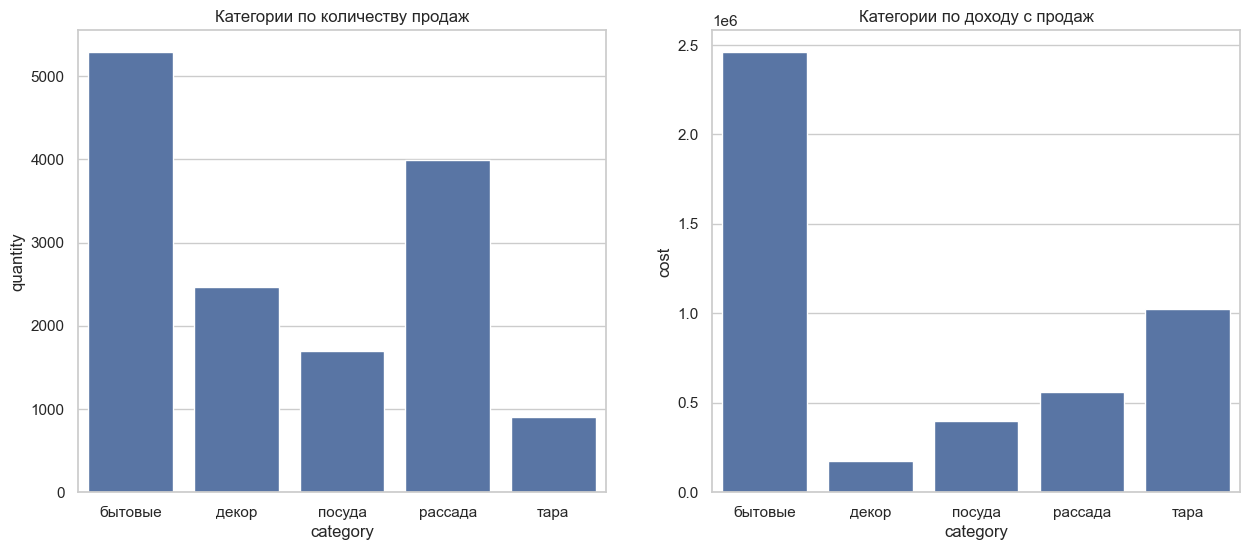

In [53]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=categories,x="category", y="quantity")
plt.title('Категории по количеству продаж')
ax1 = plt.subplot(1, 2, 2)
sns.barplot(data=categories,x="category", y="cost")
plt.title('Категории по доходу с продаж')

Бытовые товары составляют 53% продаж в разраезе доходов и 37% в натуральных величинах.

Рассада и растения составляют 28% продаж от количества и 12% от доходов.

Декор самый дешевый, составляет всего 4% в доходе, но 18% в в натуральных величинах.

Тара - самая дорогостоящая категория, составляет 22% продаж в разраезе доходов и 6% в натуральных величинах.

## Исследовательский анализ

### Анализируем товары:
#### смотрим сезонность в датах заказов в целом
- есть ли глобальный тренд в количестве и объемах продаж

In [54]:

data.pivot_table(values = ('quantity','cost'), columns = 'year', index = ('month'), aggfunc=('sum'))

cost                     quantity               
year       2018      2019      2020     2018    2019   2020
month                                                      
1           NaN 230695.00 174036.33      NaN  611.00 301.00
2           NaN 306383.00       NaN      NaN  944.00    NaN
3           NaN 251561.00       NaN      NaN 1038.00    NaN
4           NaN 317602.00       NaN      NaN 1459.00    NaN
5           NaN 235889.00       NaN      NaN 1543.00    NaN
6           NaN 901515.00       NaN      NaN 1904.00    NaN
7           NaN 234932.00       NaN      NaN  559.00    NaN
8           NaN 172122.00       NaN      NaN  368.00    NaN
9           NaN 179524.00       NaN      NaN  503.00    NaN
10    351536.00 210775.00       NaN  1558.00  813.00    NaN
11    359348.00 128791.75       NaN  1242.00  236.00    NaN
12    354038.00 202885.33       NaN  1009.00  265.00    NaN

В продажах товаров есть ярко выраженная сезонность с пиком в июне и малым в октябре. 

Если рассматривать одинаковые месяцы анализирумеого периода: октябрь 2018 - январь 2019 и октябрь 2019 - январь 2020, наблюдается серьёзный спад продаж, как в количественном, так и встоимостном выражении.

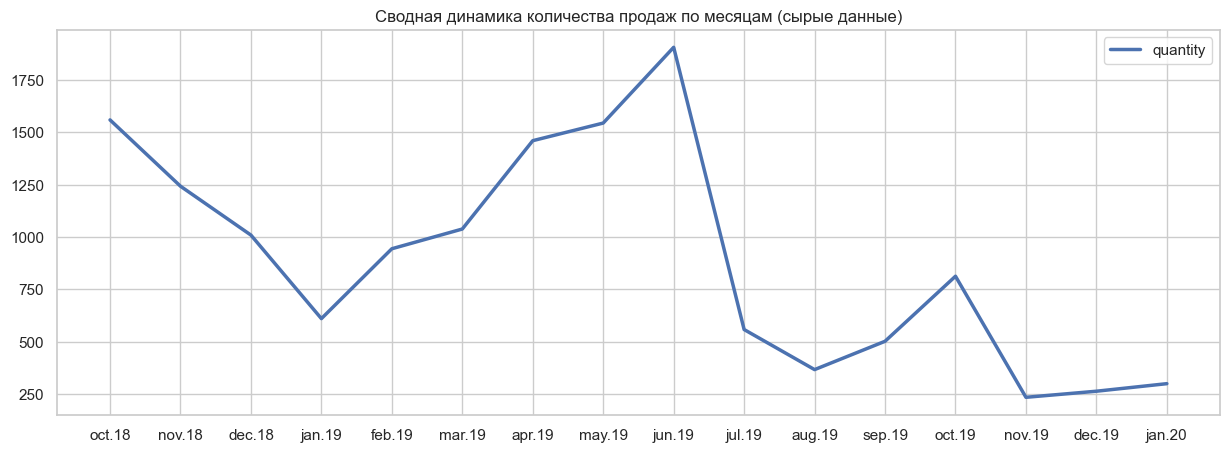

In [55]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сводная динамика количества продаж по месяцам (сырые данные)');

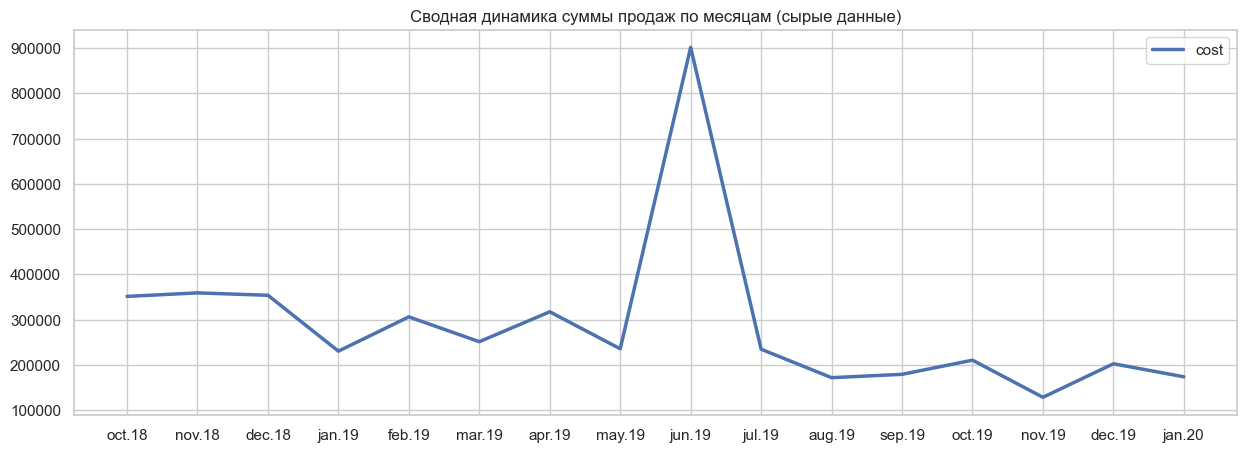

In [56]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data.pivot_table(values = ('cost'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сводная динамика суммы продаж по месяцам (сырые данные)');

#### смотрим популярность товарных категорий: количество товаров, количество покупателей, средние цены, есть ли сезонность в категориях

In [57]:
season_m = data.pivot_table(values = 'quantity', columns = 'category', index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month'])

In [58]:
#season_m

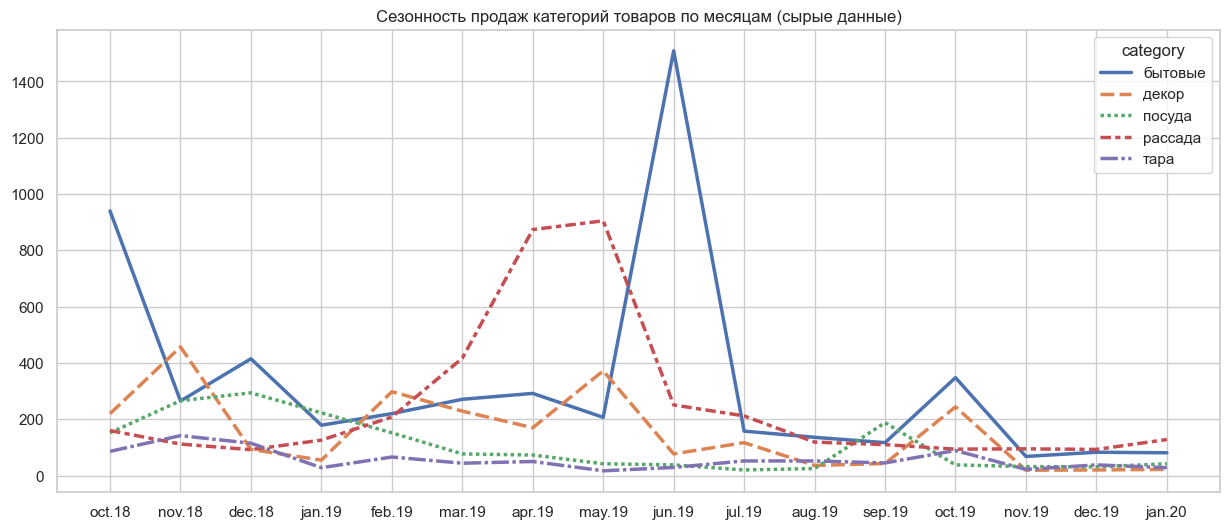

In [59]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=season_m, linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность продаж категорий товаров по месяцам (сырые данные)');


Пик заказов в июне обусловлен выбросом продаж бытовых товаров.

Октябрьский пик продаж обусловлен пиком продаж бытовых товаров и домашнего декора.

С марта по май растут продажи рассады, однако к старту дачного сезона они ожидаемо падают.

Посуда пользуется большей популярностью в январе и сентябре.

Тара продаётся равномерно в течение года.

In [60]:
season_w = data.pivot_table(values = 'quantity', columns = 'category', index = 'week', aggfunc=('sum'))

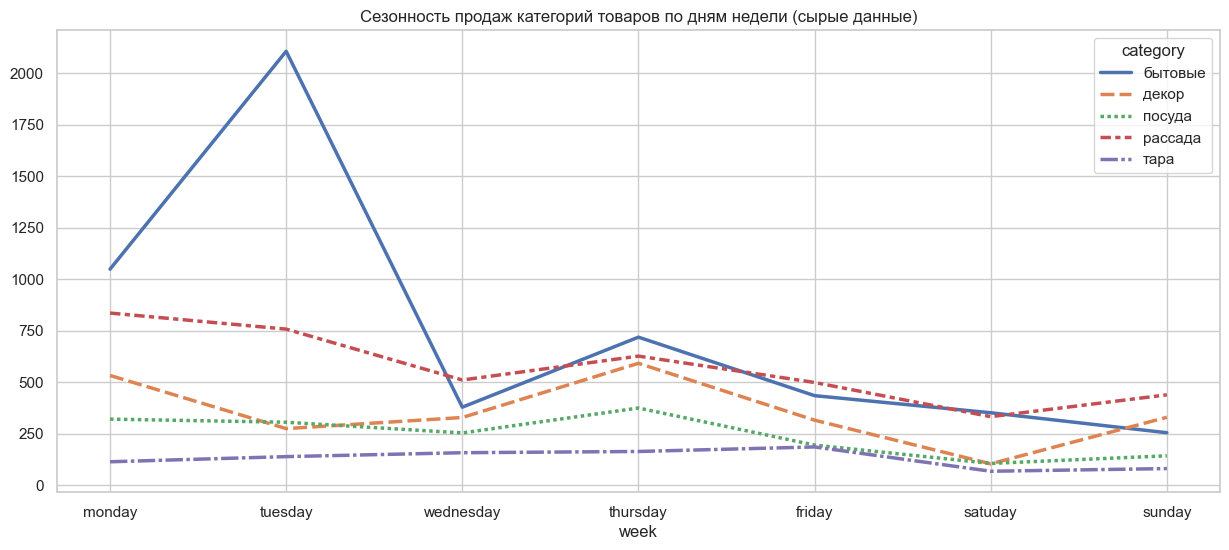

In [61]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=season_w, linewidth=2.5)
plt.xticks(np.arange(7),['monday','tuesday','wednesday','thursday','friday','satuday','sunday'])
plt.title('Сезонность продаж категорий товаров по дням недели (сырые данные)');

Чаще всего бытовые товары заказывают по вторникам.

Рассаду больше заказывают по понедельникам и вторникам.

Декор и посуду - по четвергам.

Суббота - самый тихий по заказам день.

In [62]:
season_h = data.pivot_table(values = 'quantity', columns = 'category', index = 'hour', aggfunc=('sum'))
#season_h

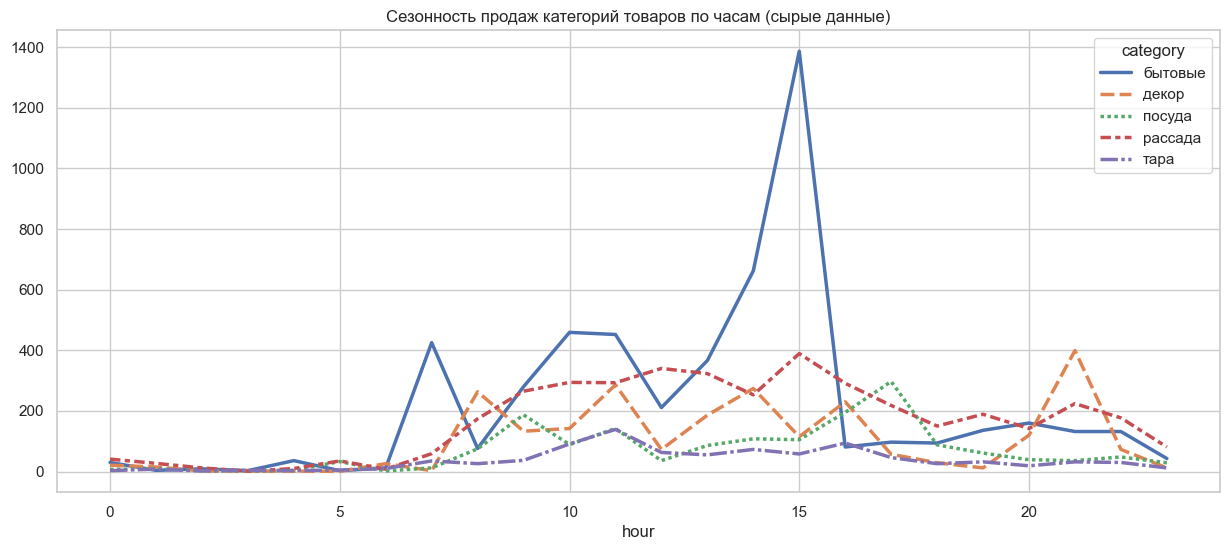

In [63]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=season_h, linewidth=2.5)
plt.title('Сезонность продаж категорий товаров по часам (сырые данные)');

Судя по разбиению времени создания заказа по часам, чаще всего люди занимаются онлайн-шопингом в рабочее время.

Заказы бытовых товаров проседают в обед и достигают пика к 15-16 часам, потом резко падают с концом рабочего дня.

Декор любят выбирать перед сном с пиком заказов к 21 часам.

Рассаду заказывают равномерно в течение всего дня.

#### Анализ отдельных товарных категорий

##### Анализ товаров в категории Рассада

In [64]:
plants = data[data['category'] == 'рассада'].groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
plants['order_part'] = plants['order_id'] / data[data['category'] == 'рассада']['order_id'].count()
plants['cost_part'] = plants['cost'] / data[data['category'] == 'рассада']['cost'].sum()
plants['qty_part'] = plants['quantity'] / data[data['category'] == 'рассада']['quantity'].sum()
plants.head(25)

product  order_id  price  \
0   пеларгония розебудная red pandora укорененный ...        66 134.97   
1   однолетнее растение петуния махровая в кассете...        21  82.38   
2   пеларгония зональная диам. 12 см сиреневый пол...        53 169.72   
3   пеларгония розебудная prins nikolai укорененны...        56 134.79   
4   пеларгония зональная диам. 12 см красная махровая        21 173.52   
5      пеларгония розебудная mary укорененный черенок        40 134.81   
6   пеларгония розебудная margaretha укорененный ч...        31 135.51   
7                           спатифиллум шопен d-12 см         2 256.00   
8   гвоздика стандартная белая 60 см колумбия план...         3  29.00   
9                      циперус зумула d-12 см h-25 см        11 110.64   
10  пеларгония розебудная queen ingrid укорененный...        31 135.78   
11            пеларгония зональная махровая лососевая        25 170.88   
12                         эхинокактус грузони d-5 см         3  74.00   
13       рассада арбуза сорт огонек горшок 9х9 см p-9        12  38.00   
14  пеларгония зональная ринго вайт d-7 см h-10 см...        25  74.00   
15  петуния махровая рассада однолетних цветов в к...        16 211.00   
16  пеларгония зональная диам. 12 см коралловая по...        24 173.75   
17  герань домашняя (пеларгония зональная) цветуща...        13 150.31   
18  пеларгония зональная диам. 12 см темнорозовая ...        22 169.86   
19  роза одноголовая тоффи 70 см эквадор плантация...         1 157.00   
20  роза кустовая ред лейс 60 см кения плантация w...         1 112.00   
21  гвоздика стандартная новия 70 см колумбия план...         1  37.00   
22    пеларгония зональная диам. 12 см белая махровая        16 174.94   
23    рассада арбуза сорт шуга бэби горшок 9х9 см p-9        13  38.00   
24  пеларгония зональная диам. 12 см лососевая мах...        16 163.06   

       cost  quantity  order_part  cost_part  qty_part  
0  11062.33        82        0.02       0.02      0.02  
1   6412.00        78        0.01       0.01      0.02  
2  10949.00        64        0.02       0.02      0.02  
3   8492.50        63        0.02       0.02      0.02  
4  10514.00        63        0.01       0.02      0.02  
5   6470.50        48        0.01       0.01      0.01  
6   6356.67        47        0.01       0.01      0.01  
7  11512.00        46        0.00       0.02      0.01  
8   1305.00        45        0.00       0.00      0.01  
9   4245.00        39        0.00       0.01      0.01  
10  5314.33        39        0.01       0.01      0.01  
11  6704.00        39        0.01       0.01      0.01  
12  2294.00        31        0.00       0.00      0.01  
13  1102.00        29        0.00       0.00      0.01  
14  2072.00        28        0.01       0.00      0.01  
15  5694.00        27        0.01       0.01      0.01  
16  4658.00        27        0.01       0.01      0.01  
17  3845.00        26        0.00       0.01      0.01  
18  4413.00        26        0.01       0.01      0.01  
19  3925.00        25        0.00       0.01      0.01  
20  2800.00        25        0.00       0.01      0.01  
21   925.00        25        0.00       0.00      0.01  
22  4284.00        24        0.01       0.01      0.01  
23   912.00        24        0.00       0.00      0.01  
24  3678.00        23        0.01       0.01      0.01

In [65]:
pelarg = data[data['product'].str.contains('пеларгон', case=False, regex=True) | data['product'].str.contains('геран', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
pelarg['order_part'] = pelarg['order_id'] / data[data['category'] == 'рассада']['order_id'].count()
pelarg['cost_part'] = pelarg['cost'] / data[data['category'] == 'рассада']['cost'].sum()
pelarg['qty_part'] = pelarg['quantity'] / data[data['category'] == 'рассада']['quantity'].sum()

pelarg

category  order_id  price      cost  quantity  order_part  cost_part  \
0  рассада       850 146.78 157749.33      1074        0.31       0.28   
1    декор        10 415.90   8147.00        18        0.00       0.01   

   qty_part  
0      0.27  
1      0.00

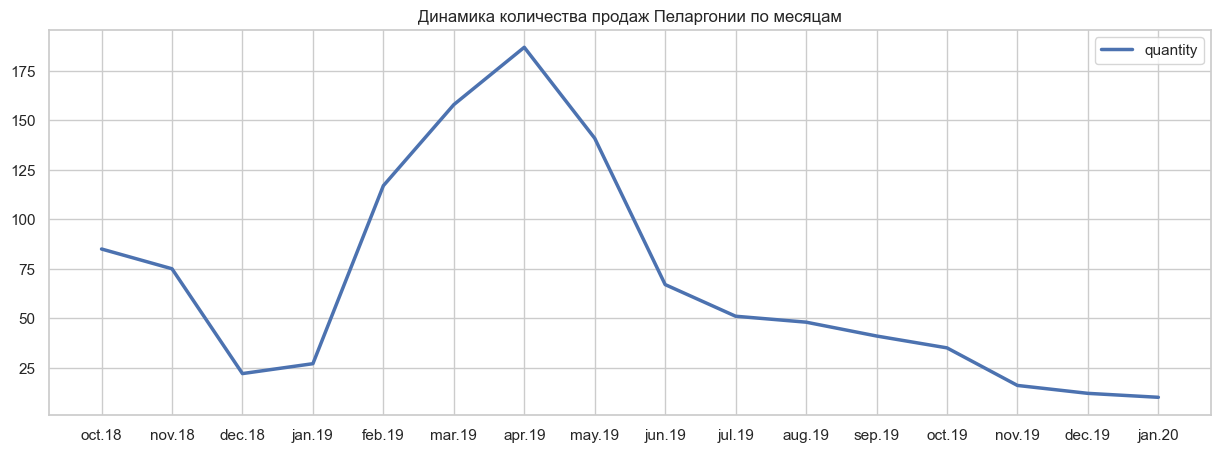

In [66]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data[data['product'].str.contains('пеларгон', case=False, regex=True) | data['product'].str.contains('геран', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Пеларгонии по месяцам');

Пеларгония, или герань - абсолютный лидер в категории "рассада" 31% заказов в категории содержат эту позицию, она приносит 28% дохода от продаж в категории и составляет 27% товарооборота.

Пик продаж приходится на весну.

In [67]:
tomat = data[data['product'].str.contains('томат', case=False, regex=True) | data['product'].str.contains('помидор', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
tomat['order_part'] = tomat['order_id'] / data[data['category'] == 'рассада']['order_id'].count()
tomat['cost_part'] = tomat['cost'] / data[data['category'] == 'рассада']['cost'].sum()
tomat['qty_part'] = tomat['quantity'] / data[data['category'] == 'рассада']['quantity'].sum()

tomat

category  order_id  price     cost  quantity  order_part  cost_part  \
0  рассада       203 112.14 29761.00       386        0.07       0.05   
1    декор         3  89.00   326.00         4        0.00       0.00   

   qty_part  
0      0.10  
1      0.00

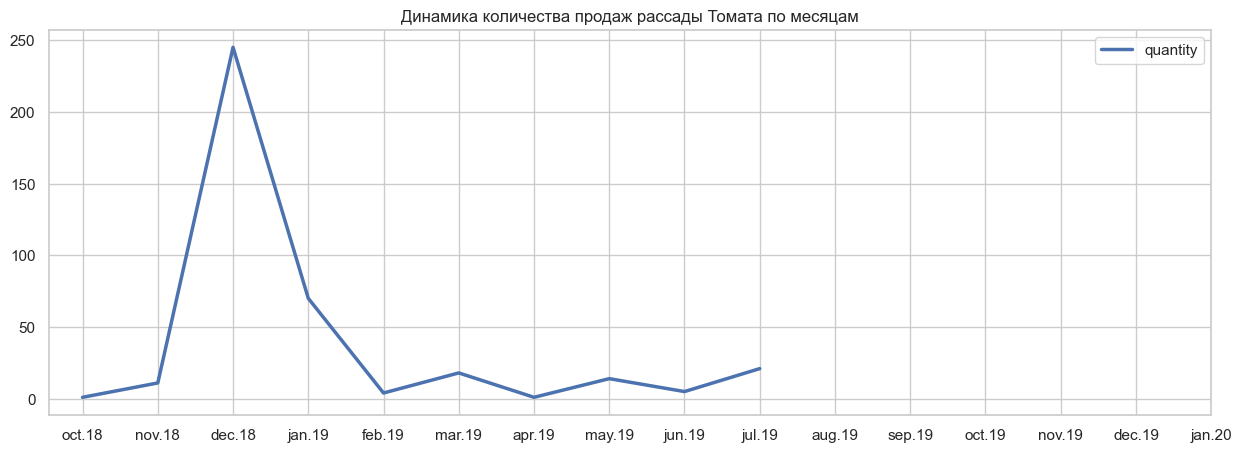

In [68]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data[data['product'].str.contains('томат', case=False, regex=True) | data['product'].str.contains('помидор', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж рассады Томата по месяцам');

На втором месте рассада томата, в 7% заказов, 5% от дохода и 10% от товарообота.

Пик продаж приходился на декабрь 2018.
Продажи резко прекратились летом 2019 года, либо товар ушел из ассортимента и его надо вернуть, либо проиграли по ценам конкурентам.

In [69]:
petun = data[data['product'].str.contains('петун', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
petun['order_part'] = petun['order_id'] / data[data['category'] == 'рассада']['order_id'].count()
petun['cost_part'] = petun['cost'] / data[data['category'] == 'рассада']['cost'].sum()
petun['qty_part'] = petun['quantity'] / data[data['category'] == 'рассада']['quantity'].sum()

petun

category  order_id  price     cost  quantity  order_part  cost_part  \
0  рассада       185 132.21 36486.50       292        0.07       0.07   
1    декор         6 283.67  3638.00        17        0.00       0.01   

   qty_part  
0      0.07  
1      0.00

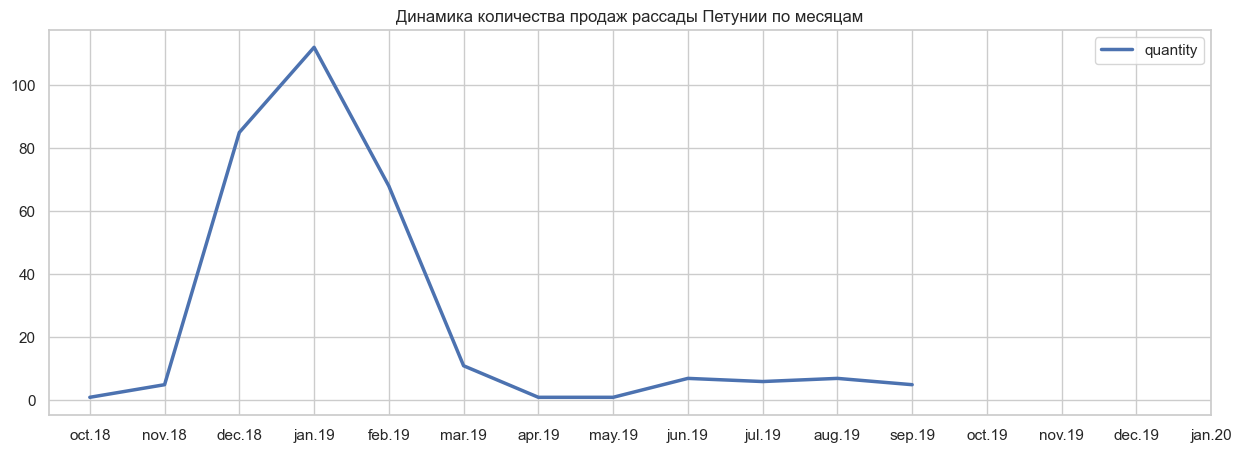

In [70]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data[data['product'].str.contains('петун', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж рассады Петунии по месяцам');

На 3м месте петуния, в 7% заказов, 7% от дохода и 7% от товарообота.

Пик продаж приходился на январь 2019, с октября продажи упали до 0.

In [71]:
roz = data[data['product'].str.contains('роза', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
roz['order_part'] = roz['order_id'] / data[data['category'] == 'рассада']['order_id'].count()
roz['cost_part'] = roz['cost'] / data[data['category'] == 'рассада']['cost'].sum()
roz['qty_part'] = roz['quantity'] / data[data['category'] == 'рассада']['quantity'].sum()

roz

category  order_id  price     cost  quantity  order_part  cost_part  \
0  рассада        70 209.54 22812.50       135        0.03       0.04   
1    декор        12  29.08  3457.00       122        0.00       0.01   
2   посуда         8 409.12  4165.00        11        0.00       0.01   

   qty_part  
0      0.03  
1      0.03  
2      0.00

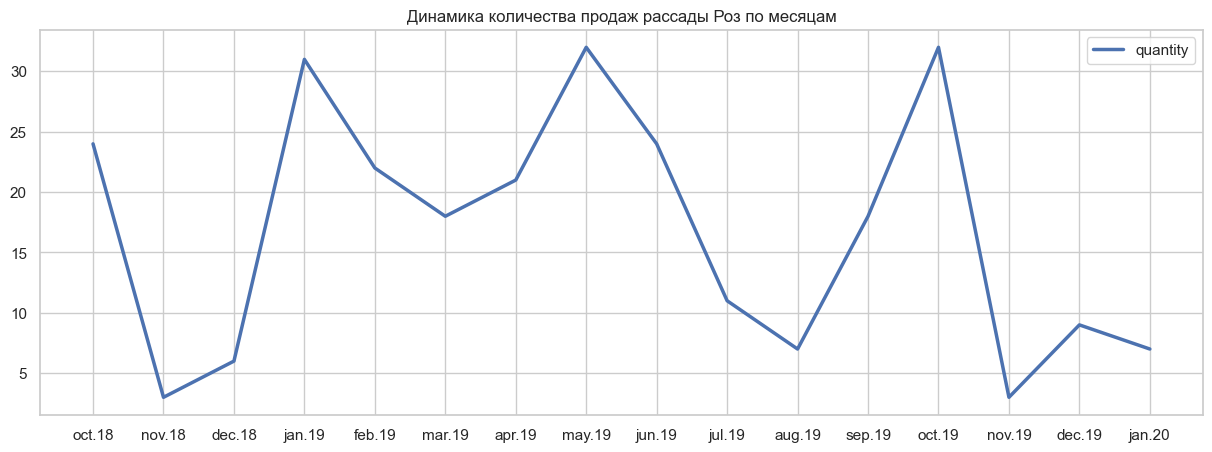

In [72]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data[data['product'].str.contains('роза', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж рассады Роз по месяцам');

Розы брали в 3% заказов рассады, они составили 4% в общем доходе и 3% товарооборота.

In [73]:
arbuz = data[data['product'].str.contains('арбуз', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
arbuz['order_part'] = arbuz['order_id'] / data[data['category'] == 'рассада']['order_id'].count()
arbuz['cost_part'] = arbuz['cost'] / data[data['category'] == 'рассада']['cost'].sum()
arbuz['qty_part'] = arbuz['quantity'] / data[data['category'] == 'рассада']['quantity'].sum()

arbuz

category  order_id  price    cost  quantity  order_part  cost_part  qty_part
0  рассада        59  37.32 4406.00       117        0.02       0.01      0.03
1    декор         1  59.00  118.00         2        0.00       0.00      0.00

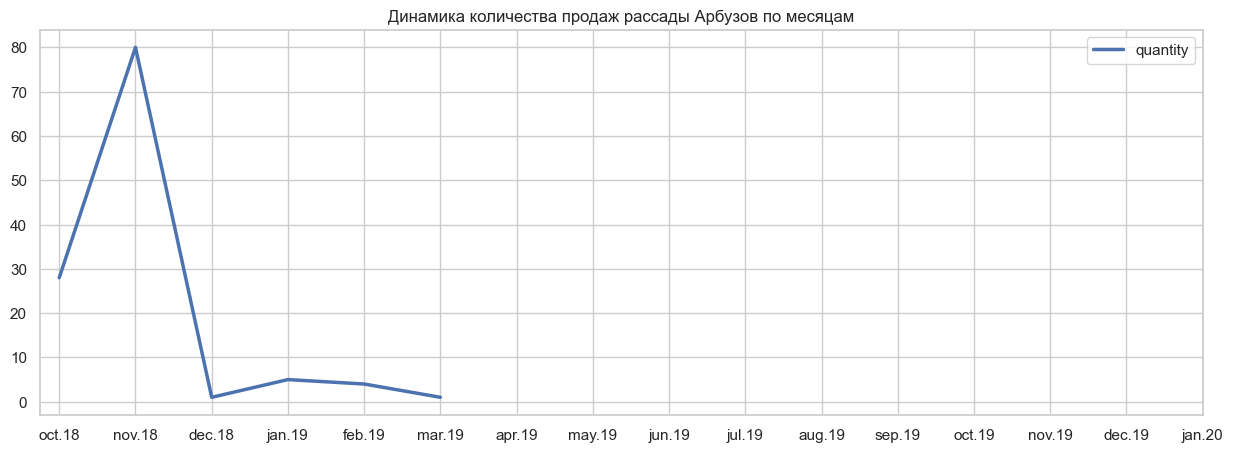

In [74]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data[data['product'].str.contains('арбуз', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж рассады Арбузов по месяцам');

Замыкает пятерку Арбуз, в 2% заказоа, 1% от дохода и 3% товарооборота в категории рассада.

Пик продаж приходился на ноябрь 2018.
Продажи резко прекратились весной 2019 года, либо товар ушел из ассортимента и его надо вернуть, либо проиграли по ценам конкурентам.

**Товары категории Рассада**

Общие хараткеристики продаж в категории Рассада носят розничный характер.

Декоративные растения пользуются популярностью весной, плодовые обычно покупают на рассаду за год до начала сезона, эта категория поможет сгладить ярко выраженную сезонность спроса, однако в ней могут наблюдаться проблемы.

Данные продаж товаров по категории рассада говорят о возможных проблемах с товарным ассортиментом. Рекомендуется проверить ассортимент рассады и составить конкуретные карты по самым ходовым позициям.

##### Анализ товаров в категории Бытовые

In [75]:
house_total = data[data['category'] == 'бытовые']
house_mass = house_total[house_total['quantity']>=6].sort_values(by='quantity',ascending=False)
house_ind = house_total[house_total['quantity']<6].sort_values(by='quantity',ascending=False)

house = house_ind.groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).reset_index()
house['order_part'] = house['order_id'] / data[data['category'] == 'бытовые']['order_id'].count()
house['cost_part'] = house['cost'] / data[data['category'] == 'бытовые']['cost'].sum()
house['qty_part'] = house['quantity'] / data[data['category'] == 'бытовые']['quantity'].sum()
house.sort_values(by='quantity',ascending=False).head(25)

product  order_id   price  \
487  сушилка для белья настенная zalger prima 510-7...        17  272.71   
101      гладильная доска ника дсп эконом 106,5х29 эк1         6  449.00   
202  коврик придверный хлопковый 60х140 см мультико...         5  277.00   
509   сушилка для белья потолочная лиана 2,4 м 1703011        10  734.00   
507   сушилка для белья потолочная лиана 2,0 м 1703009        11  599.00   
483       сушилка для белья напольная ника сбп1/с 18 м         9  599.00   
315    плечики пластмассовые размер 48 - 54 мп 1205160         5   22.00   
585       чехол для костюма 60х110 см rozenbal r261016         8  164.00   
505   сушилка для белья потолочная лиана 1,7 м 1703006         7  562.00   
216  коврик хлопковый 45х75 см цвета в ассортименте...         3  127.00   
318  подкладка под чехол zalger 520114 135х50 см во...         7  127.00   
513  сушилка для белья потолочная лиана люкс 160 см...         6  449.00   
37   вешалка-плечики без эссенции цвет тёмно-розовы...         2   45.00   
508   сушилка для белья потолочная лиана 2,2 м 1703010         6  697.00   
83          гладильная доска ника blues 124х46 см 5757         7 2540.86   
372       сиденье в ванну раздвижное, белый, св5, ника         6  316.67   
68      гладильная доска sarayli new elegant 125x45 см         7 2549.00   
86    гладильная доска ника lora fashion hlf 123х46 см         7 1925.21   
497  сушилка для белья потолочная zalger lift basic...         7  614.00   
363  рукав для гладильной доски colombo stiramanich...         5  348.50   
319  подкладка под чехол zalger 520140 135х50 см по...         6  127.00   
5                        бензин для зажигалок, 1205214         4   67.00   
215  коврик хлопковый 40х60 см цвета в ассортименте...         4   97.00   
581  чехол для гладильной доски универсальный 2, 12...         2  164.00   
349  полотенце прессованное p48 сердце_3, 100% хлоп...         2   89.00   

        cost  quantity  order_part  cost_part  qty_part  
487  5533.00        20        0.01       0.00      0.00  
101  4939.00        11        0.00       0.00      0.00  
202  3047.00        11        0.00       0.00      0.00  
509  8074.00        11        0.01       0.00      0.00  
507  6589.00        11        0.01       0.00      0.00  
483  5990.00        10        0.01       0.00      0.00  
315   220.00        10        0.00       0.00      0.00  
585  1640.00        10        0.01       0.00      0.00  
505  5620.00        10        0.01       0.00      0.00  
216  1143.00         9        0.00       0.00      0.00  
318  1143.00         9        0.01       0.00      0.00  
513  3592.00         8        0.00       0.00      0.00  
37    360.00         8        0.00       0.00      0.00  
508  4879.00         7        0.00       0.00      0.00  
83  17786.00         7        0.01       0.01      0.00  
372  2102.00         7        0.00       0.00      0.00  
68  17843.00         7        0.01       0.01      0.00  
86  13476.50         7        0.01       0.01      0.00  
497  4298.00         7        0.01       0.00      0.00  
363  1967.50         6        0.00       0.00      0.00  
319   762.00         6        0.00       0.00      0.00  
5     402.00         6        0.00       0.00      0.00  
215   582.00         6        0.00       0.00      0.00  
581   984.00         6        0.00       0.00      0.00  
349   534.00         6        0.00       0.00      0.00

In [76]:
house_mass['cost'].sum()/ house_total['cost'].sum()

0.40888644213995573

In [77]:
house_ind['cost'].sum()/ house_total['cost'].sum()

0.5911135578600443

В категории бытовых товаров заказы делятся на розничные и мелкооптовые. Условно разделим заказы по количеству товара 5 ед.

Оптовые заказы дают 40% дохода в сегменте бытовых товаров

Розничные заказы дают 60% дохода в сегменте бытовых товаров

**Работа и коммуникация с оптовыми и розничными сегментами клиентов должна строится по-разному.**

In [78]:
house_mass.groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).reset_index().sort_values(by='quantity',ascending=False)

product  order_id  price  \
0   вантуз с деревянной ручкой d14 см красный, bur...         1 675.00   
18   вешалки мягкие для деликатных вещей 3 шт шоколад         1 148.00   
47      ручка-скоба рс-100 белая *трибатрон*, 1108035         1  29.00   
30                крепеж для пружины дверной, 1107055         2  20.50   
44  плечики пластмассовые размер 52 - 54 тула 1205158         2  20.50   
..                                                ...       ...    ...   
13  вешалка с закругленными плечиками без переклад...         1 106.00   
12  вешалка металлическая valiant с четырьмя разъе...         1 135.00   
25  коврик хлопковый 40х60 см цвета в ассортименте...         1  97.00   
19  гладильная доска zalger amelia 400-401 дсп 115...         1 749.00   
20      гладильная доска ника дсп эконом 106,5х29 эк1         1 449.00   

        cost  quantity  
0  675000.00      1000  
18  49432.00       334  
47   5800.00       200  
30   3290.00       170  
44   3210.00       160  
..       ...       ...  
13    742.00         7  
12    945.00         7  
25    582.00         6  
19   4494.00         6  
20   2694.00         6  

[65 rows x 5 columns]

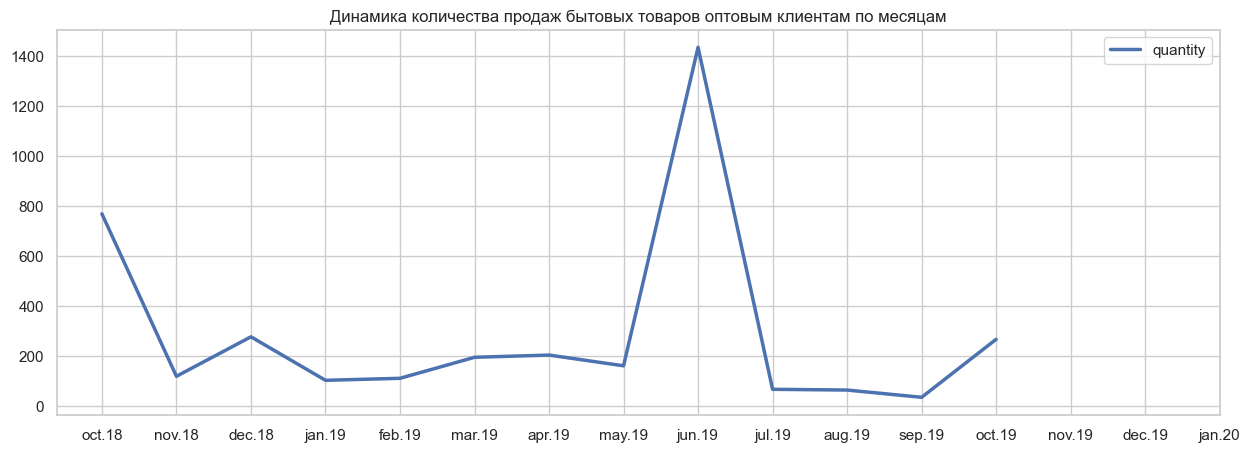

In [79]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=house_mass.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж бытовых товаров оптовым клиентам по месяцам');

**Бытовые товары для оптовых клиентов**

Оптовые заказчики обычно покупают товары для нужд бизнеса, по имеющимся данным сложно спрогнозировать и охарактеризовать их потребности, однако по динамике продаж четко видно отсутствие продаж оптовикам с ноября 2019 года.

Работа с оптовиками требует индивидуального подхода, их можно включать в обычне рассылки, однако также им необходимо делать индивидуальные предложения, оптимальнее всего назначить отдельного менеджера по работе с оптовыми клиентами, предложить им выгодные условия и сроки поставки

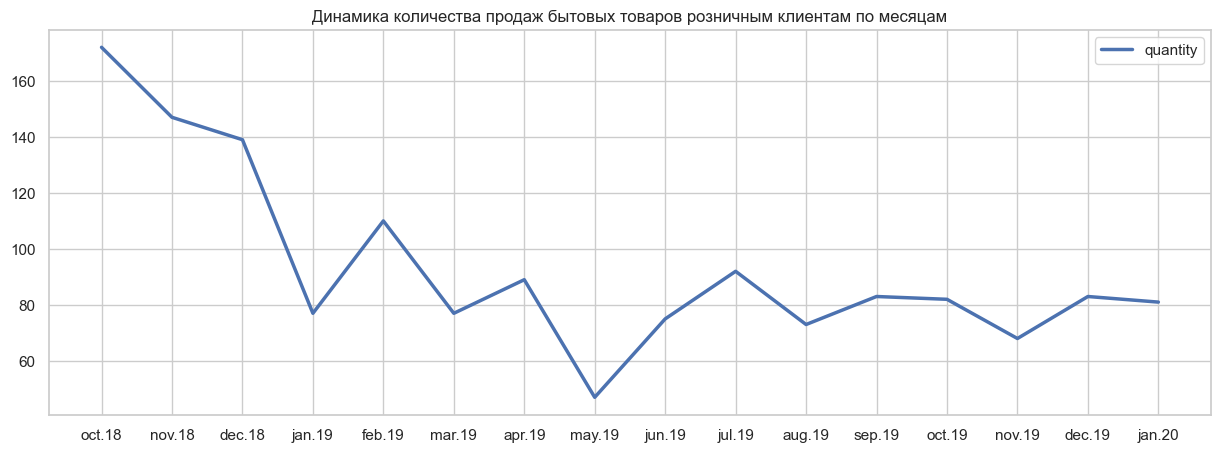

In [80]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=house_ind.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж бытовых товаров розничным клиентам по месяцам');

In [81]:
house.sort_values(by='order_id',ascending=False).head(25)


product  order_id   price  \
487  сушилка для белья настенная zalger prima 510-7...        17  272.71   
507   сушилка для белья потолочная лиана 2,0 м 1703009        11  599.00   
509   сушилка для белья потолочная лиана 2,4 м 1703011        10  734.00   
483       сушилка для белья напольная ника сбп1/с 18 м         9  599.00   
585       чехол для костюма 60х110 см rozenbal r261016         8  164.00   
505   сушилка для белья потолочная лиана 1,7 м 1703006         7  562.00   
86    гладильная доска ника lora fashion hlf 123х46 см         7 1925.21   
83          гладильная доска ника blues 124х46 см 5757         7 2540.86   
68      гладильная доска sarayli new elegant 125x45 см         7 2549.00   
318  подкладка под чехол zalger 520114 135х50 см во...         7  127.00   
497  сушилка для белья потолочная zalger lift basic...         7  614.00   
454     сушилка для белья лиана люкс 130 см потолочная         6  427.00   
372       сиденье в ванну раздвижное, белый, св5, ника         6  316.67   
513  сушилка для белья потолочная лиана люкс 160 см...         6  449.00   
508   сушилка для белья потолочная лиана 2,2 м 1703010         6  697.00   
101      гладильная доска ника дсп эконом 106,5х29 эк1         6  449.00   
323                        подрукавник складной ника п         6  224.00   
319  подкладка под чехол zalger 520140 135х50 см по...         6  127.00   
557  чехол для гладильной доски colombo persia beig...         5  674.00   
363  рукав для гладильной доски colombo stiramanich...         5  348.50   
476  сушилка для белья напольная ника сб1г 18 м бел...         5  652.00   
645  штора для ванной комнаты quadretto 240х200 см ...         5 1199.00   
555  чехол для гладильной доски attribute metal 140...         5  656.87   
614  штанга для ванной г-образная, угловая 80х170 с...         5  974.00   
315    плечики пластмассовые размер 48 - 54 мп 1205160         5   22.00   

        cost  quantity  order_part  cost_part  qty_part  
487  5533.00        20        0.01       0.00      0.00  
507  6589.00        11        0.01       0.00      0.00  
509  8074.00        11        0.01       0.00      0.00  
483  5990.00        10        0.01       0.00      0.00  
585  1640.00        10        0.01       0.00      0.00  
505  5620.00        10        0.01       0.00      0.00  
86  13476.50         7        0.01       0.01      0.00  
83  17786.00         7        0.01       0.01      0.00  
68  17843.00         7        0.01       0.01      0.00  
318  1143.00         9        0.01       0.00      0.00  
497  4298.00         7        0.01       0.00      0.00  
454  2562.00         6        0.00       0.00      0.00  
372  2102.00         7        0.00       0.00      0.00  
513  3592.00         8        0.00       0.00      0.00  
508  4879.00         7        0.00       0.00      0.00  
101  4939.00        11        0.00       0.00      0.00  
323  1344.00         6        0.00       0.00      0.00  
319   762.00         6        0.00       0.00      0.00  
557  3370.00         5        0.00       0.00      0.00  
363  1967.50         6        0.00       0.00      0.00  
476  3260.00         5        0.00       0.00      0.00  
645  5995.00         5        0.00       0.00      0.00  
555  3908.67         6        0.00       0.00      0.00  
614  4870.00         5        0.00       0.00      0.00  
315   220.00        10        0.00       0.00      0.00

In [82]:
house.sort_values(by='cost',ascending=False).head(25)

product  order_id    price  \
416                     сушилка meliconi stendy junior         5  5594.00   
538  урна уличная "гео", hobbyka/хоббика, 59*37,5см...         1  4874.00   
68      гладильная доска sarayli new elegant 125x45 см         7  2549.00   
83          гладильная доска ника blues 124х46 см 5757         7  2540.86   
530  сушилка уличная leifheit 85210 linomatic v 400...         1 14917.00   
65   гладильная доска leifheit airboard compact m p...         2  7424.00   
49        гладильная доска colombo avantgard 120х40 см         3  4904.00   
86    гладильная доска ника lora fashion hlf 123х46 см         7  1925.21   
374  сиденье для гладильной доски leifheit niveau, ...         2  6149.00   
492  сушилка для белья настенная складная алюминиев...         3  3749.00   
427                  сушилка для белья gimi dinamik 30         4  2699.00   
346  полки qwerty торонто белый 40х10 см 35х10 см 3...         3  3524.00   
602  швабра для мытья окон leifheit hausrein с теле...         3  2624.00   
344  полки qwerty рио белый/чёрный 42,5х21х10 см 17...         4  1949.00   
330  покрывало жаккард шенилл birhome valentin 240х...         2  4859.00   
412  стремянки colombo leonardo 2 ступени g300a02w ...         3  2999.00   
338  полки qwerty берлин чёрный 44х24х10 см 40х20х1...         3  2118.00   
525  сушилка для белья потолочно-настенная gimi lif...         4  1649.00   
509   сушилка для белья потолочная лиана 2,4 м 1703011        10   734.00   
341  полки qwerty мадрид белый/чёрный 50х30х12 см 2...         2  3993.00   
413  стремянки colombo leonardo 3 ступени g300a03w ...         2  3974.00   
48   гладильная доска attribute хоми топ 124х40 см ...         2  2624.00   
46   гладильная доска attribute teflonix 130х46 см ...         2  3899.00   
339  полки qwerty италия белый/серый 40х14х10 см 35...         3  1949.00   
342  полки qwerty нью-йорк правый белый/голубой 44х...         4  1940.00   

        cost  quantity  order_part  cost_part  qty_part  
416 27970.00         5        0.00       0.01      0.00  
538 24370.00         5        0.00       0.01      0.00  
68  17843.00         7        0.01       0.01      0.00  
83  17786.00         7        0.01       0.01      0.00  
530 14917.00         1        0.00       0.01      0.00  
65  14848.00         2        0.00       0.01      0.00  
49  14712.00         3        0.00       0.01      0.00  
86  13476.50         7        0.01       0.01      0.00  
374 12298.00         2        0.00       0.01      0.00  
492 11247.00         3        0.00       0.00      0.00  
427 10796.00         4        0.00       0.00      0.00  
346 10572.00         3        0.00       0.00      0.00  
602 10496.00         4        0.00       0.00      0.00  
344  9745.00         5        0.00       0.00      0.00  
330  9718.00         2        0.00       0.00      0.00  
412  8997.00         3        0.00       0.00      0.00  
338  8341.00         4        0.00       0.00      0.00  
525  8245.00         5        0.00       0.00      0.00  
509  8074.00        11        0.01       0.00      0.00  
341  7986.00         2        0.00       0.00      0.00  
413  7948.00         2        0.00       0.00      0.00  
48   7872.00         3        0.00       0.00      0.00  
46   7798.00         2        0.00       0.00      0.00  
339  7796.00         4        0.00       0.00      0.00  
342  7760.00         4        0.00       0.00      0.00

In [83]:
sush = house_ind[house_ind['product'].str.contains('сушилк', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
sush['order_part'] = sush['order_id'] / house_ind['order_id'].count()
sush['cost_part'] = sush['cost'] / house_ind['cost'].sum()
sush['qty_part'] = sush['quantity'] / house_ind['quantity'].sum()

sush



category  order_id   price      cost  quantity  order_part  cost_part  \
0  бытовые       313 1114.35 362236.00       335        0.25       0.25   

   qty_part  
0      0.22

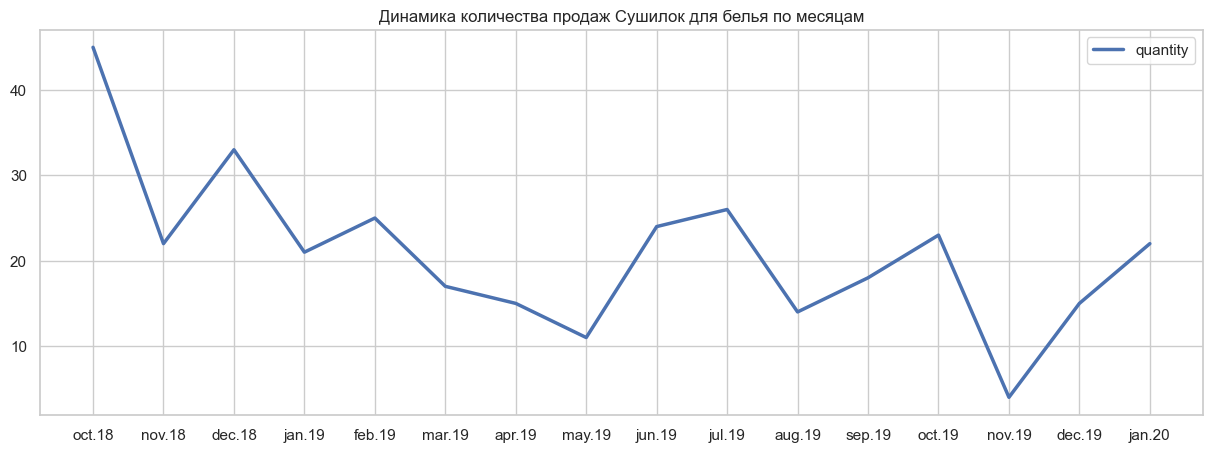

In [84]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=house_ind[house_ind['product'].str.contains('сушилк', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Сушилок для белья по месяцам');


Различного вида сушилки для белья (уличные, настенные, потолочные лианы) составляют четверть продаж всех бытовых товаров индивидуальным клиентам.

Относительно общих продаж показывают нормальную динамику.

In [85]:
glad = house_ind[house_ind['product'].str.contains('гладил', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
glad['order_part'] = glad['order_id'] / house_ind['order_id'].count()
glad['cost_part'] = glad['cost'] / house_ind['cost'].sum()
glad['qty_part'] = glad['quantity'] / house_ind['quantity'].sum()

glad



category  order_id   price      cost  quantity  order_part  cost_part  \
0  бытовые       218 1476.24 335379.17       242        0.17       0.23   

   qty_part  
0      0.16

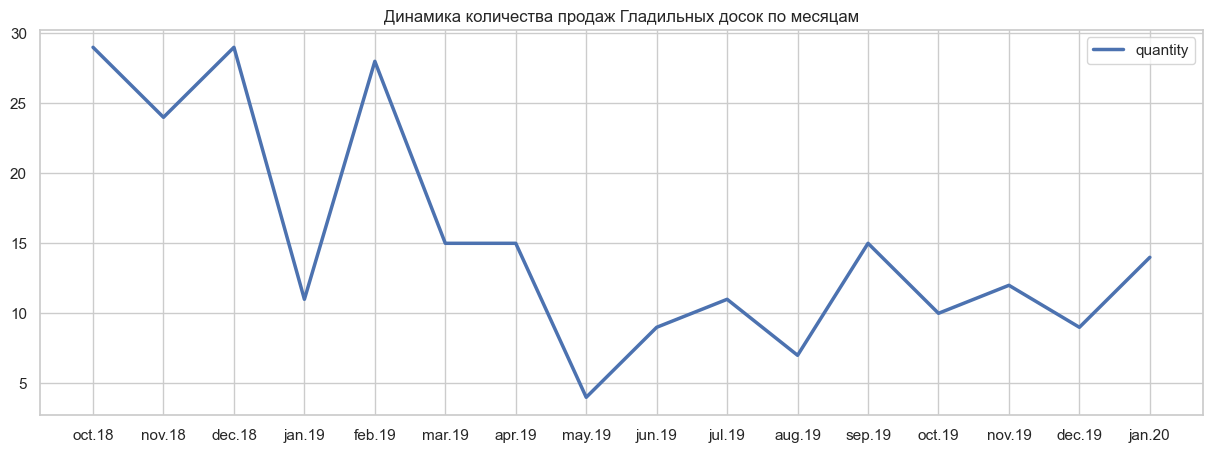

In [86]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=house_ind[house_ind['product'].str.contains('гладил', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Гладильных досок по месяцам');


Гладильные доски на втором месте по продажам бытовых товаров индивидуальным клиентам, составляют 23% продаж в стоимостном выражении и 16% в количественном, были в 17% заказов.

In [87]:
kovr = house_ind[house_ind['product'].str.contains('коврик', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
kovr['order_part'] = kovr['order_id'] / house_ind['order_id'].count()
kovr['cost_part'] = kovr['cost'] / house_ind['cost'].sum()
kovr['qty_part'] = kovr['quantity'] / house_ind['quantity'].sum()

kovr



category  order_id  price      cost  quantity  order_part  cost_part  \
0  бытовые       113 893.93 113138.50       140        0.09       0.08   

   qty_part  
0      0.09

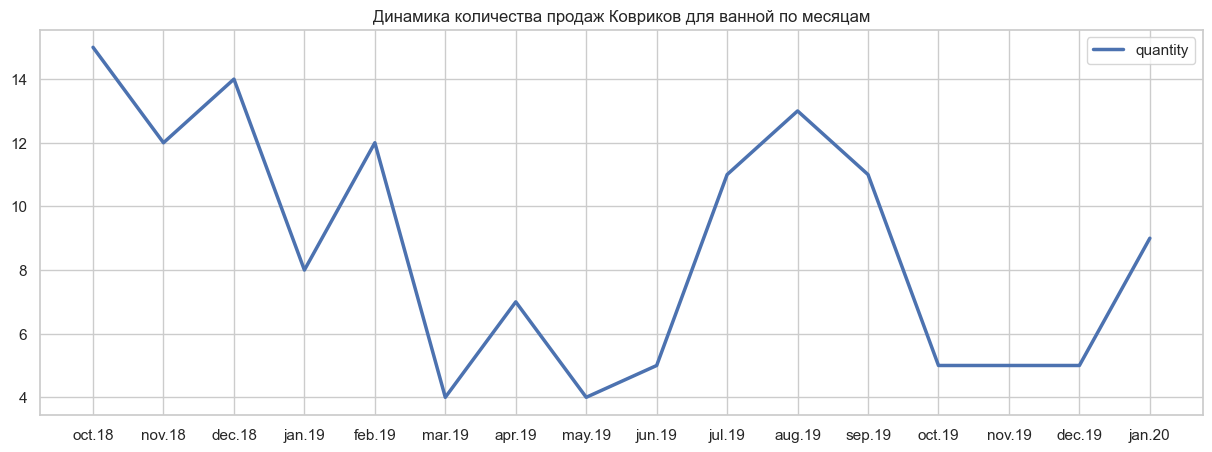

In [88]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=house_ind[house_ind['product'].str.contains('коврик', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Ковриков для ванной по месяцам');


На третьем месте по продажам бытовых товаров индивидуальным клиентам коврики для ванных комнат, 9% от всех заказов

In [89]:
shtor = house_ind[house_ind['product'].str.contains('штор', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
shtor['order_part'] = shtor['order_id'] / house_ind['order_id'].count()
shtor['cost_part'] = shtor['cost'] / house_ind['cost'].sum()
shtor['qty_part'] = shtor['quantity'] / house_ind['quantity'].sum()

shtor



category  order_id   price      cost  quantity  order_part  cost_part  \
0  бытовые        89 1055.93 105335.00       104        0.07       0.07   

   qty_part  
0      0.07

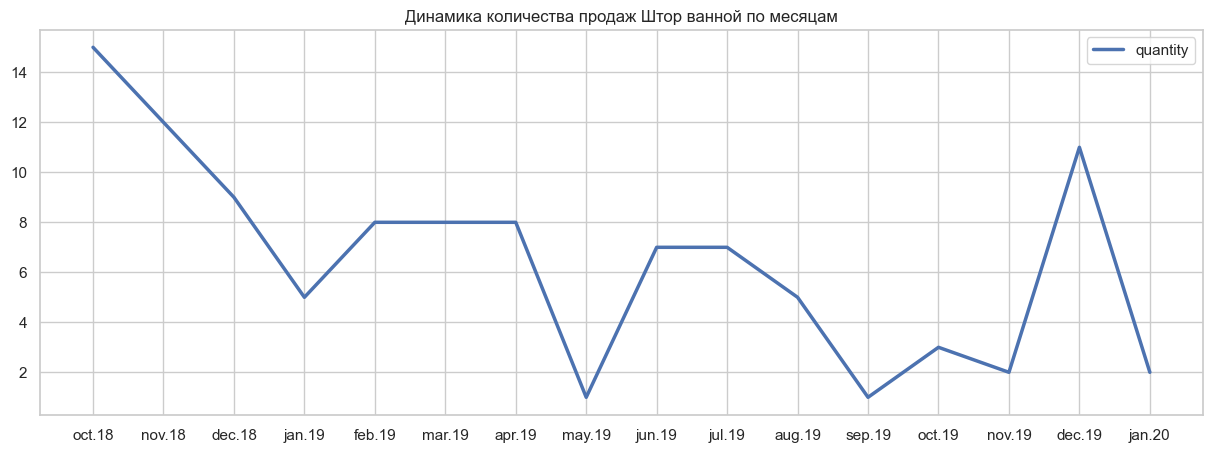

In [90]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=house_ind[house_ind['product'].str.contains('штор', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Штор ванной по месяцам');


На четвертом месте по продажам бытовых товаров индивидуальным клиентам Шторы для ванных комнат, 7% от всех заказов

**Бытовые товары для розничных клиентов**

Большую часть продаж бытовых товаров розничным покупателям составляют Сушилки для белья, гладильные доски, коврики и шторы для ванных комнат.

Все эти товары комплиментарные, можно увеличить продажи как через интернет магазин, баннерами "не забудьте также купить..." так и по рассылкам, присылая подборку других категорий, если клиент купил один из товаров категории

##### Анализ товаров в категории Посуда

In [91]:
dishes_total = data[data['category'] == 'посуда']
dishes_mass = dishes_total[dishes_total['quantity']>10].sort_values(by='quantity',ascending=False)
dishes_ind = dishes_total[dishes_total['quantity']<=10].sort_values(by='quantity',ascending=False)

dishes = dishes_ind.groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).reset_index()
dishes['order_part'] = dishes['order_id'] / data[data['category'] == 'посуда']['order_id'].count()
dishes['cost_part'] = dishes['cost'] / data[data['category'] == 'посуда']['cost'].sum()
dishes['qty_part'] = dishes['quantity'] / data[data['category'] == 'посуда']['quantity'].sum()
dishes.sort_values(by='quantity',ascending=False).head(25)

product  order_id   price  \
20        блюдце утро эклипс, j3261, luminarc, франция         3   56.50   
220  тарелка десертная luminarc сина сильвер 19 см ...         3   94.00   
153  салфетка махровая радуга в разноцветную полоск...         2   38.00   
143          салатник воларэ блэк 16 см g9403 luminarc         2   97.00   
237  тарелка обеденная стелла шоколад 25 см j1762 l...         3  217.00   
50   комплект махровых салфеток топ_2, 100% хлопок ...         3  139.00   
221  тарелка десертная воларэ блэк 22,5 см g9399 lu...         2  101.00   
180  скатерть круглая d-175 см 50% полиэстер 50% хл...         1 1140.00   
70   кухонное полотенце махровое 42х28 см wellness ...         1   43.00   
216        столовый нож 2 шт сапфир тяжелый снsapfir-2         1  223.00   
208  стакан низкий лабиринт 250 мл для напитков 05с...         1   21.00   
234  тарелка обеденная котон флауэр 25 см h2776 lum...         3   90.67   
75   ложка столовая ripple сталь 3 мм, 3 шт, attrib...         3  202.00   
76   ложка чайная ripple сталь 2,5 мм, 3 шт, attrib...         3  142.00   
88   модульная стеклянная банка 1,1л, 298264, braba...         2  825.00   
28   вилка столовая ripple сталь 3 мм, 3 шт, attrib...         4  187.00   
219      тарелка десертная luminarc дивали 19 см d7358         3   86.00   
241          тарелка суповая ирис 21 см j1299 luminarc         1   89.00   
160  скатерть 180 см wellness wtd180-лион*01 100% п...         1 1104.00   
226  тарелка десертная мока браун 19 см h7013 luminarc         2   66.50   
115  нож кухонный для мяса с пластмассовой ручкой 3...         3  127.00   
118   нож столовый ripple 80 г 2 шт, attribute, acr042         3  172.00   
272  чайная ложка trendy сталь 2 мм 3 шт attribute ...         1  172.00   
38   измельчитель овощей ручной шк-4 деревянный, 3 ...         4  479.00   
16   банка стеклянная с крышкой attribute fleur 135...         2  194.00   

        cost  quantity  order_part  cost_part  qty_part  
20   1024.50        18        0.01       0.00      0.01  
220  1128.00        12        0.01       0.00      0.01  
153   456.00        12        0.00       0.00      0.01  
143  1164.00        12        0.00       0.00      0.01  
237  2604.00        12        0.01       0.01      0.01  
50   1683.00        12        0.01       0.00      0.01  
221  1111.00        11        0.00       0.00      0.01  
180 11400.00        10        0.00       0.03      0.01  
70    430.00        10        0.00       0.00      0.01  
216  2230.00        10        0.00       0.01      0.01  
208   210.00        10        0.00       0.00      0.01  
234   822.00         9        0.01       0.00      0.01  
75   1818.00         9        0.01       0.00      0.01  
76   1278.00         9        0.01       0.00      0.01  
88   6600.00         8        0.00       0.02      0.00  
28   1496.00         8        0.01       0.00      0.00  
219   688.00         8        0.01       0.00      0.00  
241   712.00         8        0.00       0.00      0.00  
160  8832.00         8        0.00       0.02      0.00  
226   577.00         8        0.00       0.00      0.00  
115  1016.00         8        0.01       0.00      0.00  
118  1204.00         7        0.01       0.00      0.00  
272  1204.00         7        0.00       0.00      0.00  
38   3353.00         7        0.01       0.01      0.00  
16   1358.00         7        0.00       0.00      0.00

In [92]:
dishes_mass['cost'].sum()/ dishes_total['cost'].sum()

0.2319062207128677

In [93]:
dishes_mass.groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).reset_index().sort_values(by='quantity',ascending=False)

product  order_id  price  \
22        щетка для посуды *оля*, мультипласт 1807010         1  26.00   
20       щетка для мытья посуды колибри м5202 большая         1  34.00   
19  универсальный нож webber из нержавеющей стали ...         1  45.00   
9   салфетка protec textil polyline 30х43 см амети...         2 200.00   
4       набор ножей attribute chef 5 предметов akf522         1 457.00   
3      кружка с трубочкой attribute мяч 500 мл jar501         1  76.00   
18  тарелка суповая luminarc океан эклипс 20,5 см ...         2  78.00   
21             щетка для посуды *мила* sv3182 1807009         1  27.00   
15  тарелка обеденная luminarc океан эклипс 24 см ...         1  82.00   
2   кружка нордик 380мл прозрачная h8502 luminarc ...         1  58.00   
6   нож кухонный универсальный с пластмассовой руч...         1 119.00   
5   нетканые салфетки в рулоне 70 шт eurohouse eh4967         1 106.00   
7           половник attribute blossom пластик agb305         1  83.00   
12   тарелка десертная attribute rosette 19 см adr131         1 179.00   
11     сервировочная салфетка пвх 26х41 см ванда 6001         1  34.00   
14  тарелка обеденная luminarc грин форест 26 см h...         1 101.00   
1   емкость для соуса с ложкой pasabahce 200 мл ot...         1 101.00   
10      салфетка на стол 30x45 см из бамбука napa-221         1 146.00   
16     тарелка обеденная грин од 25 см g0707 luminarc         1  88.00   
17  тарелка обеденная котон флауэр 25 см h2776 lum...         1  88.00   
13      тарелка десертная бамбук 20 см j0276 luminarc         1  74.00   
8   салфетка protec textil lino 30х43 см шоколад 6222         1 202.00   
0   емкость для свч lux 3.2 л прямоугольная, curve...         1 265.00   

       cost  quantity  
22  2600.00       100  
20  3400.00       100  
19  3600.00        80  
9  14386.00        74  
4  29248.00        64  
3   4560.00        60  
18  4680.00        60  
21  1350.00        50  
15  2460.00        30  
2   1740.00        30  
6   2856.00        24  
5   2120.00        20  
7   1660.00        20  
12  3580.00        20  
11   544.00        16  
14  1515.00        15  
1   1515.00        15  
10  1898.00        13  
16  1056.00        12  
17  1056.00        12  
13   888.00        12  
8   2424.00        12  
0   2915.00        11

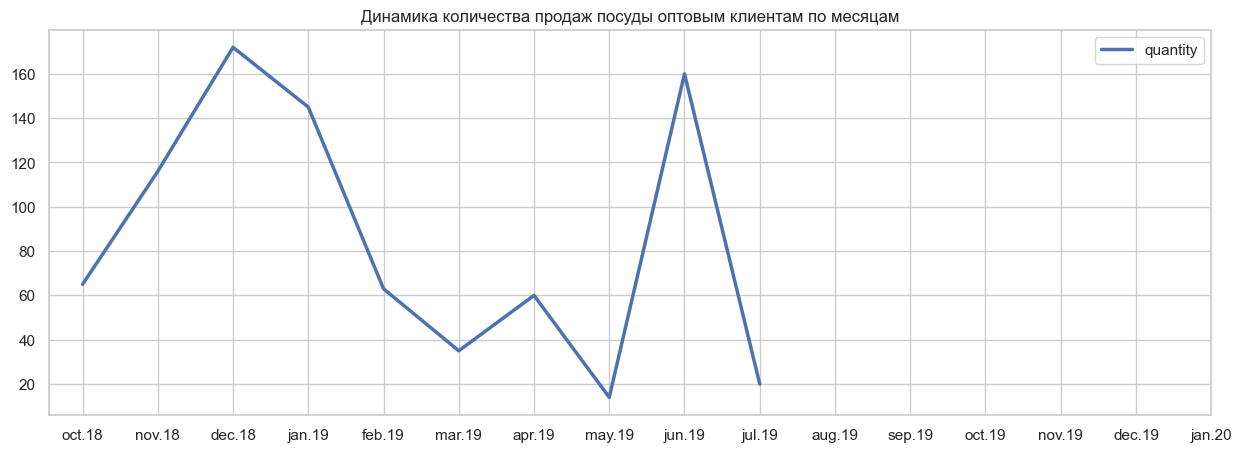

In [94]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dishes_mass.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж посуды оптовым клиентам по месяцам');

**Продажа посуды оптовым клиентам**

Оптовые продажи посуды составляли 23% от всех продаж и резко прекратились в июле 2019 года.

Вопрос о причинах нужно срочно брать в работу, брать менеджера по работе с оптовиками, поднимать базу оптовых клиентов и возвращать сегмент.

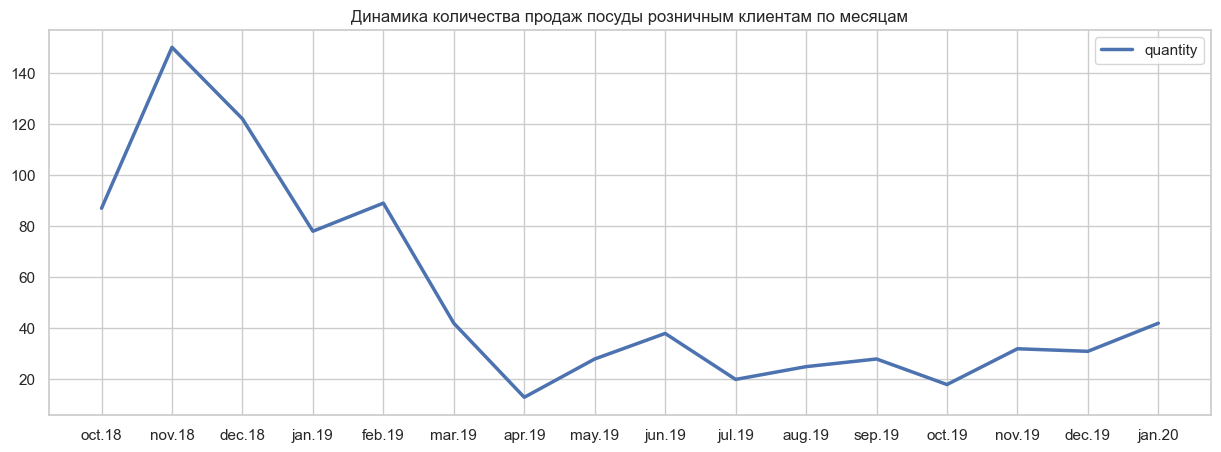

In [95]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dishes_ind.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж посуды розничным клиентам по месяцам');

In [96]:
luminarc = dishes_ind[dishes_ind['product'].str.contains('luminarc', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
luminarc['order_part'] = luminarc['order_id'] / dishes_ind['order_id'].count()
luminarc['cost_part'] = luminarc['cost'] / dishes_ind['cost'].sum()
luminarc['qty_part'] = luminarc['quantity'] / dishes_ind['quantity'].sum()

luminarc



category  order_id  price     cost  quantity  order_part  cost_part  \
0   посуда       109 258.11 50667.50       273        0.24       0.17   

   qty_part  
0      0.32

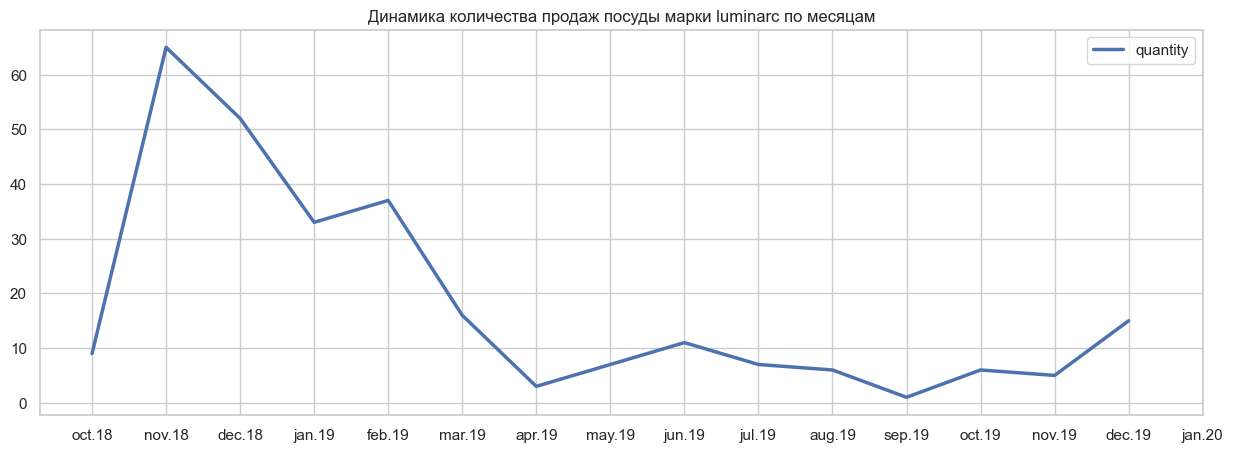

In [97]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dishes_ind[dishes_ind['product'].str.contains('luminarc', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж посуды марки luminarc по месяцам');


In [98]:
attribute = dishes_ind[dishes_ind['product'].str.contains('attribute', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
attribute['order_part'] = attribute['order_id'] / dishes_ind['order_id'].count()
attribute['cost_part'] = attribute['cost'] / dishes_ind['cost'].sum()
attribute['qty_part'] = attribute['quantity'] / dishes_ind['quantity'].sum()

attribute



category  order_id  price     cost  quantity  order_part  cost_part  \
0   посуда        41 332.49 26303.00        93        0.09       0.09   

   qty_part  
0      0.11

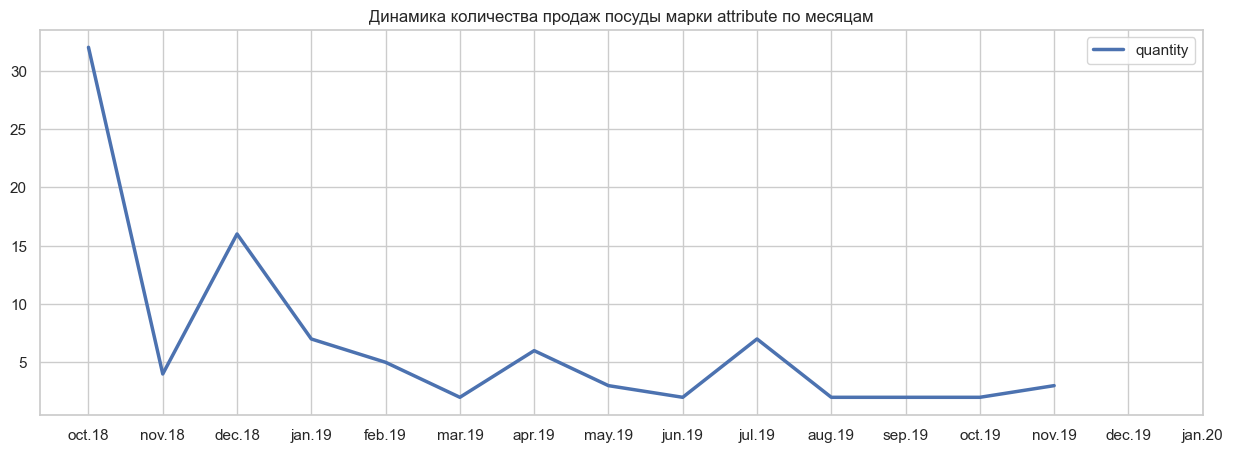

In [99]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dishes_ind[dishes_ind['product'].str.contains('attribute', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж посуды марки attribute по месяцам');


In [100]:
webber = dishes_ind[dishes_ind['product'].str.contains('webber', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
webber['order_part'] = webber['order_id'] / dishes_ind['order_id'].count()
webber['cost_part'] = webber['cost'] / dishes_ind['cost'].sum()
webber['qty_part'] = webber['quantity'] / dishes_ind['quantity'].sum()

webber

category  order_id  price     cost  quantity  order_part  cost_part  \
0   посуда        31 381.21 11944.50        32        0.07       0.04   

   qty_part  
0      0.04

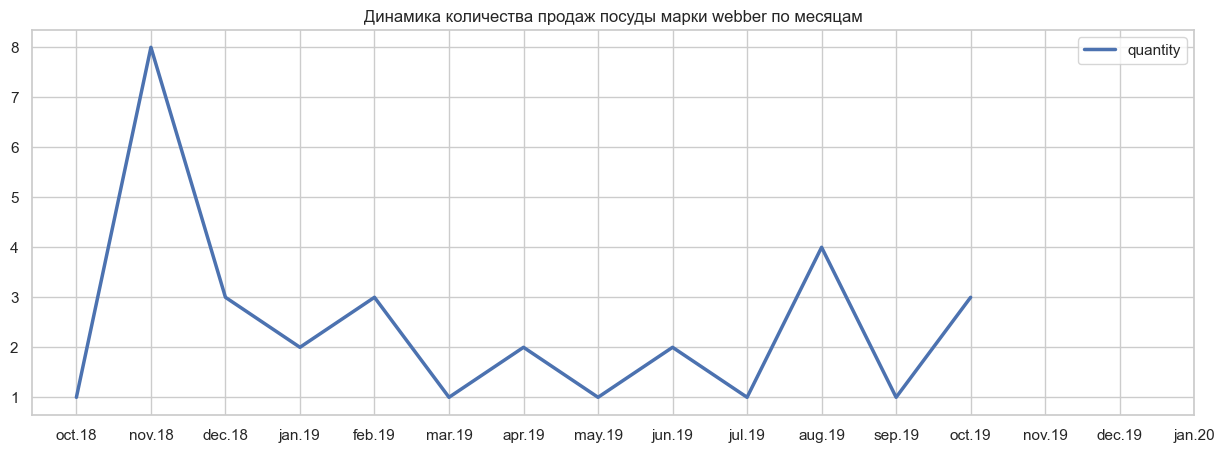

In [101]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dishes_ind[dishes_ind['product'].str.contains('webber', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж посуды марки webber по месяцам');


In [102]:
skat = dishes_ind[dishes_ind['product'].str.contains('скатер', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
skat['order_part'] = skat['order_id'] / dishes_ind['order_id'].count()
skat['cost_part'] = skat['cost'] / dishes_ind['cost'].sum()
skat['qty_part'] = skat['quantity'] / dishes_ind['quantity'].sum()

skat

category  order_id   price     cost  quantity  order_part  cost_part  \
0   посуда        40 1140.50 77563.00        70        0.09       0.25   

   qty_part  
0      0.08

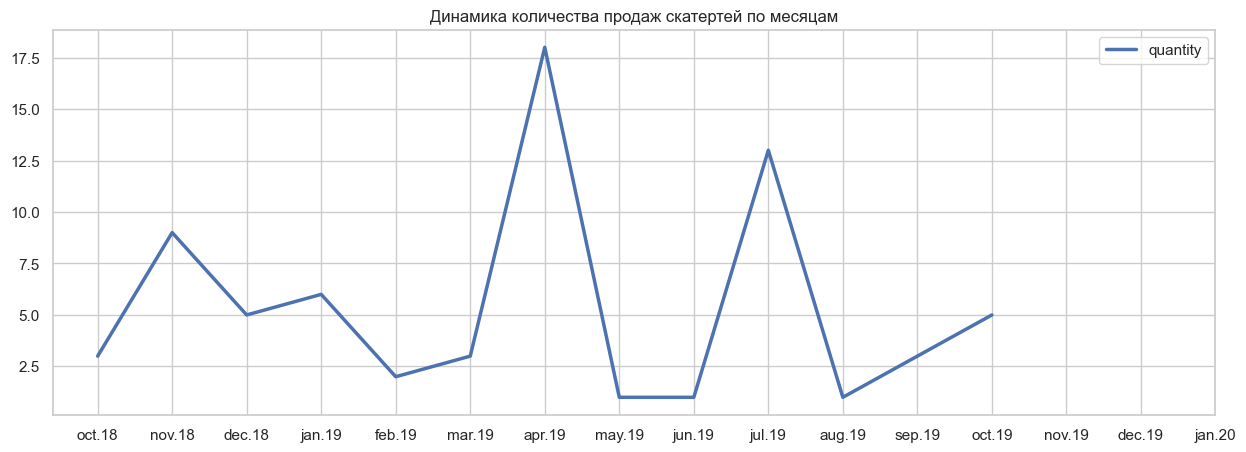

In [103]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dishes_ind[dishes_ind['product'].str.contains('скатер', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж скатертей по месяцам');


**Посуда для розничных клиентов**

Розничная продажа посуды упала почти до нуля в апреле 2019, но начала постепенно восстанавливаться.

Специфика продаж: в комплектности по производителю. 

Посуда марки luminarc присутствует в 24% розничных закзаов, обеспечивает 32% продаж в натуральных единицах и 17% в денежных.

Марка attribute составляет 10% продаж посуды, Webber 4% продаж, но присутствует в 7% заказов.

Скатерти различных производителей присутствуют в 9% заказов но по обороту занимают 25% в доходе.

В продажах онлай и рассылках стоит сделать упор на комплиментарности товаров в коллекции: если клиент купил посуду определенной марки, на сайте и в рассылках ему должны предлагаться другие товары той же марки для увеличения среднего чека. Скатерти могут предлагаться к любым розничным покупкам в категории "посуда".

##### Анализ товаров в категории Тара

In [104]:
pack_total = data[data['category'] == 'тара']
pack_mass = pack_total[pack_total['quantity']>10].sort_values(by='quantity',ascending=False)
pack_ind = pack_total[pack_total['quantity']<=10].sort_values(by='quantity',ascending=False)

pack = pack_ind.groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).reset_index()
pack['order_part'] = pack['order_id'] / data[data['category'] == 'тара']['order_id'].count()
pack['cost_part'] = pack['cost'] / data[data['category'] == 'тара']['cost'].sum()
pack['qty_part'] = pack['quantity'] / data[data['category'] == 'тара']['quantity'].sum()
pack.sort_values(by='quantity',ascending=False).head(25)

product  order_id   price  \
72          сумка-тележка 2-х колесная gimi argo синяя        47 1072.45   
194  тележка багажная delta тбр-20 коричневый с ора...        16  710.88   
195  тележка багажная delta тбр-20 синий грузоподъе...        17  732.57   
7                ведро для ягод полимербыт 2 л 4311001         2   59.00   
81   сумка-тележка 2-х колесная складная gimi flexi...        11 1649.00   
2    вакуумный пакет eva для хранения вещей 50х85 с...         2  121.00   
17   контейнер для мусора доминик curver 25 л сереб...         2  748.00   
185  таз пластмассовый со стиральной доской (иж), 1...        10  339.40   
191  тележка багажная delta dt-22 синий грузоподъем...         8  617.94   
68   сумка для тележки большая комбинированная 45*3...         9  374.00   
193  тележка багажная delta тбр-15 цвет в ассортиме...        10  644.60   
176  таз пластмассовый 30,0 л овальный (белоруссия)...         1  439.00   
54   кофр для хранения hausmann подкроватный 80х40х...         1  285.00   
3    ведро ampari рт9061слроз-10рs 12 л сливочно-ро...         1  135.00   
196  тележка багажная delta тбр-20 черный с серым г...         9  731.00   
71        сумка-тележка 2-х колесная gimi argo красная         9 1087.00   
181  таз пластмассовый 40,0 л пищевой овальный (иж)...         5  404.00   
197  тележка багажная delta тбр-21 черный грузоподъ...         8  750.88   
52         корыто оцинкованное 45 л бесшовное, 1303007         6  749.00   
110     сумка-тележка хозяйственная gimi easy go синяя         7 1649.00   
166  таз пластмассовый 16,0 л пищевой круглый м2507...         2  224.00   
83   сумка-тележка 3-х колесная gimi tris floral синяя         7 2699.00   
79       сумка-тележка 2-х колесная gimi galaxy черная         7 2795.43   
115      сумка-тележка хозяйственная gimi market синяя         7 1874.00   
67   складная картонная коробка для хранения 30х20х...         1  712.00   

        cost  quantity  order_part  cost_part  qty_part  
72  50405.00        47        0.08       0.05      0.05  
194 11749.00        17        0.03       0.01      0.02  
195 12453.75        17        0.03       0.01      0.02  
7     944.00        16        0.00       0.00      0.02  
81  19788.00        12        0.02       0.02      0.01  
2    1331.00        11        0.00       0.00      0.01  
17   8228.00        11        0.00       0.01      0.01  
185  3394.00        10        0.02       0.00      0.01  
191  6142.00        10        0.01       0.01      0.01  
68   3740.00        10        0.02       0.00      0.01  
193  6446.00        10        0.02       0.01      0.01  
176  4390.00        10        0.00       0.00      0.01  
54   2850.00        10        0.00       0.00      0.01  
3    1350.00        10        0.00       0.00      0.01  
196  6579.00         9        0.02       0.01      0.01  
71   9783.00         9        0.02       0.01      0.01  
181  3636.00         9        0.01       0.00      0.01  
197  6007.00         8        0.01       0.01      0.01  
52   5992.00         8        0.01       0.01      0.01  
110 11543.00         7        0.01       0.01      0.01  
166  1568.00         7        0.00       0.00      0.01  
83  18893.00         7        0.01       0.02      0.01  
79  19568.00         7        0.01       0.02      0.01  
115 13118.00         7        0.01       0.01      0.01  
67   4272.00         6        0.00       0.00      0.01

In [105]:
pack_mass['cost'].sum()/ pack_total['cost'].sum()

0.04213835266486994

In [106]:
pack_mass

date                           customer_id  order_id  \
1133 2018-12-21 16:00:00  6987e6d6-a63a-4ce2-a2d0-f424092d235e     69504   
4775 2019-10-23 11:00:00  2fac41bf-e800-4bc3-a4b3-0df800f33e99     73073   
888  2018-11-29 10:00:00  b3ef8c7f-a9c5-4567-888a-6807395128d2     69147   
889  2018-11-29 10:00:00  b3ef8c7f-a9c5-4567-888a-6807395128d2     69147   
890  2018-11-29 10:00:00  b3ef8c7f-a9c5-4567-888a-6807395128d2     69147   
910  2018-11-30 14:00:00  214d85f4-2daf-4029-b8d2-98eb9a715884     69160   
758  2018-11-20 15:00:00  c971fb21-d54c-4134-938f-16b62ee86d3b     69063   

                                                product  quantity  price  \
1133  тележка багажная delta тбр-22 синий грузоподъе...        57 574.00   
4775  ведро резинопластиковое строительное 12,0 л (м...        50  64.00   
888   таз пластмассовый 4,5 л пищевой "космея" (анго...        20  62.00   
889      таз пластмассовый 6,0 л пищевой м2511, 1404015        20  81.00   
890   таз пластмассовый 8,0 л пищевой (минеральные в...        20 115.00   
910   таз пластмассовый 4,5 л пищевой "космея" (анго...        15  62.00   
758   таз пластмассовый 6,0 л пищевой квадратный "тю...        13  92.00   

         cost  year  month  week  hour category  
1133 32718.00  2018     12     4    16     тара  
4775  3200.00  2019     10     2    11     тара  
888   1240.00  2018     11     3    10     тара  
889   1620.00  2018     11     3    10     тара  
890   2300.00  2018     11     3    10     тара  
910    930.00  2018     11     4    14     тара  
758   1196.00  2018     11     1    15     тара

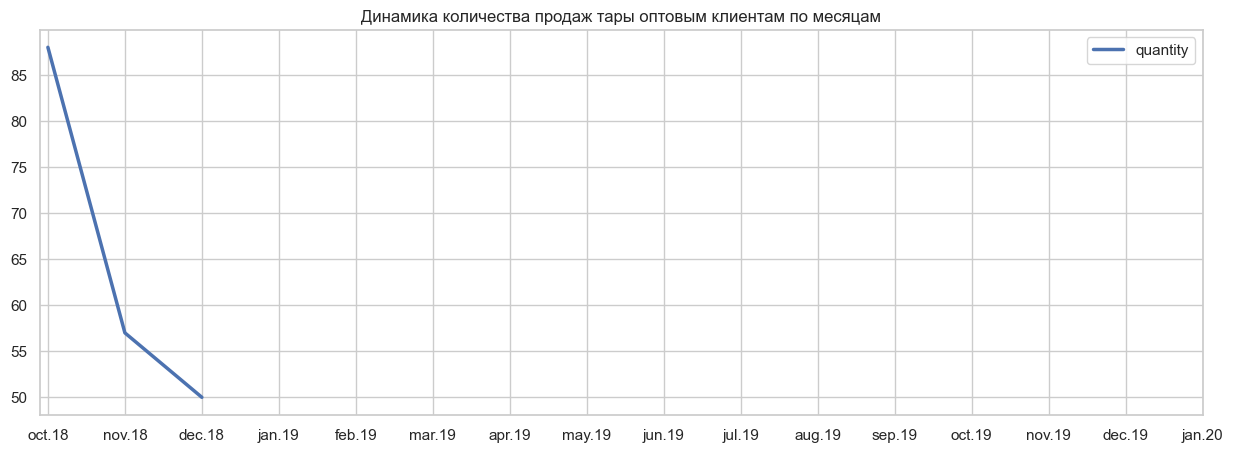

In [107]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=pack_mass.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж тары оптовым клиентам по месяцам');

Оптовые заказы в категории Тара составляют менее 5% оборота. Продажи также исчезли в 2019 году, хотя в октябре 2018 обгоняли розницу.

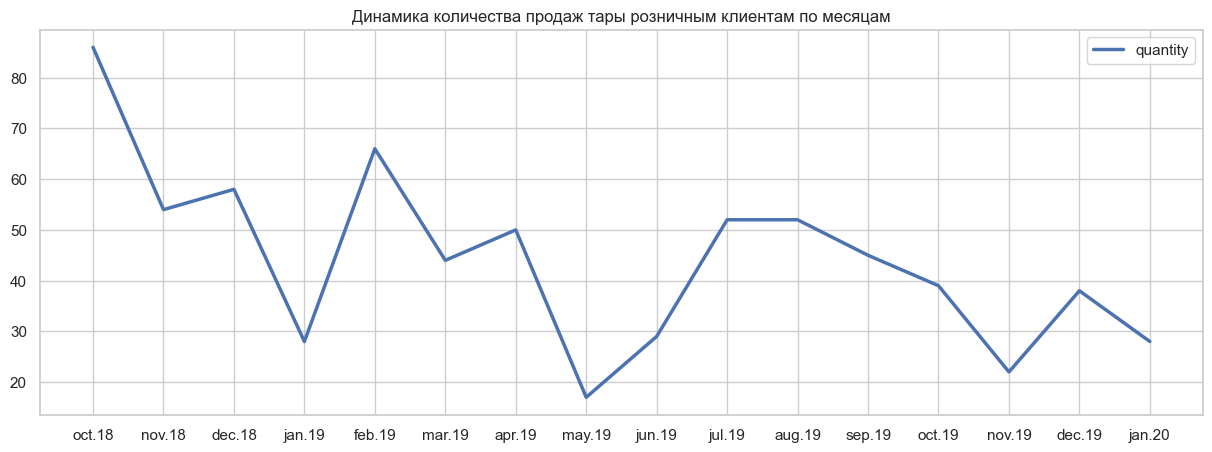

In [108]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=pack_ind.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж тары розничным клиентам по месяцам');

In [109]:
smt = pack_ind[pack_ind['product'].str.contains('сумка-тележка', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
smt['order_part'] = smt['order_id'] / pack_ind['order_id'].count()
smt['cost_part'] = smt['cost'] / pack_ind['cost'].sum()
smt['qty_part'] = smt['quantity'] / pack_ind['quantity'].sum()

smt


category  order_id   price      cost  quantity  order_part  cost_part  \
0     тара       267 2626.34 717300.00       272        0.46       0.73   

   qty_part  
0      0.38

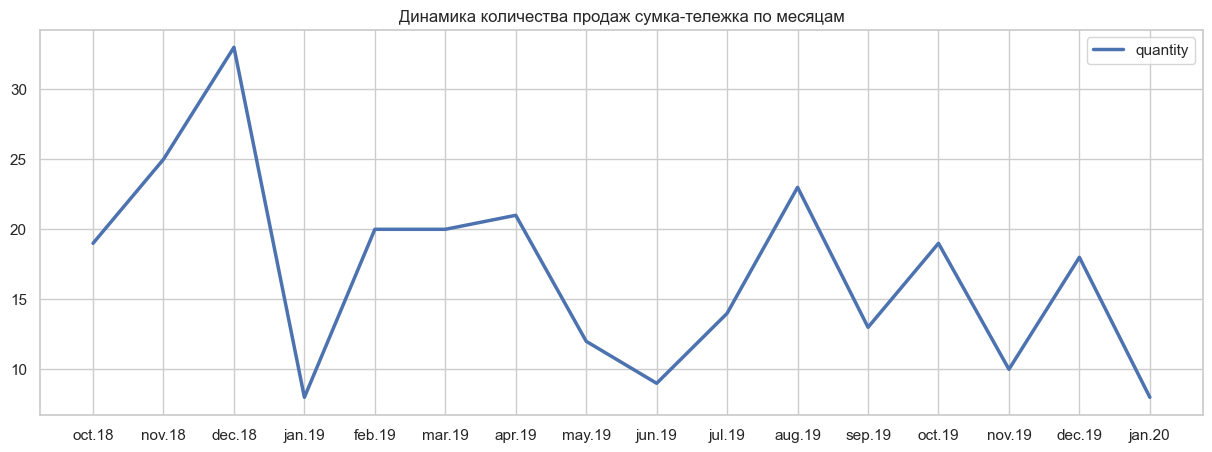

In [110]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=pack_ind[pack_ind['product'].str.contains('сумка-тележка', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж сумка-тележка по месяцам');


In [111]:
tbg = pack_ind[pack_ind['product'].str.contains('тележка багажная', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
tbg['order_part'] = tbg['order_id'] / pack_ind['order_id'].count()
tbg['cost_part'] = tbg['cost'] / pack_ind['cost'].sum()
tbg['qty_part'] = tbg['quantity'] / pack_ind['quantity'].sum()

tbg


category  order_id  price     cost  quantity  order_part  cost_part  \
0     тара        88 735.93 66335.25        91        0.15       0.07   

   qty_part  
0      0.13

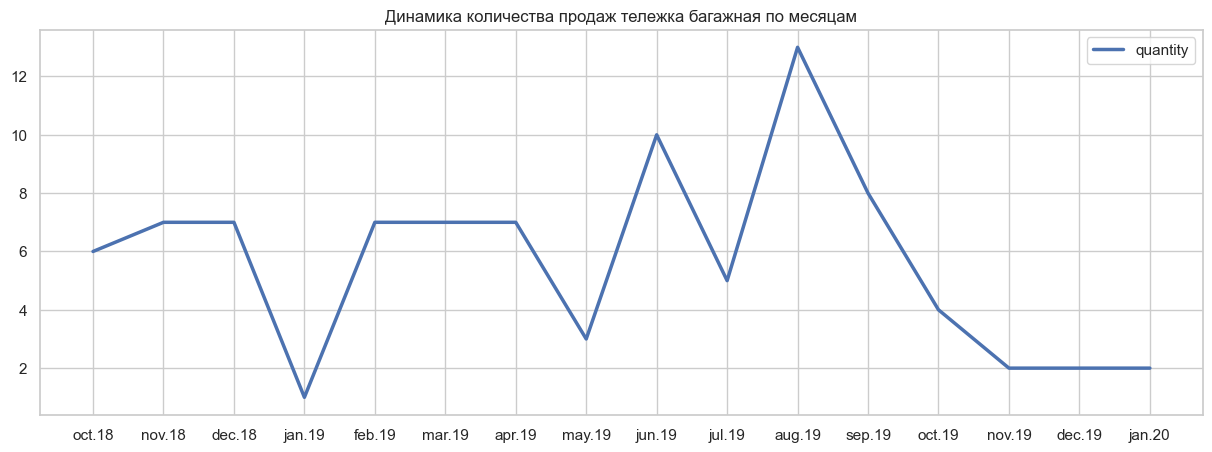

In [112]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=pack_ind[pack_ind['product'].str.contains('тележка багажная', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж тележка багажная по месяцам');


In [113]:
taz = pack_ind[pack_ind['product'].str.contains('таз', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
taz['order_part'] = taz['order_id'] / pack_ind['order_id'].count()
taz['cost_part'] = taz['cost'] / pack_ind['cost'].sum()
taz['qty_part'] = taz['quantity'] / pack_ind['quantity'].sum()

taz


category  order_id  price     cost  quantity  order_part  cost_part  \
0     тара        73 277.05 29112.00       100        0.13       0.03   

   qty_part  
0      0.14

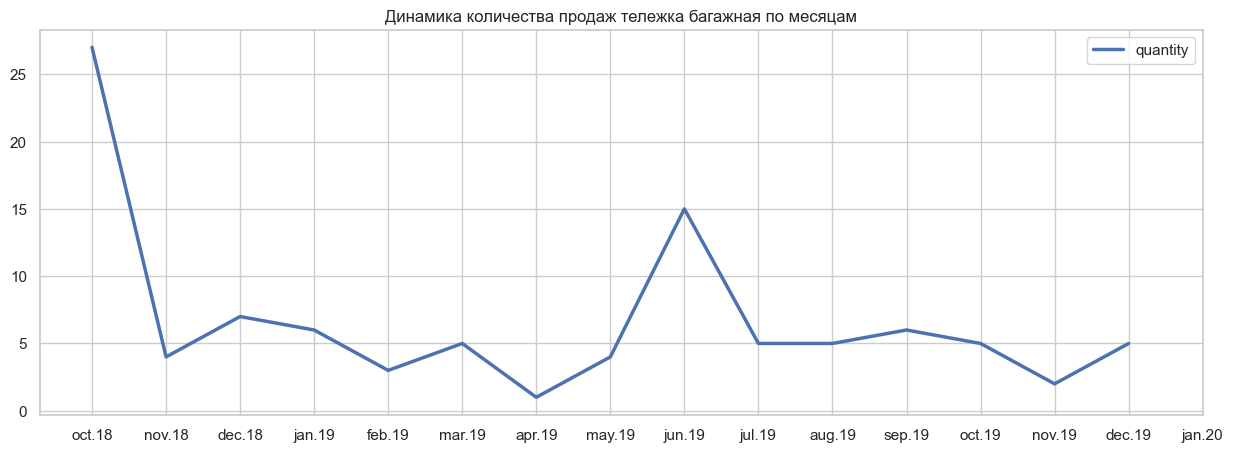

In [114]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=pack_ind[pack_ind['product'].str.contains('таз', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж тележка багажная по месяцам');


**Продажи товаров в категории Тара**

Хит продаж Сумка-тележка, приносит 73% дохода по категории, была в 46% заказов, 38% от товарооборота. Стоимость 2600.

Багажные тележки при объеме продаж 14% от всех позиций дают доход всего в 7% от дохода категории, пластиковые тазы 3% дохода пр  14% продаж от количества.

##### Анализ товаров в категории Декор

In [115]:
decor_total = data[data['category'] == 'декор']
decor_mass = decor_total[decor_total['quantity']>=20].sort_values(by='quantity',ascending=False)
decor_ind = decor_total[decor_total['quantity']<20].sort_values(by='quantity',ascending=False)

decor = decor_ind.groupby('product').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).reset_index()
decor['order_part'] = decor['order_id'] / data[data['category'] == 'декор']['order_id'].count()
decor['cost_part'] = decor['cost'] / data[data['category'] == 'декор']['cost'].sum()
decor['qty_part'] = decor['quantity'] / data[data['category'] == 'декор']['quantity'].sum()
decor.sort_values(by='quantity',ascending=False).head(25)

product  order_id  price  \
153  цветок искусственный гвоздика пластиковая один...         6  21.17   
157                  цветок искусственный крокус 20 см         7  21.43   
86         муляж красное яблоко мини полиуретан d-6 см         6  21.33   
119        муляж яблоко, оранжевый, 8,5 см, полиуретан         7  57.52   
107               муляж персики мини полиуретан d-6 см         8  21.75   
56                                муляж баклажан 18 см        10  59.00   
80                                   муляж желудь 2 шт         6  22.00   
85         муляж красное яблоко мини полиуретан d-5 см         2  22.00   
11   искусственная композиция из цветов пластиковая...         9  56.41   
5    декоративная композиция искуственных цветов бу...         4 109.00   
95                                 муляж морковь 16 см         7  59.00   
29     искусственный цветок крокус пластиковый розовый         4  29.00   
154  цветок искусственный гвоздика тканевая красная...         2  22.00   
111                                 муляж тыквы d-8 см         4  51.25   
152  цветок искусственный василек 3 цветка 55 см пл...         3  42.00   
82              муляж зеленое яблоко полиуретан d-6 см         8  22.00   
31   искусственный цветок ландыш пластиковый малый ...         3  21.33   
49   искусственный цветок тюльпан пластиковый откры...         2  20.00   
32   искусственный цветок лилейник пластиковый свет...         1  49.00   
40   искусственный цветок роза закрытая малая пласт...         1  20.00   
166  цветок искусственный тюльпан 40 см пластик цве...         1  20.00   
164  цветок искусственный роза с открытим бутоном ц...         1  27.00   
128  подарочный набор на 8 марта тюльпаны розовые 5...         2 157.00   
58                 муляж банан желтый 21 см полиуретан         3  59.00   
121  мыло ручной работы сувенир подарок на 8 марта ...         3  68.00   

       cost  quantity  order_part  cost_part  qty_part  
153 1068.00        51        0.02       0.01      0.02  
157  855.00        41        0.02       0.00      0.02  
86   672.00        33        0.02       0.00      0.01  
119 1673.67        29        0.02       0.01      0.01  
107  586.00        28        0.02       0.00      0.01  
56  1357.00        23        0.03       0.01      0.01  
80   506.00        23        0.02       0.00      0.01  
85   462.00        21        0.01       0.00      0.01  
11  1181.67        21        0.02       0.01      0.01  
5   2026.00        19        0.01       0.01      0.01  
95  1062.00        18        0.02       0.01      0.01  
29   522.00        18        0.01       0.00      0.01  
154  396.00        18        0.01       0.00      0.01  
111  854.00        17        0.01       0.00      0.01  
152  686.00        17        0.01       0.00      0.01  
82   352.00        16        0.02       0.00      0.01  
31   328.00        16        0.01       0.00      0.01  
49   300.00        15        0.01       0.00      0.01  
32   735.00        15        0.00       0.00      0.01  
40   300.00        15        0.00       0.00      0.01  
166  300.00        15        0.00       0.00      0.01  
164  405.00        15        0.00       0.00      0.01  
128 2198.00        14        0.01       0.01      0.01  
58   826.00        14        0.01       0.00      0.01  
121  884.00        13        0.01       0.01      0.01

In [116]:
decor_mass['cost'].sum()/ decor_total['cost'].sum()

0.38994398274010506

In [117]:
decor_mass

date                           customer_id  order_id  \
3358 2019-05-20 21:00:00  5d189e88-d4d6-4eac-ab43-fa65a3c4d106     71478   
484  2018-11-01 08:00:00  aa42dc38-780f-4b50-9a65-83b6fa64e766     68815   
502  2018-11-02 11:00:00  0c5aaa88-e346-4f87-8f7a-ad8cbc04e965     68831   
4679 2019-10-10 14:00:00  bd5328dc-1e15-4757-9fe2-f56e4f8eaa7c     72920   
4769 2019-10-22 16:00:00  511115b7-e981-4069-9e0e-88a3551341a6     73063   
1615 2019-02-18 16:00:00  74b08ab4-16e9-4d83-9c31-acfc9d229bc5     70328   
1744 2019-02-27 09:00:00  377c8a20-a3e0-4945-9fd8-a1f4ada5d8b0     70482   
1145 2018-12-23 11:00:00  24c0b355-53e3-428a-b299-e1627b1cdd5c     69524   
4623 2019-10-03 14:00:00  d8465f63-35db-4809-aff3-a8f7ebfc257f     72845   
2153 2019-03-28 20:00:00  bba9b7bf-09a6-4f16-81c3-2b83dcebbc0a     70915   
255  2018-10-16 22:00:00  42c5db22-6046-455b-a728-ff163a1b7808     68667   
4758 2019-10-20 21:00:00  6583407e-7d0d-4ece-93f8-6f7cb64f9926     73041   
2004 2019-03-17 20:00:00  977bba90-df53-4513-b5db-30d6ea1fbca1     70769   
2094 2019-03-25 16:00:00  22749361-d927-47e6-a6ad-aee8becdb094     70876   
2161 2019-03-29 15:00:00  37a2bf50-a4e4-491c-a1ba-e5f70e9caa05     70921   
2901 2019-05-05 08:00:00  c8ae456d-90aa-4498-8457-0d2015202f8a     71351   
3816 2019-06-21 21:00:00  0e117bc7-82df-474f-a5db-0c50f16701f1     71770   
160  2018-10-10 14:00:00  3e2c8193-3fc0-4607-a59f-bcdf169ce351     68599   
4782 2019-10-25 13:00:00  14cc96d3-7d14-4e84-9c15-76e57b642c72     73092   
2591 2019-04-23 20:00:00  62f1e9ea-c828-4287-b234-86f56491201a     71255   
161  2018-10-10 14:00:00  3e2c8193-3fc0-4607-a59f-bcdf169ce351     68599   
1763 2019-02-28 13:00:00  f93a07fa-9ccc-434a-b4ae-8481c0c2ddfa     70508   
1443 2019-02-04 16:00:00  3bec2677-1f86-4f83-8076-c7db726032d0     70095   
4233 2019-08-07 13:00:00  da931437-d623-480b-b2ce-4d6ec1a395f6     72230   
1636 2019-02-20 11:00:00  d485640b-2102-4622-bbe0-94151f534609     70363   
617  2018-11-09 10:00:00  6c85b1c8-f34c-4390-92e8-77554ee4f0b7     68926   
2070 2019-03-24 14:00:00  62c160e8-8ce7-4dd2-84b7-f74bf90b1e40     70857   

                                                product  quantity  price  \
3358                          муляж яблоко 9 см красное       300  51.00   
484                           муляж яблоко 9 см красное       170  51.00   
502                           муляж яблоко 9 см красное       140  59.00   
4679  искусственный цветок подснежник садовый пласти...        65  32.00   
4769               муляж яблоко зеленый 9 см полиуретан        50  51.00   
1615                 муляж лимон желтый 9 см полиуретан        50  51.00   
1744                муляж банан желтый 21 см полиуретан        50  51.00   
1145               муляж яблоко зеленый 9 см полиуретан        40  59.00   
4623               муляж яблоко зеленый 9 см полиуретан        40  59.00   
2153  цветок искусственный гвоздика тканевая красная...        31  20.00   
255         муляж красное яблоко мини полиуретан d-6 см        30  19.00   
4758  искусственный цветок роза закрытая малая пласт...        30  19.00   
2004  искусственный цветок подснежник пластиковый белый        30  32.00   
2094                 муляж лимон желтый 9 см полиуретан        30  59.00   
2161               муляж яблоко зеленый 9 см полиуретан        30  59.00   
2901  цветок искусственный гвоздика пластиковая один...        26  20.00   
3816                муляж банан желтый 21 см полиуретан        25  51.00   
160                муляж яблоко зеленый 9 см полиуретан        25  51.00   
4782  цветок искусственный нарцисс одиночный в ассор...        25  20.00   
2591      муляж оранжевое яблоко мини полиуретан d-5 см        25  19.00   
161                      муляж апельсин 8 см полиуретан        25  51.00   
1763  декоративная композиция искуственных цветов бу...        25 196.00   
1443        муляж яблоко, оранжевый, 8,5 см, полиуретан        25  51.00   
4233      муляж оранжевое яблоко мини полиуретан d-5 см        20  

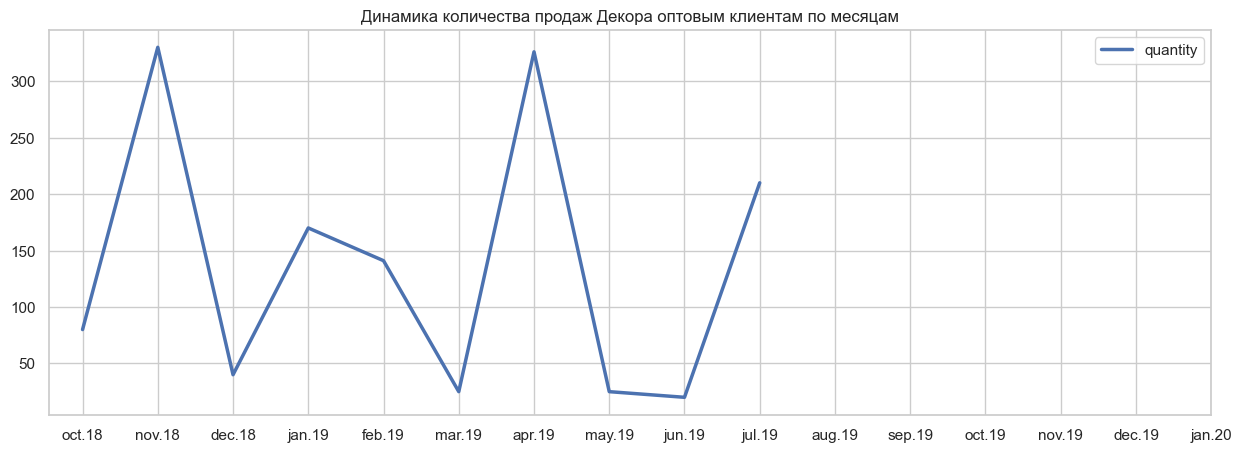

In [118]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=decor_mass.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Декора оптовым клиентам по месяцам');

**Продажи декора оптовым клиентам**

В категории Декор до 40% дохода с продаж приходится на оптовых клиентов.
Динамика оптовых продаж нестабильная, колеблется от 20 до 350 единиц в месяц.

С июля 2019 также не было крупных заказов декора свыше 20 единиц.

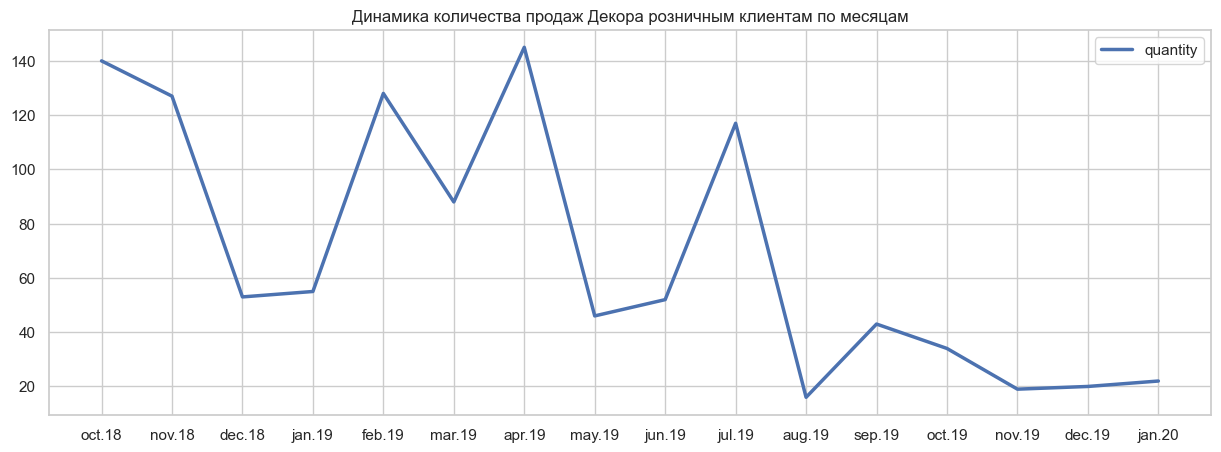

In [119]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=decor_ind.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Декора розничным клиентам по месяцам');

In [120]:
dd = decor_ind[decor_ind['product'].str.contains('кашпо', case=False, regex=True)].groupby('category').agg({'order_id':'count','price':'mean','cost':'sum','quantity':'sum'}).sort_values(by='quantity',ascending=False).reset_index()
dd['order_part'] = dd['order_id'] / decor_ind['order_id'].count()
dd['cost_part'] = dd['cost'] / decor_ind['cost'].sum()
dd['qty_part'] = dd['quantity'] / decor_ind['quantity'].sum()

dd


category  order_id  price     cost  quantity  order_part  cost_part  \
0    декор        35 746.91 36536.00        55        0.10       0.35   

   qty_part  
0      0.05

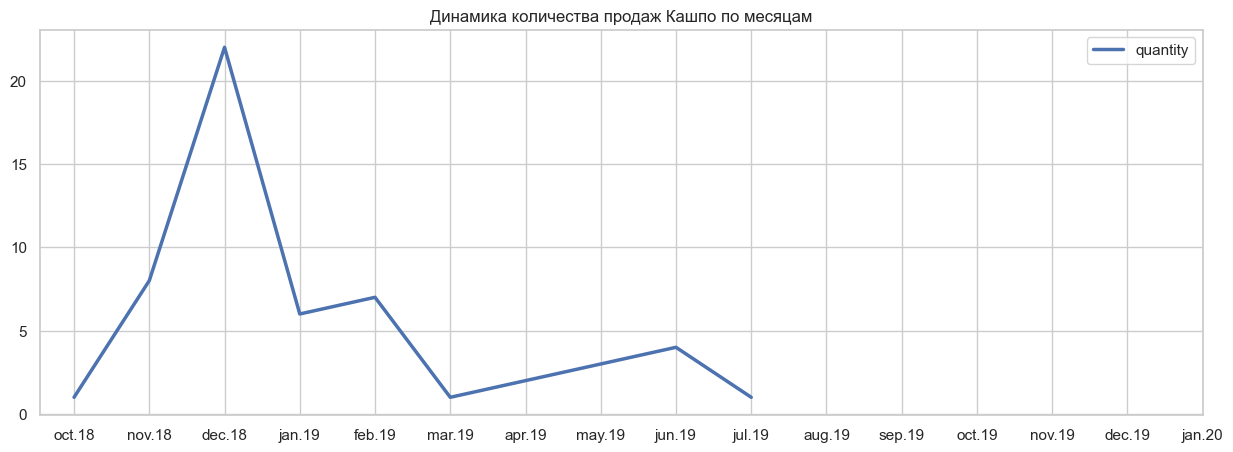

In [121]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=decor_ind[decor_ind['product'].str.contains('кашпо', case=False, regex=True)].pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества продаж Кашпо по месяцам');


In [122]:
top_words(decor_ind['product']).head(50)

index  count
0              см    189
1           муляж    169
2   искусственный     94
3          цветок     93
4      полиуретан     77
5               в     55
6     пластиковая     52
7            мини     45
8             см,     36
9           кашпо     35
10              4     32
11         яблоко     29
12            d-6     29
13          fancy     28
14              л     27
15      подвесное     27
16          объем     27
17    полиуретан,     26
18   ассортименте     25
19             шт     24
20    пластиковый     23
21              с     22
22     композиция     21
23         цветов     21
24        fair/ff     21
25             на     19
26              9     19
27          букет     19
28        розовая     18
29  искусственная     18
30             10     17
31           цвет     17
32              2     17
33              8     17
34              3     16
35             из     16
36        пластик     15
37         желтый     14
38          перец     14
39        ромашка     13
40   декоративная     13
41           чили     13
42        лиловая     12
43     оранжевый,     12
44        зеленое     12
45         крокус     11
46       баклажан     11
47        красное     11
48        красный     11
49             50     10

**Декор для розничных покупателей**

Наиболее разрозненная товарная категория, в которой трудно вычленить лидирующие позиции или лидирующие марки товаров. Множество искуственных цветов и муляже с небольшими объемами продаж.

Отдельно можно выделить спорный товар декоративных кашпо с живыми цветами, которые помимо Декора могут быть отнесены как к рассаде, так и к товарам для дома. Это наиболее дорогостоящий товар в категории, продажи которого обеспечивали 35% дохода при 5% продаж в общем количестве. 

Неплохой вариант для увеличения среднего чека розничных покупателей в товаров для дома и рассады.

#### Общий вывод по товарным категориям

В категории рассада преобладают розничные клиенты с малым количеством товаров в заказе.

Декоративные растения пользуются популярностью весной, плодовые обычно покупают на рассаду за год до начала сезона, эта категория поможет сгладить ярко выраженную сезонность спроса, однако в ней могут наблюдаться проблемы.

Данные продаж товаров по категории Рассада говорят о возможных проблемах с товарным ассортиментом. Спрос на многие плодовые растения резко снизился в 2019 году. 

*Рекомендуется проверить ассортимент рассады и составить конкуретные карты по самым ходовым позициям.*

Возможные сценарии рассылок: весной с марта по май по декоративным растениям, зимой, с января по март по плодовым.

В остальных категорих заказы можно разбить на розничные и мелкооптовые.

Мелкооптовые заказы дают до 40% дохода в Бытовых товарах, посуде, таре, декоре. Однако по всем оптовым заказам наблюдается резкий спад во второй половине 2019 года.

**Работа и коммуникация с оптовыми и розничными сегментами клиентов должна строится по-разному.**

Оптовые заказчики обычно покупают товары для нужд бизнеса, по имеющимся данным сложно спрогнозировать и охарактеризовать их потребности, однако по динамике продаж четко видно отсутствие продаж оптовикам с ноября 2019 года.

Работа с оптовиками требует индивидуального подхода, их можно включать в обычные рассылки, однако также им необходимо делать индивидуальные предложения, оптимальнее всего назначить отдельного менеджера по работе с оптовыми клиентами, предложить им выгодные условия и сроки поставки.

*Вопрос о причинах ухода оптовиков нужно прорабатывать отдельно, налаживать прямое взаимодействие с оптовиками, поднимать базу оптовых клиентов и возвращать сегмент*

**Рассылки по бытовым товарам**

Большую часть продаж бытовых товаров розничным покупателям составляют Сушилки для белья, гладильные доски, коврики и шторы для ванных комнат.
Все эти товары комплиментарные, можно увеличить продажи как через интернет магазин, баннерами "не забудьте также купить..." так и по рассылкам, присылая подборку других категорий, если клиент купил один из товаров категории

**Рассылки по посуде**

В продажах онлайн и рассылках стоит сделать упор на комплиментарности товаров в коллекции: если клиент купил посуду определенной марки, на сайте и в рассылках ему должны предлагаться другие товары той же марки для увеличения среднего чека. Скатерти могут предлагаться к любым розничным покупкам в категории "посуда".

**Рассылки по категории тара**

Хит продаж Сумка-тележка, приносит 73% дохода по категории, была в 46% заказов, 38% от товарооборота. Стоимость 2600.

Данный товар можно предлагать для увеличения среднего чека для покупателей в категории Рассада

**Рассылки в категории декор**

Отдельно можно выделить декоративные кашпо с живыми цветами. Это наиболее дорогостоящий товар в категории, продажи которого обеспечивали 35% дохода при 5% продаж в общем количестве.

Неплохой вариант для увеличения среднего чека розничных покупателей в товаров для дома и рассады.

### Компонуем заказы, создаем сводную таблицу:
- id заказа,
- время заказа, 
- id покупателя, 
- количество единиц заказа, 
- сумма заказа
- если целесообрано можно добавить категорию товаров в заказе (заказ в одной категории или нескольких). 

In [123]:
data.head(3)


date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price   cost  \
0    комнатное растение в горшке алое вера, d12, h30         1 142.00 142.00   
1  комнатное растение в горшке кофе арабика, d12,...         1 194.00 194.00   
2                        радермахера d-12 см h-20 см         1 112.00 112.00   

   year  month  week  hour category  
0  2018     10     0     0  рассада  
1  2018     10     0     0  рассада  
2  2018     10     0     0  рассада

In [124]:
orders = data.sort_values(by=['order_id', 'category']).groupby('order_id').agg(
            {
                
                'customer_id': 'first',
                'date': 'first',
                'quantity': 'sum',
                'cost': 'sum',
                'category': 'sum',
            }
        ).reset_index()
        #.rename(columns={'session_start': 'first_ts'})
        #.reset_index()

orders

order_id                           customer_id                date  \
0        12624  d17861fa-db5f-4de4-93fd-dc5e60d24d3e 2019-06-02 20:00:00   
1        13547  b80e4826-7218-4bf9-ac08-eb2c81ab3f62 2018-10-05 00:00:00   
2        14480  f08d9018-438e-4e96-b519-f74c0302a433 2018-10-02 11:00:00   
3        14481  49b9c587-c19e-4481-bace-967aeac357fa 2018-10-02 17:00:00   
4        14482  43993fd2-20c9-44f7-8634-cf0aee26df4f 2018-10-07 12:00:00   
...        ...                                   ...                 ...   
3516    112722  a479e857-7300-43d4-833c-55dc5bb65c83 2019-12-11 23:00:00   
3517    112732  db5c1840-bdb7-4f2f-8239-2ab779fd9706 2019-11-19 19:00:00   
3518    112767  493d53bf-ff1f-4487-a6e7-b1bedddb73fd 2019-12-23 12:00:00   
3519    112779  66c57efd-4dd1-49c9-b921-987ab6e161fa 2020-01-11 14:00:00   
3520    112789  65ed0726-5565-4c0e-905c-f9e9bd9f7642 2019-12-26 22:00:00   

      quantity    cost                      category  
0            2  375.00                бытовыебытовые  
1            3  684.00         рассадарассадарассада  
2            3  359.00         рассадарассадарассада  
3            4  600.00  рассадарассадарассадарассада  
4            2  376.00                рассадарассада  
...        ...     ...                           ...  
3516         1  450.00                         декор  
3517         1   90.00                       рассада  
3518         1   38.00                       рассада  
3519         1  172.00                       рассада  
3520         2 2698.00                       бытовые  

[3521 rows x 6 columns]

In [125]:
for _ in range(15):
    orders['category'] = orders['category'].replace('рассадарассада','рассада',regex=True)
    orders['category'] = orders['category'].replace('бытовыебытовые','бытовые',regex=True)
    orders['category'] = orders['category'].replace('декордекор','декор',regex=True)
    orders['category'] = orders['category'].replace('посудапосуда','посуда',regex=True)
    orders['category'] = orders['category'].replace('таратара','тара',regex=True)

In [126]:
orders['category'].value_counts(normalize=True)

category
бытовые                     0.35
рассада                     0.29
тара                        0.15
посуда                      0.11
декор                       0.08
декоррассада                0.00
бытовыетара                 0.00
бытовыерассада              0.00
бытовыепосуда               0.00
бытовыепосударассада        0.00
бытовыепосудатара           0.00
бытовыедекоррассада         0.00
декорпосуда                 0.00
бытовыедекорпосударассада   0.00
рассадатара                 0.00
бытовыедекоррассадатара     0.00
посударассада               0.00
декортара                   0.00
бытовыедекор                0.00
бытовыедекорпосуда          0.00
Name: proportion, dtype: float64

Менее 1% заказов содержат товары нескольких категорий. Указывать стоимость или долю каждой товарной категории в заказе нецелесообразно.

**Достаточно указать в характеристиках товара 1 категорию, на случай если категорий несколько, отсортируем товары по стоимости и возьмем самый дорогой**

In [127]:
orders = data.sort_values(by=['order_id', 'price']).groupby('order_id').agg(
            {
                
                'customer_id': 'first',
                'date': 'first',
                'month': 'first',
                'year': 'first',
                'week': 'first',
                'hour': 'first',
                'quantity': 'sum',
                'cost': 'sum',
                'category': 'last',
            }
        ).reset_index()
        #.rename(columns={'session_start': 'first_ts'})
        #.reset_index()

orders

order_id                           customer_id                date  \
0        12624  d17861fa-db5f-4de4-93fd-dc5e60d24d3e 2019-06-02 20:00:00   
1        13547  b80e4826-7218-4bf9-ac08-eb2c81ab3f62 2018-10-05 00:00:00   
2        14480  f08d9018-438e-4e96-b519-f74c0302a433 2018-10-02 11:00:00   
3        14481  49b9c587-c19e-4481-bace-967aeac357fa 2018-10-02 17:00:00   
4        14482  43993fd2-20c9-44f7-8634-cf0aee26df4f 2018-10-07 12:00:00   
...        ...                                   ...                 ...   
3516    112722  a479e857-7300-43d4-833c-55dc5bb65c83 2019-12-11 23:00:00   
3517    112732  db5c1840-bdb7-4f2f-8239-2ab779fd9706 2019-11-19 19:00:00   
3518    112767  493d53bf-ff1f-4487-a6e7-b1bedddb73fd 2019-12-23 12:00:00   
3519    112779  66c57efd-4dd1-49c9-b921-987ab6e161fa 2020-01-11 14:00:00   
3520    112789  65ed0726-5565-4c0e-905c-f9e9bd9f7642 2019-12-26 22:00:00   

      month  year  week  hour  quantity    cost category  
0         6  2019     6    20         2  375.00  бытовые  
1        10  2018     4     0         3  684.00  рассада  
2        10  2018     1    11         3  359.00  рассада  
3        10  2018     1    17         4  600.00  рассада  
4        10  2018     6    12         2  376.00  рассада  
...     ...   ...   ...   ...       ...     ...      ...  
3516     12  2019     2    23         1  450.00    декор  
3517     11  2019     1    19         1   90.00  рассада  
3518     12  2019     0    12         1   38.00  рассада  
3519      1  2020     5    14         1  172.00  рассада  
3520     12  2019     3    22         2 2698.00  бытовые  

[3521 rows x 10 columns]

In [128]:
orders['category'].value_counts(normalize=True)

category
бытовые   0.36
рассада   0.29
тара      0.16
посуда    0.12
декор     0.08
Name: proportion, dtype: float64

In [129]:
orders.pivot_table(index='category', values=('cost','quantity'), aggfunc=('median','mean'))

cost         quantity       
            mean  median     mean median
category                                
бытовые  1974.24  824.00     4.29   1.00
декор     639.44  200.00     8.97   2.00
посуда    968.98  518.00     4.08   1.00
рассада   527.93  222.00     3.80   1.00
тара     1856.34 1087.00     1.65   1.00

#### Анализ заказов по чеку заказа

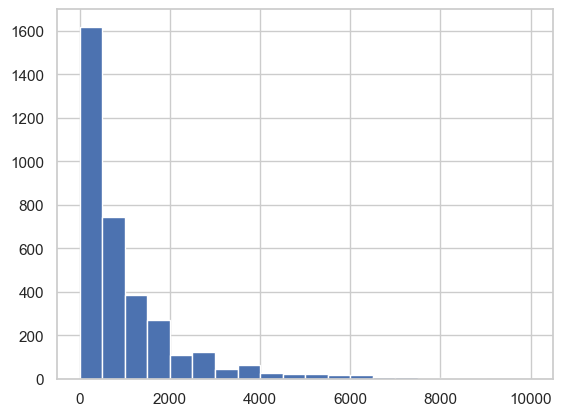

In [130]:
plt.hist(orders['cost'],bins=20,range=(0,10000));

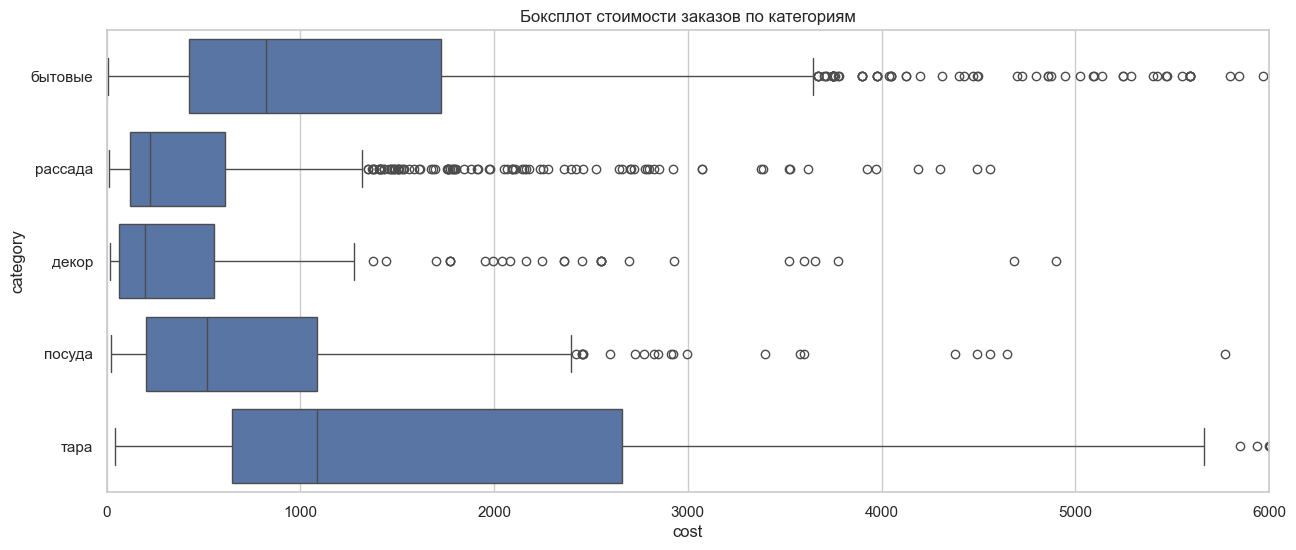

In [131]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=orders, x='cost', y='category')
plt.xlim(0,6000)
plt.title('Боксплот стоимости заказов по категориям');

Стоимость товаров в заказе может достигать 670 000 рублей, однако чаще всего она в пределах 6000 рублей.


Самые дорогие заказы со средним чеком 1100 рублей в категории Тара.

Бытовые товары обычно заказывают со средним чеком 820 рублей, однако в этой катагории самый длинный хвост выбросов.

Посуда на 3 месте, средний чек 520 рублей.

Самые бюджетные категории это Рассада и Декор со средним чеком 200-220 рублей

#### Анализ заказов по среднему количеству товаров в заказе

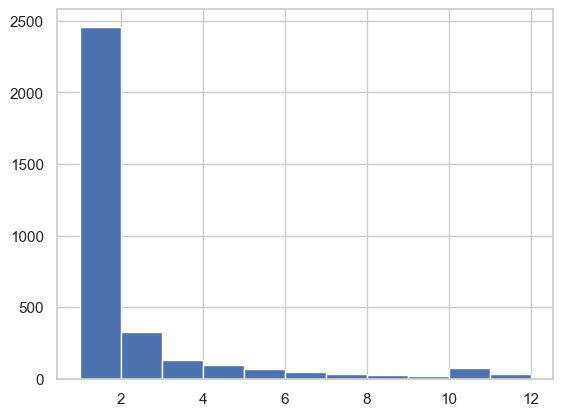

In [132]:
plt.hist(orders['quantity'],bins=11,range=(1,12));

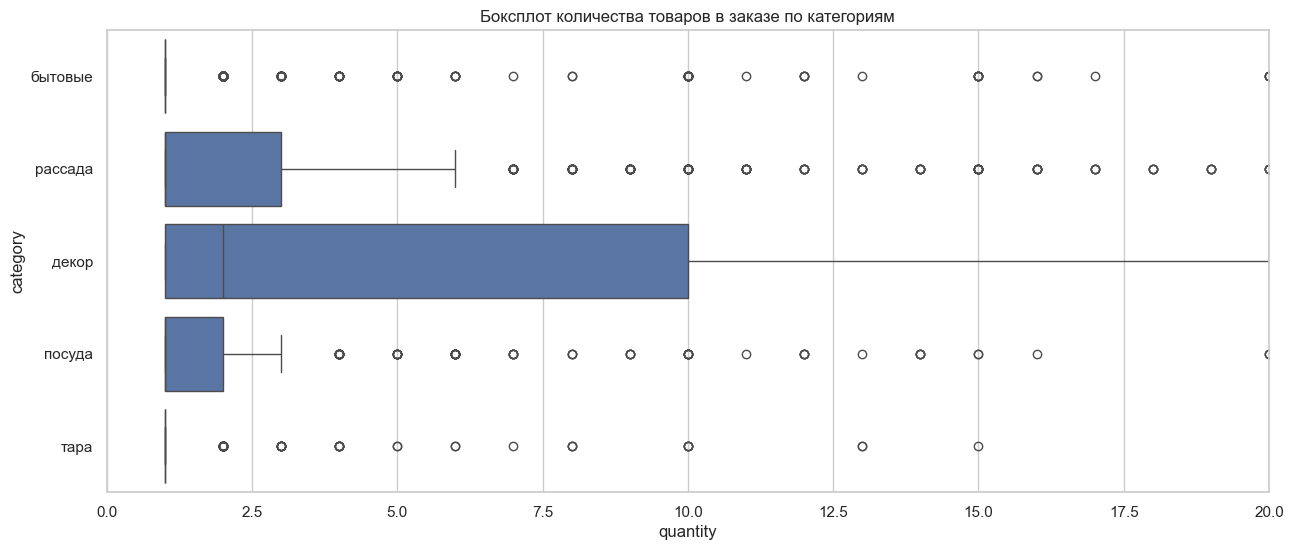

In [133]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=orders, x='quantity', y='category')
plt.xlim(0,20)
plt.title('Боксплот количества товаров в заказе по категориям');

Количестов товаров в 1 заказе для бытовых товаров может доходить до 1000 единиц, однако наиболее часто бытовые товары заказывают поштучно, рассаду, декор и посуду партиями по несколько позиций в заказе.

70% заказов содержит всего 1 товар.

### Исключаем аномально большие заказы

Исключим заказы с количеством товаров и стоимостью заказа свыше 99 процентиля.

In [134]:
print(np.percentile(orders['cost'], [99.5, 99.75, 99.9])) 

[10211.4  15422.4  33179.76]


In [135]:
orders.sort_values(by='cost', ascending=False).head(10)

order_id                           customer_id                date  \
2045     71743  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6 2019-06-18 15:00:00   
2008     71668  146cd9bf-a95c-4afb-915b-5f6684b17444 2019-06-11 07:00:00   
1065     69830  58a4c3cc-504f-43ea-a74a-bae19e665552 2019-01-15 13:00:00   
722      69156  8fba3604-ef57-4b9f-b2fe-3402fa8825c8 2018-11-29 17:00:00   
917      69504  6987e6d6-a63a-4ce2-a2d0-f424092d235e 2018-12-21 16:00:00   
569      68878  1b2764ad-9151-4051-a46a-9b01b62e6335 2018-11-06 12:00:00   
502      68760  9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f 2018-10-26 13:00:00   
1180     70080  909564b8-3a5c-4d3e-8310-5ba1c837bbd7 2019-02-04 06:00:00   
1786     71206  498f12a4-6a62-4725-8516-cf5dc9ab8a3a 2019-04-19 19:00:00   
3194    107812  f279d50f-a508-40b4-bde5-5cb4a1be3ad0 2019-12-31 10:00:00   

      month  year  week  hour  quantity      cost category  
2045      6  2019     1    15      1000 675000.00  бытовые  
2008      6  2019     1     7       334  49432.00  бытовые  
1065      1  2019     1    13        27  47385.00  бытовые  
722      11  2018     3    17       101  33680.00   посуда  
917      12  2018     4    16        57  32718.00     тара  
569      11  2018     1    12         5  24370.00  бытовые  
502      10  2018     4    13        47  22056.00  бытовые  
1180      2  2019     0     6         3  16536.00     тара  
1786      4  2019     4    19        10  15680.00  бытовые  
3194     12  2019     1    10         2  15358.00     тара

In [136]:
data[data['order_id'].isin(orders.sort_values(by='cost', ascending=False).head(5)['order_id'])]

date                           customer_id  order_id  \
895  2018-11-29 17:00:00  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
896  2018-11-29 17:00:00  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
897  2018-11-29 17:00:00  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
898  2018-11-29 17:00:00  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
899  2018-11-29 17:00:00  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
900  2018-11-29 17:00:00  8fba3604-ef57-4b9f-b2fe-3402fa8825c8     69156   
1133 2018-12-21 16:00:00  6987e6d6-a63a-4ce2-a2d0-f424092d235e     69504   
1296 2019-01-15 13:00:00  58a4c3cc-504f-43ea-a74a-bae19e665552     69830   
3730 2019-06-11 07:00:00  146cd9bf-a95c-4afb-915b-5f6684b17444     71668   
3797 2019-06-18 15:00:00  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity   price  \
895      рыбочистка с деревянной ручкой с ножом 1518024         2   67.00   
896   нож кухонный универсальный с пластмассовой руч...        24  119.00   
897   нож кухонный для мяса с пластмассовой ручкой 3...         6  127.00   
898       набор ножей attribute chef 5 предметов akf522        64  457.00   
899   кухонные ножницы webber из нержавеющей стали с...         2  127.00   
900   нож кухонный для овощей с деревянной ручкой 31...         3  142.00   
1133  тележка багажная delta тбр-22 синий грузоподъе...        57  574.00   
1296  простынь вафельная 200х180 см wellness rw180-0...        27 1755.00   
3730   вешалки мягкие для деликатных вещей 3 шт шоколад       334  148.00   
3797  вантуз с деревянной ручкой d14 см красный, bur...      1000  675.00   

          cost  year  month  week  hour category  
895     134.00  2018     11     3    17   посуда  
896    2856.00  2018     11     3    17   посуда  
897     762.00  2018     11     3    17   посуда  
898   29248.00  2018     11     3    17   посуда  
899     254.00  2018     11     3    17   посуда  
900     426.00  2018     11     3    17   посуда  
1133  32718.00  2018     12     4    16     тара  
1296  47385.00  2019      1     1    13  бытовые  
3730  49432.00  2019      6     1     7  бытовые  
3797 675000.00  2019      6     1    15  бытовые

In [137]:
print(np.percentile(orders['quantity'], [99.5, 99.75, 99.9])) 

[ 64.4 100.2 248. ]


In [138]:
orders.sort_values(by='quantity', ascending=False).head(10)


order_id                           customer_id                date  \
2045     71743  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6 2019-06-18 15:00:00   
2008     71668  146cd9bf-a95c-4afb-915b-5f6684b17444 2019-06-11 07:00:00   
405      68611  cd09ea73-d9ce-48c3-b4c5-018113735e80 2018-10-11 14:00:00   
1912     71478  5d189e88-d4d6-4eac-ab43-fa65a3c4d106 2019-05-20 21:00:00   
800      69289  a984c5b7-ff7e-4647-b84e-ef0b85a2762d 2018-12-10 14:00:00   
534      68815  aa42dc38-780f-4b50-9a65-83b6fa64e766 2018-11-01 08:00:00   
1597     70841  685d3d84-aebb-485b-8e59-344b3df8b3d3 2019-03-23 10:00:00   
542      68831  0c5aaa88-e346-4f87-8f7a-ad8cbc04e965 2018-11-02 11:00:00   
722      69156  8fba3604-ef57-4b9f-b2fe-3402fa8825c8 2018-11-29 17:00:00   
755      69206  7d255526-fcc2-4f79-b28a-217d7d2373a8 2018-12-04 17:00:00   

      month  year  week  hour  quantity      cost category  
2045      6  2019     1    15      1000 675000.00  бытовые  
2008      6  2019     1     7       334  49432.00  бытовые  
405      10  2018     3    14       300   8550.00  бытовые  
1912      5  2019     0    21       300  15300.00    декор  
800      12  2018     0    14       200   5800.00  бытовые  
534      11  2018     3     8       170   8670.00    декор  
1597      3  2019     5    10       150   3000.00  бытовые  
542      11  2018     4    11       140   8260.00    декор  
722      11  2018     3    17       101  33680.00   посуда  
755      12  2018     1    17       100   2600.00   посуда

In [139]:
data[data['order_id'].isin(orders.sort_values(by='quantity', ascending=False).head(5)['order_id'])]

date                           customer_id  order_id  \
188  2018-10-11 14:00:00  cd09ea73-d9ce-48c3-b4c5-018113735e80     68611   
189  2018-10-11 14:00:00  cd09ea73-d9ce-48c3-b4c5-018113735e80     68611   
1013 2018-12-10 14:00:00  a984c5b7-ff7e-4647-b84e-ef0b85a2762d     69289   
3358 2019-05-20 21:00:00  5d189e88-d4d6-4eac-ab43-fa65a3c4d106     71478   
3730 2019-06-11 07:00:00  146cd9bf-a95c-4afb-915b-5f6684b17444     71668   
3797 2019-06-18 15:00:00  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
188   пружина дверная 240 мм оцинкованная (д-19 мм) ...       150  38.00   
189                 крепеж для пружины дверной, 1107055       150  19.00   
1013      ручка-скоба рс-100 белая *трибатрон*, 1108035       200  29.00   
3358                          муляж яблоко 9 см красное       300  51.00   
3730   вешалки мягкие для деликатных вещей 3 шт шоколад       334 148.00   
3797  вантуз с деревянной ручкой d14 см красный, bur...      1000 675.00   

          cost  year  month  week  hour category  
188    5700.00  2018     10     3    14  бытовые  
189    2850.00  2018     10     3    14  бытовые  
1013   5800.00  2018     12     0    14  бытовые  
3358  15300.00  2019      5     0    21    декор  
3730  49432.00  2019      6     1     7  бытовые  
3797 675000.00  2019      6     1    15  бытовые

Самый дорогой из купленных товароы уличная сушилка стоимостью 14917рублей. В анализируемый период было несколько заказов на 300 единиц товара и на сумму в пределах 50 000 рублей. Исключим только самый большой выброс, заказ свыше 100т.р. и более 500 единиц товара.

In [140]:
orders_clear = orders[orders['cost']<100000]
orders_clear = orders_clear[orders_clear['quantity']<500]

In [141]:
orders.describe()

order_id                           date   month    year    week  \
count   3521.00                           3521 3521.00 3521.00 3521.00   
mean   73563.63  2019-05-29 02:28:13.155353600    6.96 2018.87    2.73   
min    12624.00            2018-10-01 00:00:00    1.00 2018.00    0.00   
25%    69443.00            2019-01-29 21:00:00    3.00 2019.00    1.00   
50%    71156.00            2019-05-14 09:00:00    7.00 2019.00    3.00   
75%    72896.00            2019-10-09 16:00:00   11.00 2019.00    4.00   
max   112789.00            2020-01-31 15:00:00   12.00 2020.00    6.00   
std    23340.28                            NaN    3.95    0.52    1.98   

         hour  quantity      cost  
count 3521.00   3521.00   3521.00  
mean    13.83      4.08   1309.75  
min      0.00      1.00      9.00  
25%     10.00      1.00    190.00  
50%     14.00      1.00    577.00  
75%     18.00      2.00   1238.00  
max     23.00   1000.00 675000.00  
std      5.07     21.28  11545.52

In [142]:
orders_clear.describe()

order_id                           date   month    year    week  \
count   3520.00                           3520 3520.00 3520.00 3520.00   
mean   73564.15  2019-05-29 02:19:49.431818240    6.96 2018.87    2.73   
min    12624.00            2018-10-01 00:00:00    1.00 2018.00    0.00   
25%    69442.25            2019-01-29 20:30:00    3.00 2019.00    1.00   
50%    71155.50            2019-05-14 04:00:00    7.00 2019.00    3.00   
75%    72896.75            2019-10-09 16:15:00   11.00 2019.00    4.00   
max   112789.00            2020-01-31 15:00:00   12.00 2020.00    6.00   
std    23343.58                            NaN    3.95    0.52    1.98   

         hour  quantity     cost  
count 3520.00   3520.00  3520.00  
mean    13.83      3.79  1118.36  
min      0.00      1.00     9.00  
25%     10.00      1.00   190.00  
50%     14.00      1.00   577.00  
75%     18.00      2.00  1237.25  
max     23.00    334.00 49432.00  
std      5.07     13.08  2080.02

Мы исключили 1 заказ с аномально большими показателями.

Мы уже рассмотрели сезонность по количеству купленных товаров и их стоимости. 

Укрупнив данные до заказов мы не изменили картину. Однако, избавившись от аномалий картина по количеству заказанных товаров и стоимости заказов могла измениться.

Посмотрим заново все данные в разрезе по заказам, проверив ранее собранные данные по очищенным данным и дополнив сравнением среднего чека заказа и количества заказов:



#### Общая динамика закзов

In [143]:

data.pivot_table(values = ('quantity','cost'), columns = 'year', index = ('month'), aggfunc=('sum'))

cost                     quantity               
year       2018      2019      2020     2018    2019   2020
month                                                      
1           NaN 230695.00 174036.33      NaN  611.00 301.00
2           NaN 306383.00       NaN      NaN  944.00    NaN
3           NaN 251561.00       NaN      NaN 1038.00    NaN
4           NaN 317602.00       NaN      NaN 1459.00    NaN
5           NaN 235889.00       NaN      NaN 1543.00    NaN
6           NaN 901515.00       NaN      NaN 1904.00    NaN
7           NaN 234932.00       NaN      NaN  559.00    NaN
8           NaN 172122.00       NaN      NaN  368.00    NaN
9           NaN 179524.00       NaN      NaN  503.00    NaN
10    351536.00 210775.00       NaN  1558.00  813.00    NaN
11    359348.00 128791.75       NaN  1242.00  236.00    NaN
12    354038.00 202885.33       NaN  1009.00  265.00    NaN

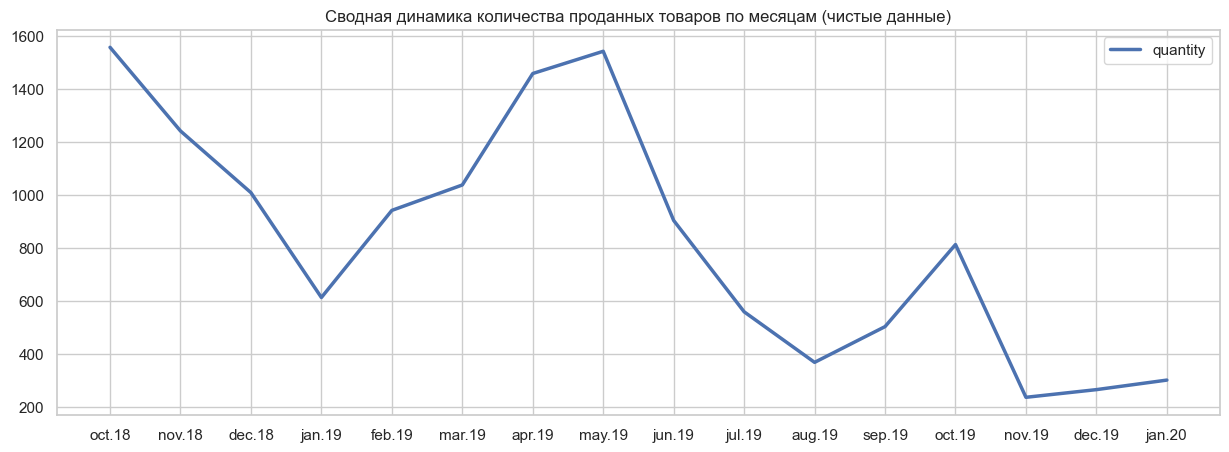

In [144]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сводная динамика количества проданных товаров по месяцам (чистые данные)');

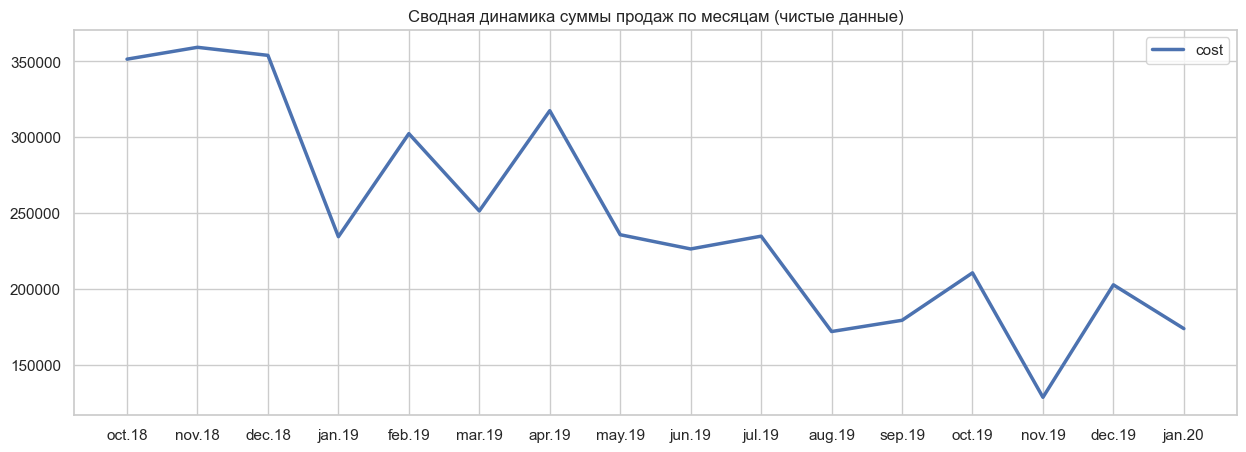

In [145]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('cost'), index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сводная динамика суммы продаж по месяцам (чистые данные)');

На очищенных данных нисходящий тренд отслеживается ещё ярче:
- по количеству заказанных товаров октябрь и январь просели в 2 раза ноябрь и декабрь в 4 раза.
- по доходу с заказов октябрь просел на 40%, ноябрь на 65%, декабрь на 43%, январь на 25%
- без выбросов нисходящая динамика визуально прослеживается и в летние месяцы, на протяжении всего исследуемого периода

#### Средний чек

In [146]:
season_orders = orders_clear[(orders_clear['date']>='2019-01-01')&(orders_clear['date']<'2020-01-01')].pivot_table(values = ('cost'), columns = 'category', index = 'month', aggfunc=('median'))
season_orders

category  бытовые  декор  посуда  рассада    тара
month                                            
1          898.00 133.00  715.00   214.50 1087.00
2          802.00 286.00  479.00   157.00 1087.00
3         1049.00 280.00  712.00   314.00 1087.00
4          726.00 177.00  269.00   543.50 1087.00
5          625.50 520.00  346.50   830.00 1087.00
6          726.50 300.00  471.00   336.00  741.50
7          697.00 242.00  552.00   247.00 1087.00
8          971.50 113.50  300.00   302.50 1050.00
9          734.00 163.00  974.00   157.00 1087.00
10         914.00 177.00  352.00   164.50 1087.00
11         438.00 104.00  164.00   116.00 1011.75
12         820.50  55.67  202.00   118.00 1424.00

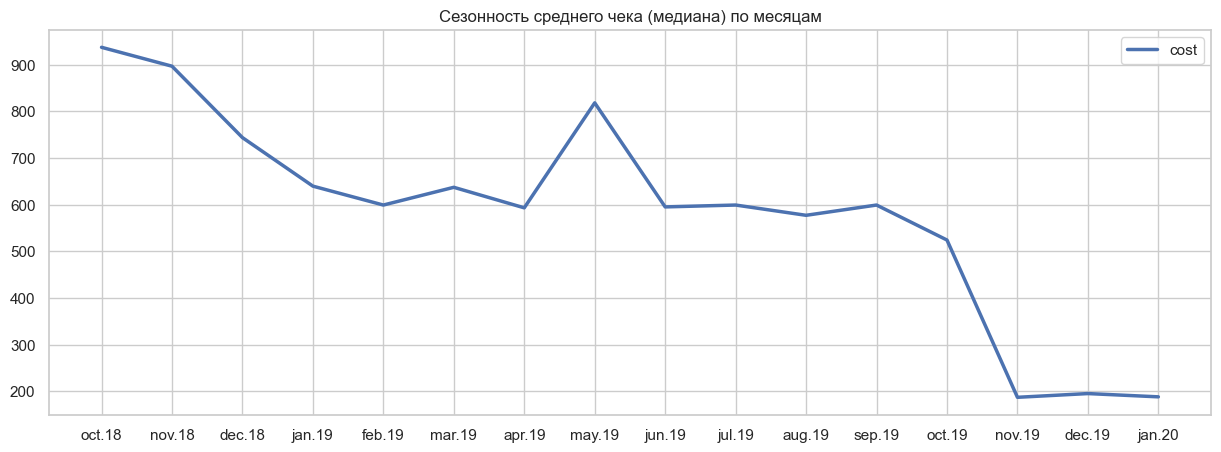

In [147]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('cost'), index = ('year','month'), aggfunc=('median')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность среднего чека (медиана) по месяцам');

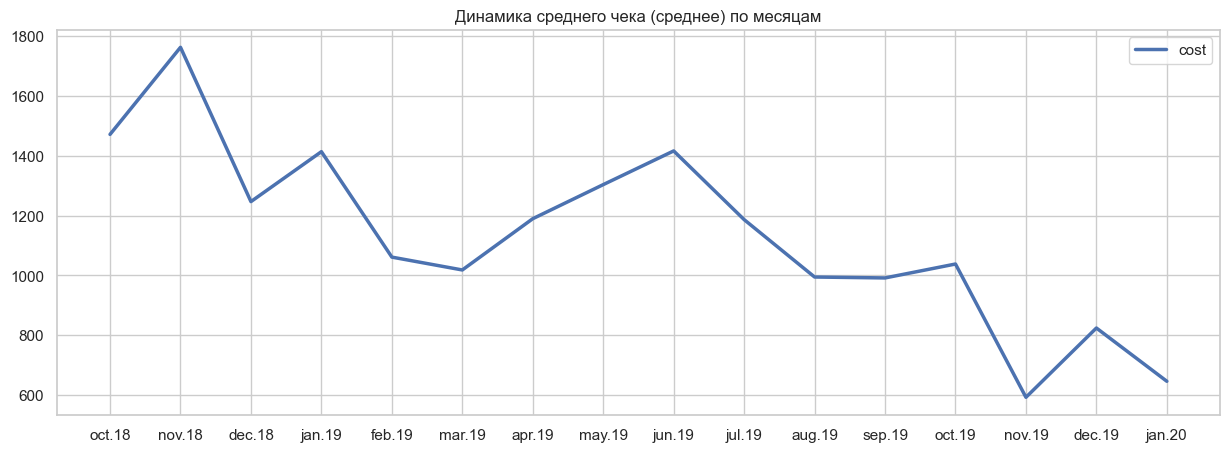

In [148]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('cost'), index = ('year','month'), aggfunc=('mean')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика среднего чека (среднее) по месяцам');

Средний чек заказа также снижается на протяжении всего анализируемого периода: сильный спад прошёл в октябре 2018-январе 2019, потом средний чек вышел на плато с февраля по октябрь и кратно снизился в ноябре 2019. 

По медианным значениям, средний чек упал с 900 до 200 рублей за анализируемый период.

#### Количество заказов по месяцам

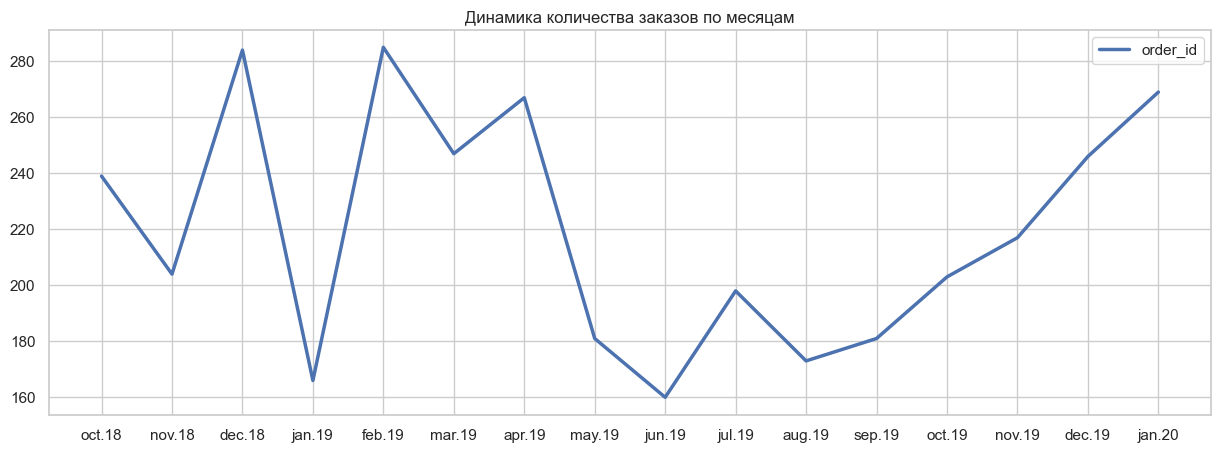

In [149]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('order_id'), index = ('year','month'), aggfunc=('count')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика количества заказов по месяцам');

Количество уникальных заказов при этом ведёт себя менее предсказуемо:
- с октября 2018 по май 2019 наблюдалась сильная волотильность количества заказов, от 160 до 280 в месяц
- с июня 2019 по январь 2020 ярко выраженный рост количества заказов с 160 до 275 заказов в месяц


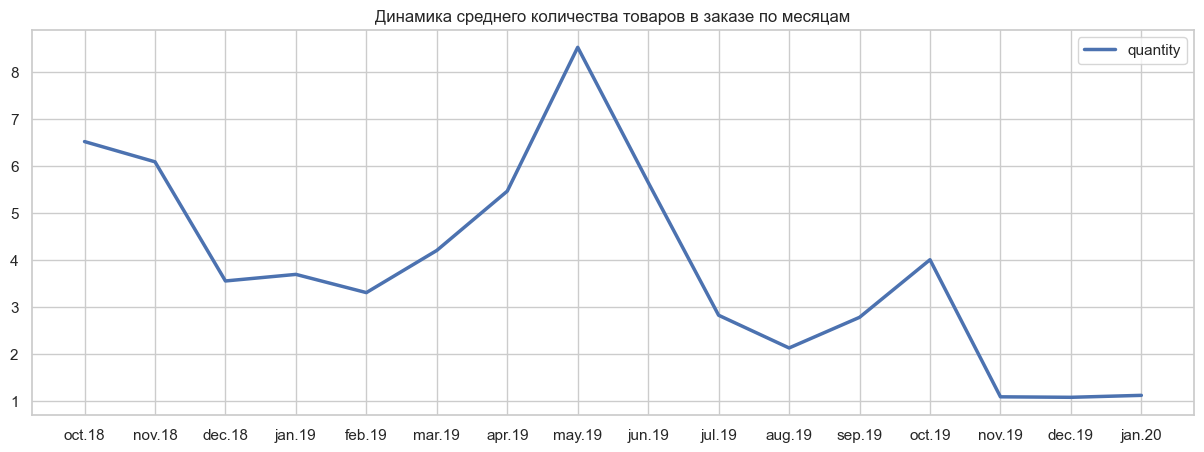

In [150]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('quantity'), index = ('year','month'), aggfunc=('mean')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика среднего количества товаров в заказе по месяцам');

Количество товаров в заказе росло с января по май 2019 с 2,5 до 6,5,
а с мая 2019 нуклонно снижается: с 6,5 до 1.

Из аналитики по товарным категориям известно, что мы потеряли большое количество мелкооптовых покупателей по бытовым товарам, посуде, таре и декору.

In [151]:
orders_clear['avg_price'] = orders_clear['cost'] / orders_clear['quantity']

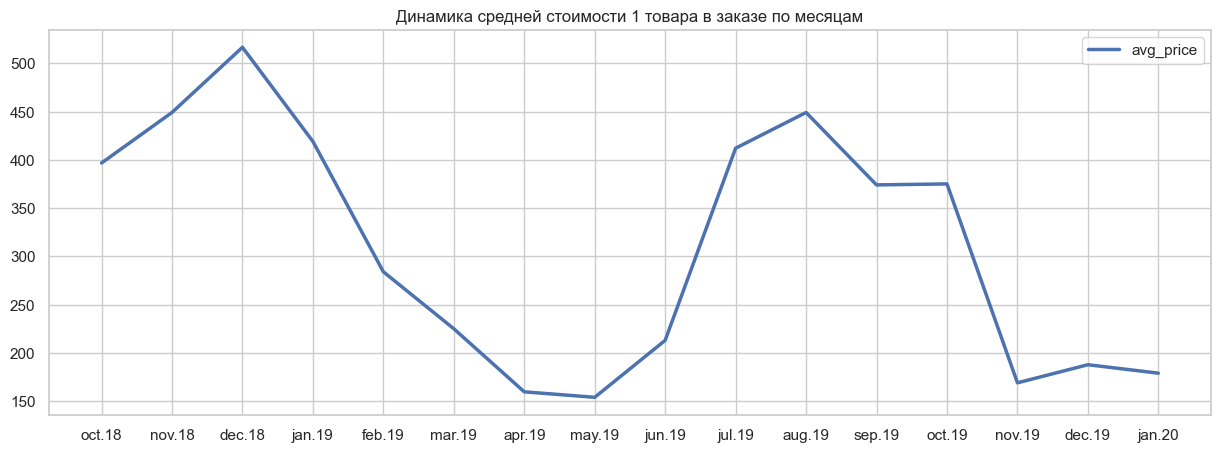

In [152]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=orders_clear.pivot_table(values = ('avg_price'), index = ('year','month'), aggfunc=('median')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Динамика средней стоимости 1 товара в заказе по месяцам');

Спад средней стоимости единицы товара весной 2019 связан с сезонным ростом продаж в категории Рассада, где низкая стоимость одного товара.

С ноября 2019 просели все категории товаров.

**Итог**

По имеющимся данным дела у интернет-магазина в анализируемом периоде идут не лучшим образом:
- количество заказанных товаров упало в 3 раза
- доход просел на 40%
- медианный средний чек уменьшился в 4 раза
- среднее количество товаров в заказе снизилось до 1
- ушла большая часть мелооптовых покупателей
- при этом количество заказов остаётся высоким, что, вероятно, влияет на маржинальность, накладывая дополнительные издержки для обработки и доставки заказов

В качестве глобальной стратегии компании необходимо сосредоточиться на увеличении среднего чека заказа и всех сопутствующих показателей:
- количества товаров в заказе
- стоимости 1 товара в заказе
- выстроить работу с оптовыми заказчиками

#### Анализ заказов по времени (сезонность)

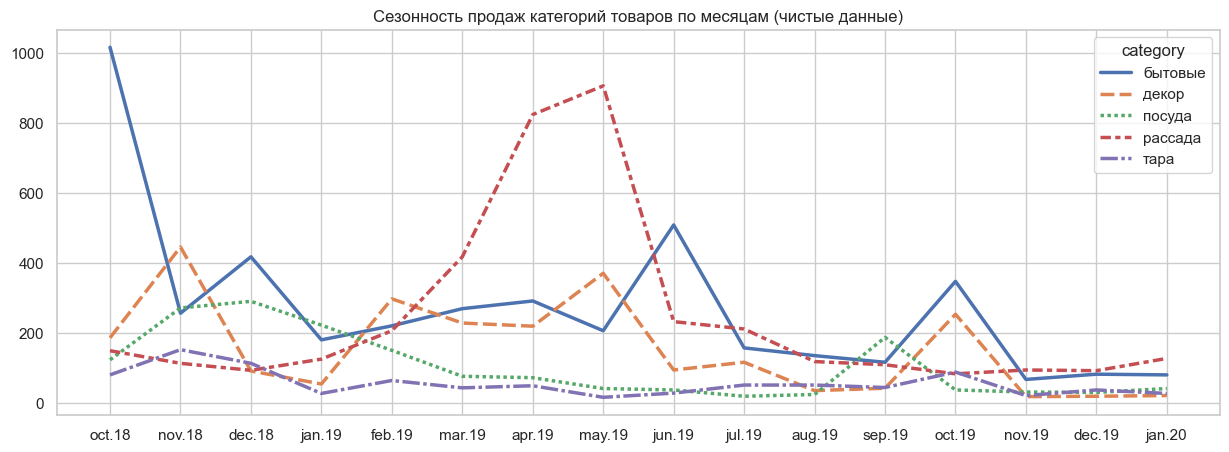

In [153]:
season_m = orders_clear.pivot_table(values = 'quantity', columns = 'category', index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month'])
plt.figure(figsize=(15, 5))
sns.lineplot(data=season_m, linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность продаж категорий товаров по месяцам (чистые данные)');


По чистым данным:
- ярко выраженная сезонность видна только в категории "рассада", с стремительным ростом числа проданных товаров с января по май и резкми спадом с начала дачного сезона.
- в категории "декор" логично предополжить сезонность с пиком в октябре-ноябре перед новогодними праздниками

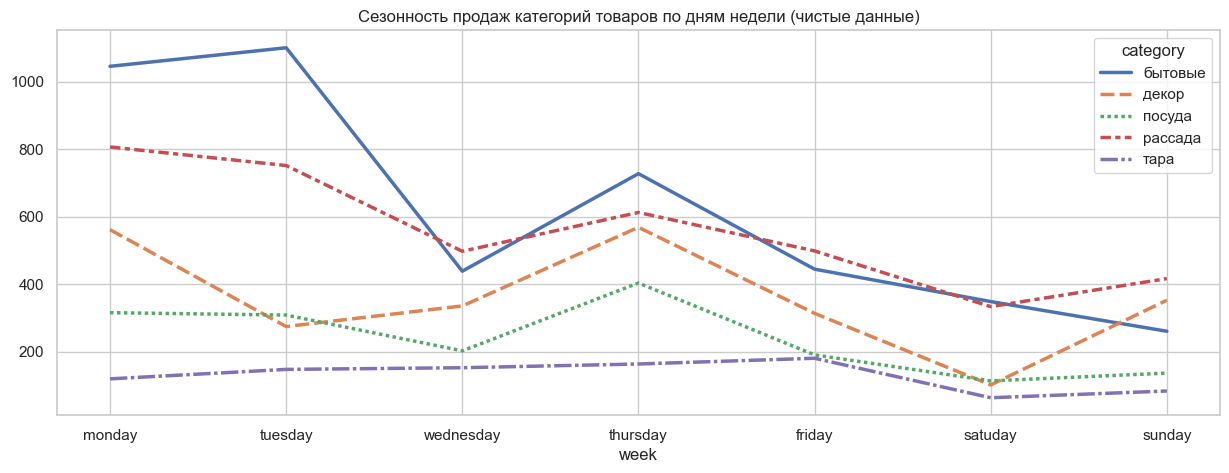

In [154]:
season_w = orders_clear.pivot_table(values = 'quantity', columns = 'category', index = 'week', aggfunc=('sum'))

plt.figure(figsize=(15, 5))
sns.lineplot(data=season_w, linewidth=2.5)
plt.xticks(np.arange(7),['monday','tuesday','wednesday','thursday','friday','satuday','sunday'])
plt.title('Сезонность продаж категорий товаров по дням недели (чистые данные)');


- во всех категориях товара прослеживается исльный спад количества заказанных товаров в субботу, когда наменьший пик деловой активности
- рассада обычно заказывается по понедельника и вторникам и в меньшей степени по четвергам.
- товары бытового назначения чаще заказываются по понедельникам, объем товаров снижается к среде и после небольшого всплеска в четверг снова снижается.
- декор и подарки чаще заказывают по средам и воскресеньям
- в посуде и таре особой динамики кроме ощего спада продаж по субботам не наблюдается

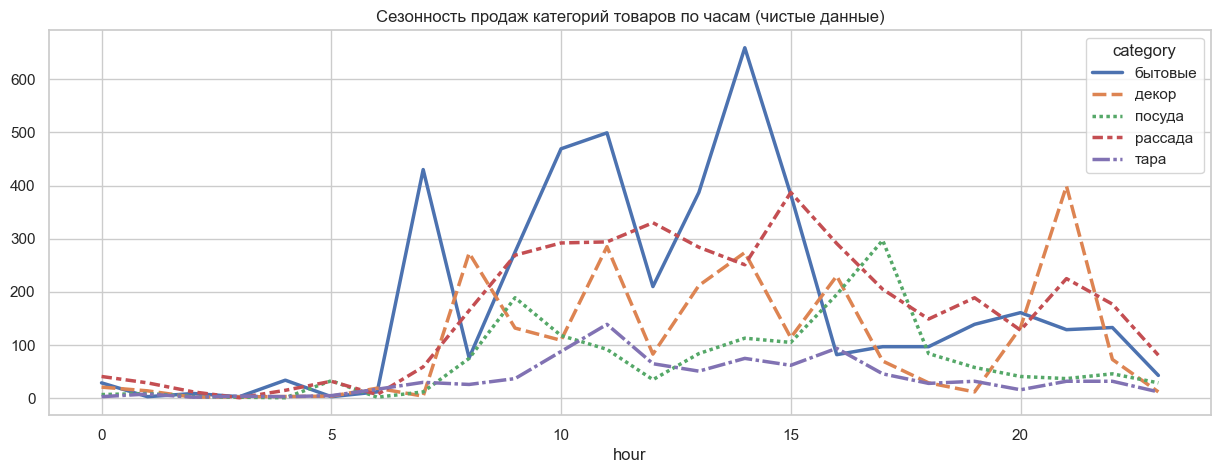

In [155]:
season_h = orders_clear.pivot_table(values = 'quantity', columns = 'category', index = 'hour', aggfunc=('sum'))


plt.figure(figsize=(15, 5))
sns.lineplot(data=season_h, linewidth=2.5)
plt.title('Сезонность продаж категорий товаров по часам (чистые данные)');

По очищенным данным:
- люди продолжают делать заказы в рабочее время и по вечерам
- ярко выраженный спад заказов приходится на послерабочее время, когда клиенты находятся в дороге от работы до доам
- небольшой всплекс заказов в вечернее время заканчивается полным затишьем после полуночи.

**Рекомендации по рассылкам:**

Учитывая общую дизамику заказов, рассылки лучше проводить по понедельникам в районе 9-10 утра, у этого времени наивысший потенциал для конверсии рассылок в покупки.

### Компонуем заказы, формируем сводную таблицу по покупателям:

- id покупателя
- количество заказов
- общая сумма заказов
- общее количество товаров
- дата первого заказа
- дата последнего заказа
- количество товаров или общая сумма покупок по категориям (если целесообразно)

Расчитываем:
- лайфтайм покупателя
- частотность заказов, дней между заказов
- средний чек заказов

In [156]:
orders_clear.head()

order_id                           customer_id                date  month  \
0     12624  d17861fa-db5f-4de4-93fd-dc5e60d24d3e 2019-06-02 20:00:00      6   
1     13547  b80e4826-7218-4bf9-ac08-eb2c81ab3f62 2018-10-05 00:00:00     10   
2     14480  f08d9018-438e-4e96-b519-f74c0302a433 2018-10-02 11:00:00     10   
3     14481  49b9c587-c19e-4481-bace-967aeac357fa 2018-10-02 17:00:00     10   
4     14482  43993fd2-20c9-44f7-8634-cf0aee26df4f 2018-10-07 12:00:00     10   

   year  week  hour  quantity   cost category  avg_price  
0  2019     6    20         2 375.00  бытовые     187.50  
1  2018     4     0         3 684.00  рассада     228.00  
2  2018     1    11         3 359.00  рассада     119.67  
3  2018     1    17         4 600.00  рассада     150.00  
4  2018     6    12         2 376.00  рассада     188.00

In [157]:
customers = orders_clear.sort_values(by=['customer_id', 'category']).groupby('customer_id').agg(
            {
                
                'order_id': 'count',

                'quantity': 'sum',
                'cost': 'sum',
                'date': 'min',                
                'category': 'sum',
            }
        ).reset_index().rename(columns={'order_id': 'orders','date':'first_dt','cost':'total_cost','quantity':'total_qty'})
        #.reset_index()

ld = orders_clear.sort_values(by=['customer_id', 'order_id']).groupby('customer_id').agg(
            {

                'date': 'max',                
            }
        ).reset_index().rename(columns={'date':'last_dt'})    
    
customers = customers.merge(ld, how='left', on='customer_id')
customers['lifetime'] = (customers['last_dt'] - customers['first_dt']).dt.days
customers['avg_cost'] = customers['total_cost'] / customers['orders']
customers['qty_cost'] = customers['total_cost'] / customers['total_qty']
customers['avg_qty'] = customers['total_qty'] / customers['orders']
customers['freq'] = customers['lifetime'] / customers['orders']
customers

customer_id  orders  total_qty  total_cost  \
0     000d6849-084e-4d9f-ac03-37174eaf60c4       1          4      555.00   
1     001cee7f-0b29-4716-b202-0042213ab038       1          1      442.00   
2     00299f34-5385-4d13-9aea-c80b81658e1b       1          2      914.00   
3     002d4d3a-4a59-406b-86ec-c3314357e498       1          1     1649.00   
4     003bbd39-0000-41ff-b7f9-2ddaec152037       1          2     2324.00   
...                                    ...     ...        ...         ...   
2424  ff601403-b094-4b86-9ac6-264d725b9277       2          2     1739.00   
2425  ffaeab76-3a8d-49ee-860f-17273b2fc8a2       1          1      397.00   
2426  ffb5976a-7a4d-460b-95c4-5ffaba31cb24       1          1      389.00   
2427  ffb80538-3fda-4351-8ea9-9d2bec58bb07       1          1      974.00   
2428  ffe82299-3f5b-4214-87fe-3d36ecccfac3       1          1      577.00   

                first_dt     category             last_dt  lifetime  avg_cost  \
0    2019-10-16 08:00:00      рассада 2019-10-16 08:00:00         0    555.00   
1    2019-02-16 11:00:00      бытовые 2019-02-16 11:00:00         0    442.00   
2    2019-10-14 23:00:00      бытовые 2019-10-14 23:00:00         0    914.00   
3    2019-01-27 17:00:00         тара 2019-01-27 17:00:00         0   1649.00   
4    2019-09-29 17:00:00      бытовые 2019-09-29 17:00:00         0   2324.00   
...                  ...          ...                 ...       ...       ...   
2424 2019-08-16 16:00:00  рассадатара 2020-01-19 11:00:00       155    869.50   
2425 2019-10-30 07:00:00         тара 2019-10-30 07:00:00         0    397.00   
2426 2018-12-14 23:00:00      рассада 2018-12-14 23:00:00         0    389.00   
2427 2019-09-09 12:00:00       посуда 2019-09-09 12:00:00         0    974.00   
2428 2019-10-22 13:00:00      бытовые 2019-10-22 13:00:00         0    577.00   

      qty_cost  avg_qty  freq  
0       138.75     4.00  0.00  
1       442.00     1.00  0.00  
2       457.00     2.00  0.00  
3      1649.00     1.00  0.00  
4      1162.00     2.00  0.00  
...        ...      ...   ...  
2424    869.50     1.00 77.50  
2425    397.00     1.00  0.00  
2426    389.00     1.00  0.00  
2427    974.00     1.00  0.00  
2428    577.00     1.00  0.00  

[2429 rows x 12 columns]

In [158]:
customers['orders'].value_counts(normalize=True)

orders
1     0.64
2     0.35
3     0.01
4     0.00
5     0.00
35    0.00
17    0.00
7     0.00
126   0.00
Name: proportion, dtype: float64

In [159]:
customers['lifetime'].value_counts(normalize=True)

lifetime
0     0.67
289   0.01
267   0.01
304   0.00
291   0.00
      ... 
35    0.00
198   0.00
157   0.00
108   0.00
27    0.00
Name: proportion, Length: 258, dtype: float64

In [160]:
for _ in range(15):
    customers['category'] = customers['category'].replace('рассадарассада','рассада',regex=True)
    customers['category'] = customers['category'].replace('бытовыебытовые','бытовые',regex=True)
    customers['category'] = customers['category'].replace('декордекор','декор',regex=True)
    customers['category'] = customers['category'].replace('посудапосуда','посуда',regex=True)
    customers['category'] = customers['category'].replace('таратара','тара',regex=True)

In [161]:
customers['category'].value_counts(normalize=True)

category
бытовые                         0.27
рассада                         0.23
тара                            0.11
посуда                          0.09
декор                           0.07
бытовыерассада                  0.07
бытовыетара                     0.03
бытовыепосуда                   0.03
рассадатара                     0.03
посударассада                   0.02
посудатара                      0.01
бытовыедекор                    0.01
декоррассада                    0.01
декортара                       0.01
декорпосуда                     0.00
бытовыедекорпосударассадатара   0.00
бытовыепосудатара               0.00
бытовыепосударассадатара        0.00
Name: proportion, dtype: float64

В разрезе покупателей доля пересечений товарных категорий уже существенна, для кластеризации добавим сумму расходов по каждой категории в профиль клиента.

In [162]:
orders_clear.head()

order_id                           customer_id                date  month  \
0     12624  d17861fa-db5f-4de4-93fd-dc5e60d24d3e 2019-06-02 20:00:00      6   
1     13547  b80e4826-7218-4bf9-ac08-eb2c81ab3f62 2018-10-05 00:00:00     10   
2     14480  f08d9018-438e-4e96-b519-f74c0302a433 2018-10-02 11:00:00     10   
3     14481  49b9c587-c19e-4481-bace-967aeac357fa 2018-10-02 17:00:00     10   
4     14482  43993fd2-20c9-44f7-8634-cf0aee26df4f 2018-10-07 12:00:00     10   

   year  week  hour  quantity   cost category  avg_price  
0  2019     6    20         2 375.00  бытовые     187.50  
1  2018     4     0         3 684.00  рассада     228.00  
2  2018     1    11         3 359.00  рассада     119.67  
3  2018     1    17         4 600.00  рассада     150.00  
4  2018     6    12         2 376.00  рассада     188.00

In [163]:
custom_categories = orders_clear.pivot_table(index='customer_id', columns='category', values='cost', aggfunc='sum')

In [164]:
custom_categories = custom_categories.fillna(0).reset_index()
custom_categories

category                           customer_id  бытовые  декор  посуда  \
0         000d6849-084e-4d9f-ac03-37174eaf60c4     0.00   0.00    0.00   
1         001cee7f-0b29-4716-b202-0042213ab038   442.00   0.00    0.00   
2         00299f34-5385-4d13-9aea-c80b81658e1b   914.00   0.00    0.00   
3         002d4d3a-4a59-406b-86ec-c3314357e498     0.00   0.00    0.00   
4         003bbd39-0000-41ff-b7f9-2ddaec152037  2324.00   0.00    0.00   
...                                        ...      ...    ...     ...   
2424      ff601403-b094-4b86-9ac6-264d725b9277     0.00   0.00    0.00   
2425      ffaeab76-3a8d-49ee-860f-17273b2fc8a2     0.00   0.00    0.00   
2426      ffb5976a-7a4d-460b-95c4-5ffaba31cb24     0.00   0.00    0.00   
2427      ffb80538-3fda-4351-8ea9-9d2bec58bb07     0.00   0.00  974.00   
2428      ffe82299-3f5b-4214-87fe-3d36ecccfac3   577.00   0.00    0.00   

category  рассада    тара  
0          555.00    0.00  
1            0.00    0.00  
2            0.00    0.00  
3            0.00 1649.00  
4            0.00    0.00  
...           ...     ...  
2424        90.00 1649.00  
2425         0.00  397.00  
2426       389.00    0.00  
2427         0.00    0.00  
2428         0.00    0.00  

[2429 rows x 6 columns]

In [165]:
customers = customers.merge(custom_categories, how='left', on='customer_id')

In [166]:
customers = customers.drop(columns='category')
customers.head()

customer_id  orders  total_qty  total_cost  \
0  000d6849-084e-4d9f-ac03-37174eaf60c4       1          4      555.00   
1  001cee7f-0b29-4716-b202-0042213ab038       1          1      442.00   
2  00299f34-5385-4d13-9aea-c80b81658e1b       1          2      914.00   
3  002d4d3a-4a59-406b-86ec-c3314357e498       1          1     1649.00   
4  003bbd39-0000-41ff-b7f9-2ddaec152037       1          2     2324.00   

             first_dt             last_dt  lifetime  avg_cost  qty_cost  \
0 2019-10-16 08:00:00 2019-10-16 08:00:00         0    555.00    138.75   
1 2019-02-16 11:00:00 2019-02-16 11:00:00         0    442.00    442.00   
2 2019-10-14 23:00:00 2019-10-14 23:00:00         0    914.00    457.00   
3 2019-01-27 17:00:00 2019-01-27 17:00:00         0   1649.00   1649.00   
4 2019-09-29 17:00:00 2019-09-29 17:00:00         0   2324.00   1162.00   

   avg_qty  freq  бытовые  декор  посуда  рассада    тара  
0     4.00  0.00     0.00   0.00    0.00   555.00    0.00  
1     1.00  0.00   442.00   0.00    0.00     0.00    0.00  
2     2.00  0.00   914.00   0.00    0.00     0.00    0.00  
3     1.00  0.00     0.00   0.00    0.00     0.00 1649.00  
4     2.00  0.00  2324.00   0.00    0.00     0.00    0.00

In [167]:
customers = customers.rename(columns={'бытовые':'house','декор':'decor','посуда':'citchen','рассада':'plants','тара':'package'})

In [168]:
customers['house'] = customers['house'] / customers['total_cost']
customers['decor'] = customers['decor'] / customers['total_cost']
customers['citchen'] = customers['citchen'] / customers['total_cost']
customers['plants'] = customers['plants'] / customers['total_cost']
customers['package'] = customers['package'] / customers['total_cost']

#### Анализируем данные о пользователях, проводим предварительную кластеризацию на основании сводных таблиц

In [169]:
customers.sort_values(by='orders', ascending=False).head()

customer_id  orders  total_qty  total_cost  \
1897  c971fb21-d54c-4134-938f-16b62ee86d3b     126        334   159508.00   
732   4d93d3f6-8b24-403b-a74b-f5173e40d7db      35        309    57278.00   
1088  73d1cd35-5e5f-4629-8cf2-3fda829d4e58      17         17    21361.00   
1731  b7b865ab-0735-407f-8d0c-31f74d2806cc       7         68     3779.00   
17    0184f535-b60a-4914-a982-231e3f615206       5         58     5891.00   

                first_dt             last_dt  lifetime  avg_cost  qty_cost  \
1897 2018-10-01 09:00:00 2019-03-06 12:00:00       156   1265.94    477.57   
732  2018-10-01 13:00:00 2018-10-24 14:00:00        23   1636.51    185.37   
1088 2019-10-02 15:00:00 2019-10-31 14:00:00        28   1256.53   1256.53   
1731 2019-02-15 10:00:00 2019-04-23 17:00:00        67    539.86     55.57   
17   2019-03-07 10:00:00 2019-05-23 12:00:00        77   1178.20    101.57   

      avg_qty  freq  house  decor  citchen  plants  package  
1897     2.65  1.24   0.43   0.03     0.06    0.08     0.40  
732      8.83  0.66   0.72   0.02     0.03    0.03     0.20  
1088     1.00  1.65   0.32   0.00     0.08    0.01     0.59  
1731     9.71  9.57   0.00   0.00     0.00    1.00     0.00  
17      11.60 15.40   0.00   0.00     0.00    1.00     0.00

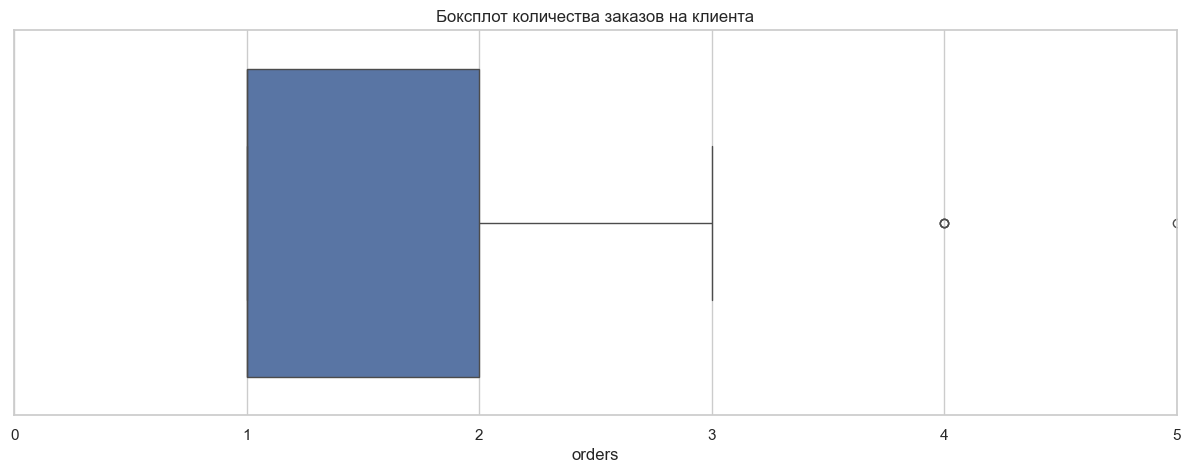

In [170]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=customers, x='orders')
plt.xlim(0,5)
plt.title('Боксплот количества заказов на клиента');

В данных есть покупатели с аномально высоким количеством заказов, поскольку каждый удаленный покупатель это уже десятки закзов и сотни товаров, удали только самыя явные выбросы, свыше 99,9 процентиля.

In [171]:
np.percentile(customers['orders'], 99.9)

12.720000000001164

In [172]:
customers = customers[customers['orders']<=np.percentile(customers['orders'], 99.9)]

<Axes: xlabel='avg_cost', ylabel='Probability'>

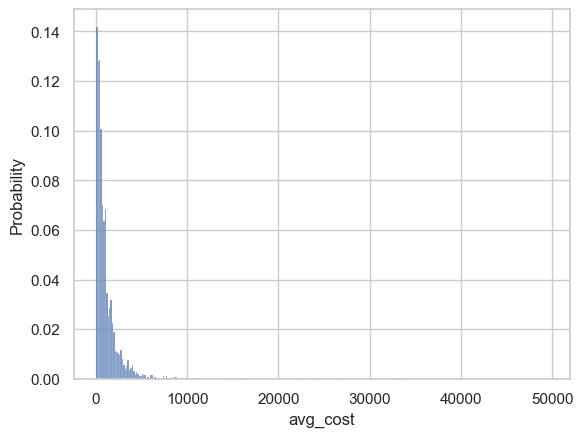

In [173]:
sns.histplot(data=customers, x='avg_cost', stat='probability')

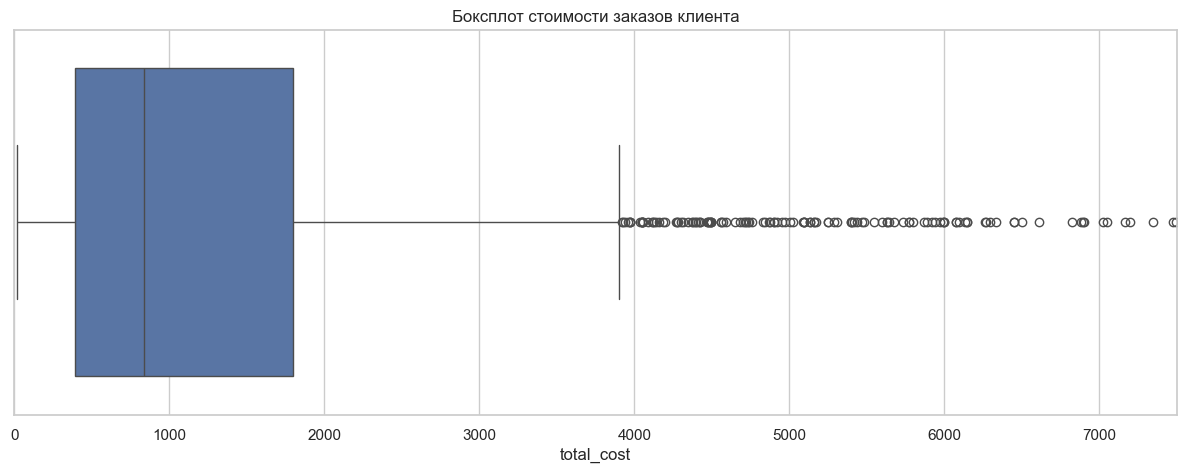

In [174]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=customers, x='total_cost')
plt.xlim(0,7500)
plt.title('Боксплот стоимости заказов клиента');

In [175]:
np.percentile(customers['total_cost'], 99.9)

38406.50000000224

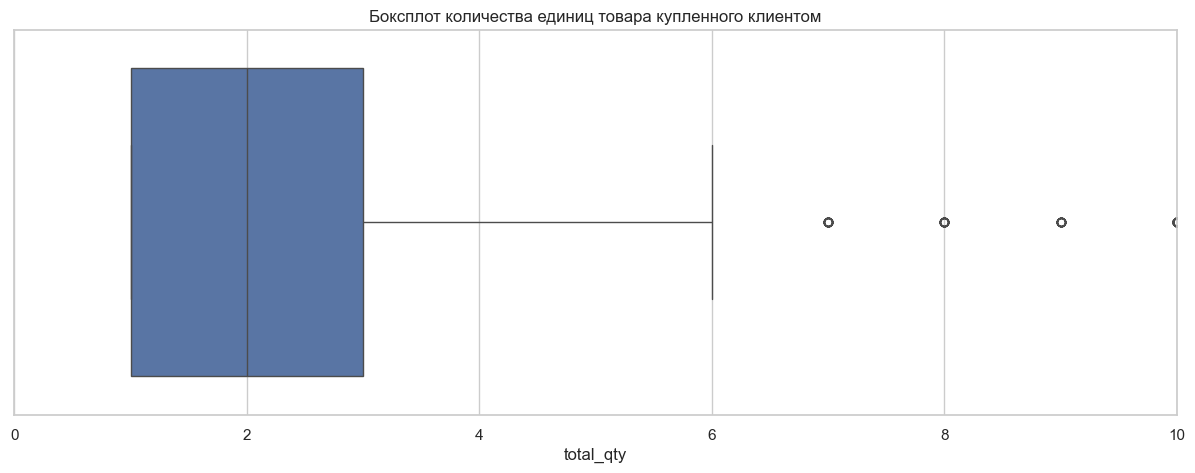

In [176]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=customers, x='total_qty')
plt.xlim(0,10)
plt.title('Боксплот количества единиц товара купленного клиентом');

In [177]:
np.percentile(customers['total_qty'], 99)

58.75

In [178]:
customers = customers[customers['total_qty']<=np.percentile(customers['total_qty'], 99)]

#### Сравнение характеристик покупателей по группам по количеству заказов
Разделим покупателей на 3 группы: с 1 заказом, с 2 заказами, с 3 и более заказами и проанализируем их характеристики

In [179]:
customers.head()

customer_id  orders  total_qty  total_cost  \
0  000d6849-084e-4d9f-ac03-37174eaf60c4       1          4      555.00   
1  001cee7f-0b29-4716-b202-0042213ab038       1          1      442.00   
2  00299f34-5385-4d13-9aea-c80b81658e1b       1          2      914.00   
3  002d4d3a-4a59-406b-86ec-c3314357e498       1          1     1649.00   
4  003bbd39-0000-41ff-b7f9-2ddaec152037       1          2     2324.00   

             first_dt             last_dt  lifetime  avg_cost  qty_cost  \
0 2019-10-16 08:00:00 2019-10-16 08:00:00         0    555.00    138.75   
1 2019-02-16 11:00:00 2019-02-16 11:00:00         0    442.00    442.00   
2 2019-10-14 23:00:00 2019-10-14 23:00:00         0    914.00    457.00   
3 2019-01-27 17:00:00 2019-01-27 17:00:00         0   1649.00   1649.00   
4 2019-09-29 17:00:00 2019-09-29 17:00:00         0   2324.00   1162.00   

   avg_qty  freq  house  decor  citchen  plants  package  
0     4.00  0.00   0.00   0.00     0.00    1.00     0.00  
1     1.00  0.00   1.00   0.00     0.00    0.00     0.00  
2     2.00  0.00   1.00   0.00     0.00    0.00     0.00  
3     1.00  0.00   0.00   0.00     0.00    0.00     1.00  
4     2.00  0.00   1.00   0.00     0.00    0.00     0.00

In [180]:
customers['group'] = 0
customers.loc[customers['orders'] == 1,'group'] = 1
customers.loc[customers['orders'] == 2,'group'] = 2
customers.loc[customers['orders'] > 2,'group'] = 3
customers['group'].value_counts(normalize=True)

group
1   0.63
2   0.36
3   0.01
Name: proportion, dtype: float64

In [181]:
customers[['orders','total_qty','total_cost','avg_cost','qty_cost','avg_qty', 'freq','house','decor','citchen','plants','package','group']].groupby('group').agg('mean').reset_index()

group  orders  total_qty  total_cost  avg_cost  qty_cost  avg_qty   freq  \
0      1    1.00       4.60     1216.80   1216.80    670.69     4.60   0.00   
1      2    2.00       2.75     1810.29    905.14    800.56     1.37 112.78   
2      3    3.17      15.13     2994.04    945.58    534.16     4.58   9.30   

   house  decor  citchen  plants  package  
0   0.33   0.11     0.12    0.28     0.15  
1   0.45   0.04     0.10    0.20     0.20  
2   0.09   0.13     0.05    0.57     0.17

In [182]:
customers[['orders','total_qty','total_cost','group']].groupby('group').agg('sum').reset_index()


group  orders  total_qty  total_cost
0      1    1524       7015  1854410.50
1      2    1708       2348  1545983.92
2      3      73        348    68863.00

In [183]:
customers = customers.drop(labels=['group'], axis=1)

- 63% клиентов осуществили 1 заказ, 36% 2 заказа, 1% 3 и более
- для клиентов с 2 заказами заказы в среднем осуществляются 1 раз в 112 дней, для клиентов с 3 и более раз в 9 дней.
- клиенты с 2 заказами заказывают меньше других групп: в среднем 1,37 товара за заказ, для других групп среднее количество товаров в заказе больше 4.5.
- средний чек клиентов с 2 заказами также ниже других: 905 рублей, для клиентов с 1 заказом 1216, для клиентов с 3 и более заказми 945 рублей.
- клиенты с 3 и более заказами больше других заказывают саженцы и меньше всех бытовые товары и товары для кухни.

**Гипотеза: клиенты с 2 заказами сейчас не такие уж и выгодные для бизнеса, требуется работа с постоянщиками**

## Проводим кластеризацию покупателей методом K-MEANS

Общий список факторов, которые могут учитываться при кластеризации:
- Среднее количество заказов клиентов в кластере
- Средний чек заказов клиентов в кластере
- Средняя стоимость 1 единицы в заказе клиентов в кластере
- Среднее количество товаров или средний чек покупок на покупателя по категориям (если целесообразно)



In [184]:
customers.head()

customer_id  orders  total_qty  total_cost  \
0  000d6849-084e-4d9f-ac03-37174eaf60c4       1          4      555.00   
1  001cee7f-0b29-4716-b202-0042213ab038       1          1      442.00   
2  00299f34-5385-4d13-9aea-c80b81658e1b       1          2      914.00   
3  002d4d3a-4a59-406b-86ec-c3314357e498       1          1     1649.00   
4  003bbd39-0000-41ff-b7f9-2ddaec152037       1          2     2324.00   

             first_dt             last_dt  lifetime  avg_cost  qty_cost  \
0 2019-10-16 08:00:00 2019-10-16 08:00:00         0    555.00    138.75   
1 2019-02-16 11:00:00 2019-02-16 11:00:00         0    442.00    442.00   
2 2019-10-14 23:00:00 2019-10-14 23:00:00         0    914.00    457.00   
3 2019-01-27 17:00:00 2019-01-27 17:00:00         0   1649.00   1649.00   
4 2019-09-29 17:00:00 2019-09-29 17:00:00         0   2324.00   1162.00   

   avg_qty  freq  house  decor  citchen  plants  package  
0     4.00  0.00   0.00   0.00     0.00    1.00     0.00  
1     1.00  0.00   1.00   0.00     0.00    0.00     0.00  
2     2.00  0.00   1.00   0.00     0.00    0.00     0.00  
3     1.00  0.00   0.00   0.00     0.00    0.00     1.00  
4     2.00  0.00   1.00   0.00     0.00    0.00     0.00

In [185]:
X = customers.drop(labels=['customer_id','total_cost','first_dt','last_dt','lifetime','total_qty','freq'], axis=1)


scaler = StandardScaler()
scaler.fit(X)


X_scale = scaler.transform(X)

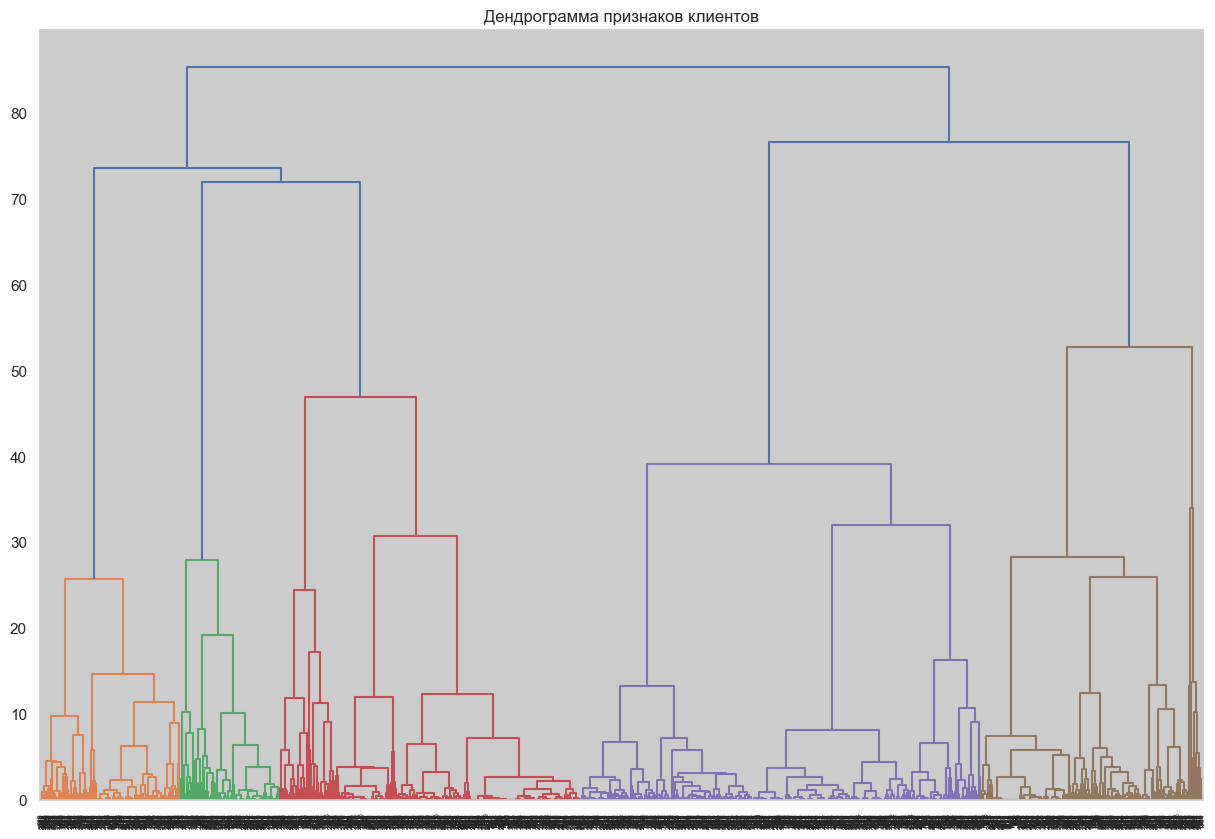

In [186]:
linked = linkage(X_scale, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков клиентов')
plt.show() 

In [187]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_scale)

In [188]:
customers['cluster_km'] = labels

In [189]:
customers['cluster_km'].value_counts(normalize=True)

cluster_km
1   0.38
3   0.24
0   0.18
2   0.11
4   0.08
Name: proportion, dtype: float64

In [190]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_scale, labels) ))

Silhouette_score: 0.48


In [191]:
customers.drop(labels=['customer_id','first_dt','last_dt'], axis=1).groupby('cluster_km').agg('mean')

orders  total_qty  total_cost  lifetime  avg_cost  qty_cost  \
cluster_km                                                                
0             1.46       2.10     2330.29    108.01   1665.66   1405.06   
1             1.45       2.88     1678.58    107.66   1257.66    905.56   
2             1.32       3.79     1130.08     71.24    899.76    473.65   
3             1.29       5.81      825.81     40.26    703.25    214.94   
4             1.19       8.88      699.45     25.81    627.74    148.16   

            avg_qty  freq  house  decor  citchen  plants  package  
cluster_km                                                         
0              1.58 54.00   0.03   0.00     0.01    0.02     0.93  
1              2.37 53.83   0.95   0.00     0.01    0.02     0.01  
2              3.26 35.56   0.02   0.00     0.94    0.03     0.01  
3              5.05 19.95   0.01   0.01     0.00    0.98     0.00  
4              8.19 12.89   0.01   0.98     0.00    0.01     0.00

**С внесением в модель категорий покупаемых товаров, клиенты разбились по кластерам преимущественно по категориям покупаемых товаров**

#### Без учета категорий товаров

In [192]:
X2 = customers.drop(labels=['customer_id','total_cost','first_dt','last_dt','lifetime','total_qty','house','decor','citchen','plants','package','freq'], axis=1)


scaler = StandardScaler()
scaler.fit(X2)


X2_scale = scaler.transform(X2)

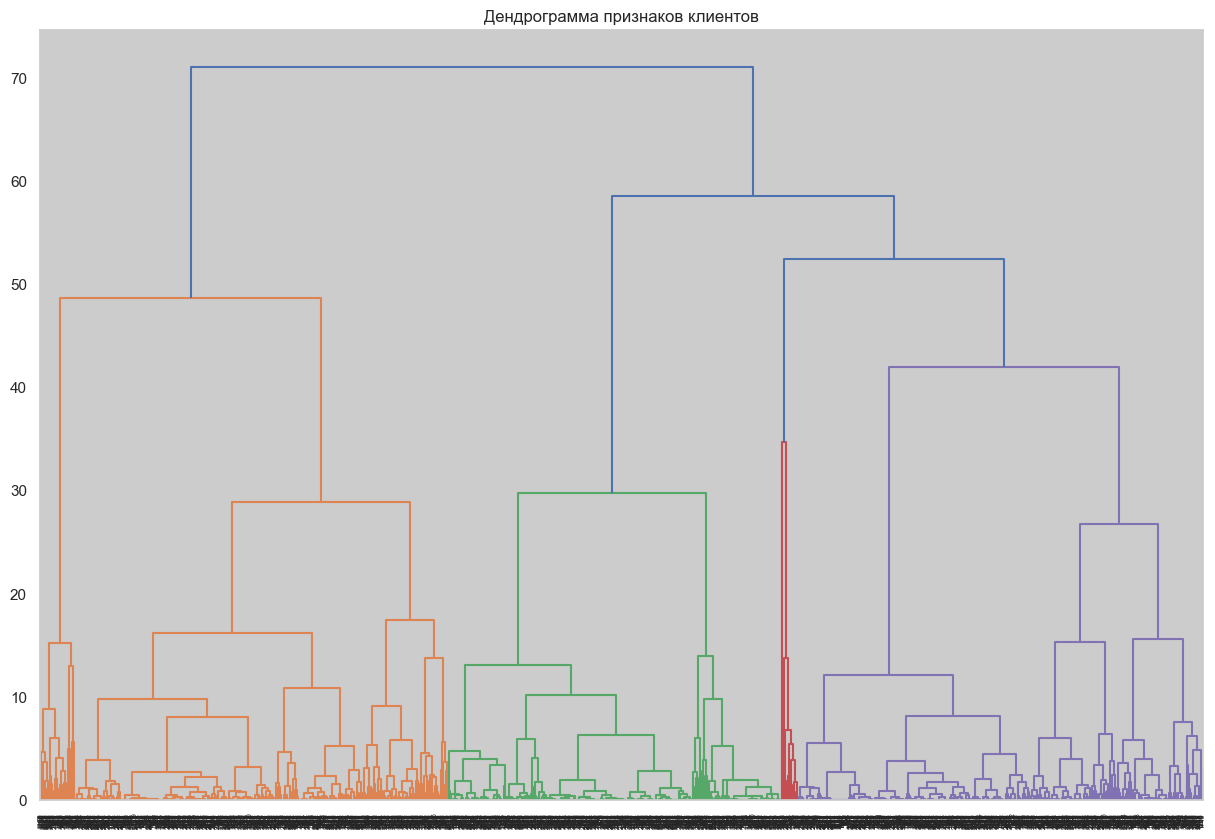

In [193]:
linked = linkage(X2_scale, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков клиентов')
plt.show() 

In [194]:
km2 = KMeans(n_clusters=4, random_state=0)
labels2 = km2.fit_predict(X2_scale)

customers['cluster_km2'] = labels2

In [195]:
customers['cluster_km2'].value_counts(normalize=True)

cluster_km2
0   0.53
1   0.35
2   0.07
3   0.05
Name: proportion, dtype: float64

In [196]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X2_scale, labels2) ))

Silhouette_score: 0.34


In [197]:
customers.drop(labels=['customer_id','first_dt','last_dt'], axis=1).groupby('cluster_km2').agg('mean')

orders  total_qty  total_cost  lifetime  avg_cost  qty_cost  \
cluster_km2                                                                
0              1.53       2.27     1299.88    120.11    889.65    730.07   
1              1.20       3.95      565.12     32.56    508.03    209.56   
2              1.36       1.93     5890.45     77.22   4425.45   3617.01   
3              1.03      26.14     2992.75      0.19   2934.69    115.58   

             avg_qty  freq  house  decor  citchen  plants  package  cluster_km  
cluster_km2                                                                     
0               1.55 59.96   0.61   0.00     0.08    0.04     0.26        0.83  
1               3.54 16.28   0.01   0.19     0.18    0.61     0.00        3.01  
2               1.41 38.59   0.49   0.01     0.03    0.02     0.45        0.61  
3              25.52  0.09   0.24   0.25     0.09    0.41     0.02        2.63

**Без внесения в модель покупаемых информации и группах покупаемых товаров, клиенты рабились по класетрам по количеству товаров в заказе, количеству заказов и чеку. Для анализа возьмём этот вариант**

### Проводим анализ результатов кластеризации, смотрим средние значения факторов по кластерам и существенность их различий

In [198]:
customers.drop(labels=['cluster_km','customer_id','first_dt','last_dt'], axis=1).groupby('cluster_km2').agg('mean')

orders  total_qty  total_cost  lifetime  avg_cost  qty_cost  \
cluster_km2                                                                
0              1.53       2.27     1299.88    120.11    889.65    730.07   
1              1.20       3.95      565.12     32.56    508.03    209.56   
2              1.36       1.93     5890.45     77.22   4425.45   3617.01   
3              1.03      26.14     2992.75      0.19   2934.69    115.58   

             avg_qty  freq  house  decor  citchen  plants  package  
cluster_km2                                                         
0               1.55 59.96   0.61   0.00     0.08    0.04     0.26  
1               3.54 16.28   0.01   0.19     0.18    0.61     0.00  
2               1.41 38.59   0.49   0.01     0.03    0.02     0.45  
3              25.52  0.09   0.24   0.25     0.09    0.41     0.02

In [199]:
customers['cluster_km2'].value_counts(normalize=True)

cluster_km2
0   0.53
1   0.35
2   0.07
3   0.05
Name: proportion, dtype: float64

**Кластер 0:**

- 7% клиентов
- самый высокий средний чек 4406 рублей
- самые дорогие товары в покупке 3618 рублей за единицу товара
- покупали бытовые товары и тару
- совершили в среднем 1,35 заказов
- в среднем покупали 1,4 товаров на заказ или 1,9 за все время, но весьма дорогие

**Кластер 1:**

- 53% клиентов, самый большой сегмент
- совершили 1 заказ
- в среднем покупали 2,8 товаров в заказе
- средний чек 769 рублей, средняя цена товара 460 рублей
- чаще покупали товары для дома и рассаду, реже тару, посуду и декор

**Кластер 2:**

- 6% клиентов
- высокий средний чек 2750 рублей
- в среднем совершили 1 заказ
- самый большое количество товаров в заказе 24,2 ед.
- чаще всего покупали рассаду, декор и бытовые товары, меньше посуды и тары
- самая низкая средняя цена за 1 товар, 114,5 рублей

**Кластер 3:**

- 34% клиентов
- совершили, в среднем, 2 заказа
- покупали мало, в среднем в заказе 1,4 товара на сумму 683 рубля
- часто покупали бытовые товары, меньше рассаду и тару

### Сезонность заказов по кластерам

In [200]:
orders_clust = orders_clear.merge(customers[['customer_id','cluster_km2']], how='left', on='customer_id')

In [201]:
orders_clust['cluster_km2'].value_counts()

cluster_km2
0.00    1948
1.00    1007
2.00     224
3.00     126
Name: count, dtype: int64

In [202]:
clust0 = orders_clust[orders_clust['cluster_km2']==0]
clust1 = orders_clust[orders_clust['cluster_km2']==1]
clust2 = orders_clust[orders_clust['cluster_km2']==2]
clust3 = orders_clust[orders_clust['cluster_km2']==3]

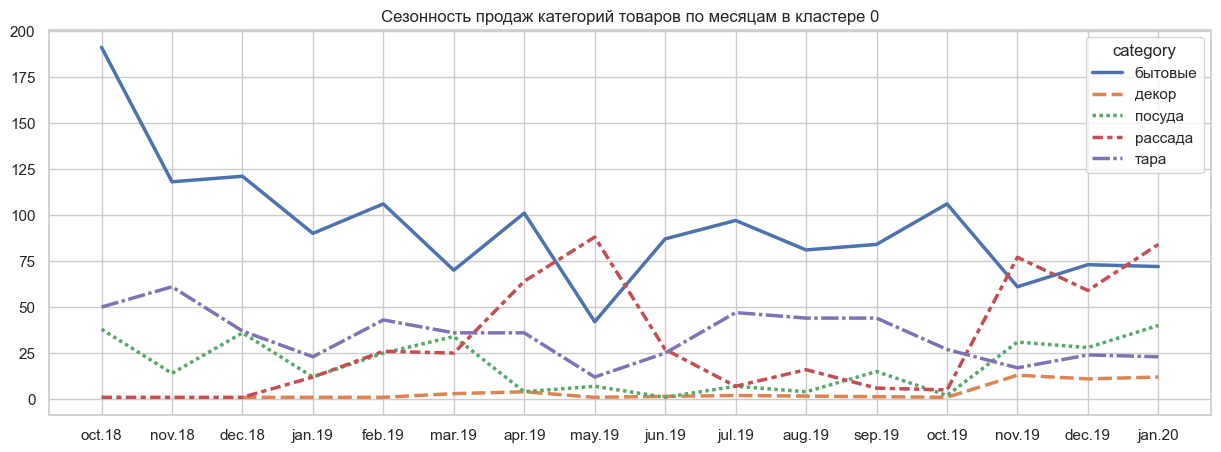

In [203]:

plt.figure(figsize=(15, 5))
sns.lineplot(data=clust0.pivot_table(values = 'quantity', columns = 'category', index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность продаж категорий товаров по месяцам в кластере 0');


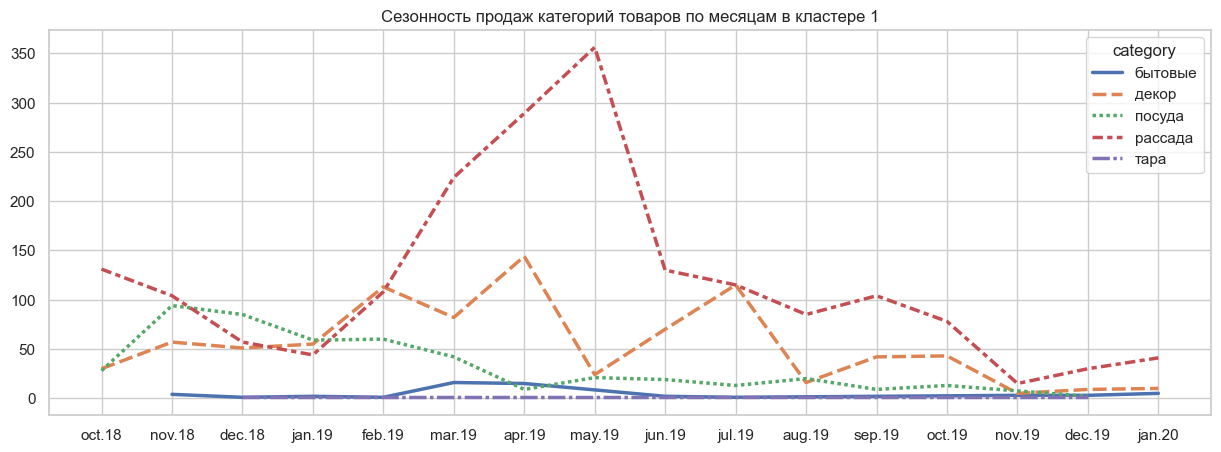

In [204]:

plt.figure(figsize=(15, 5))
sns.lineplot(data=clust1.pivot_table(values = 'quantity', columns = 'category', index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность продаж категорий товаров по месяцам в кластере 1');


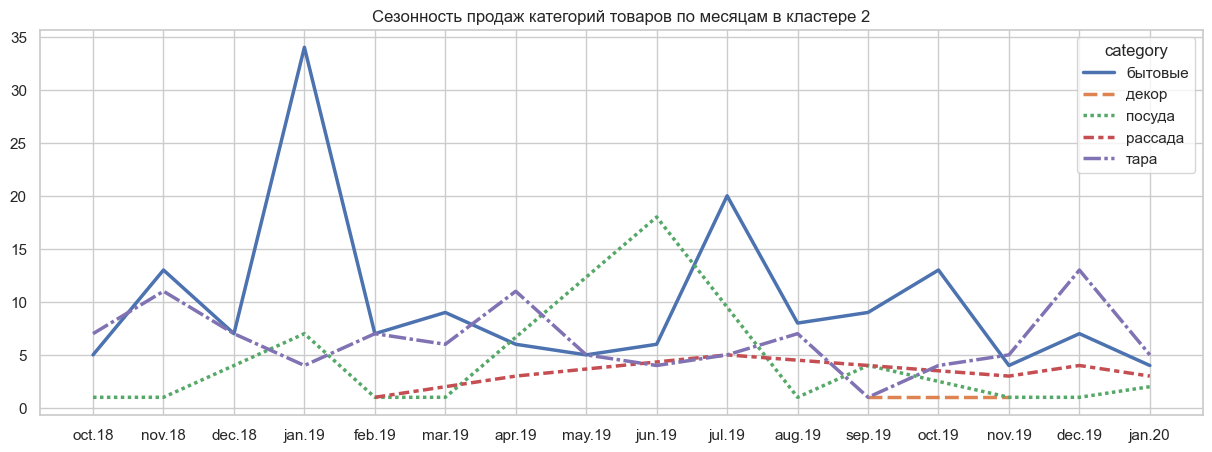

In [205]:

plt.figure(figsize=(15, 5))
sns.lineplot(data=clust2.pivot_table(values = 'quantity', columns = 'category', index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность продаж категорий товаров по месяцам в кластере 2');


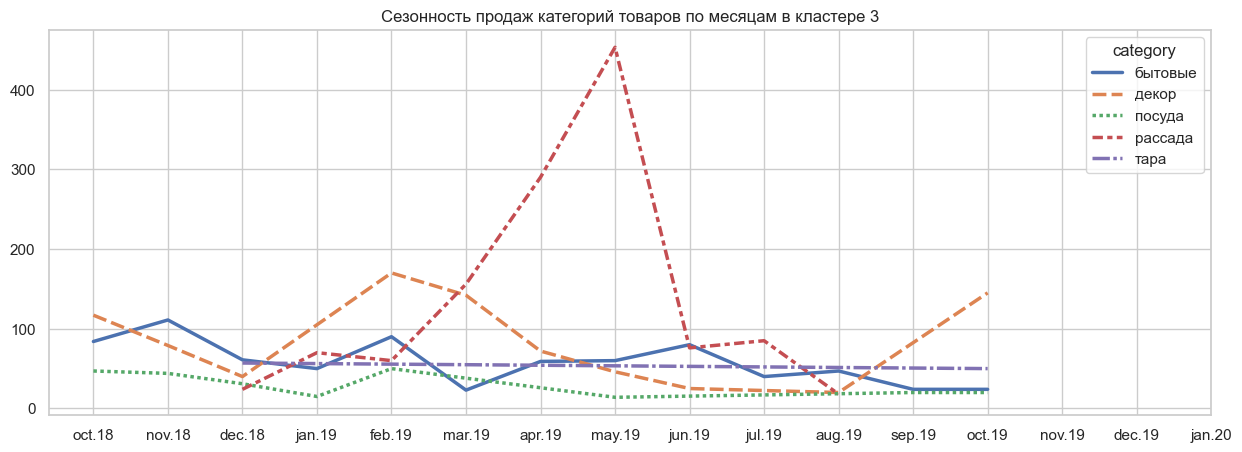

In [206]:

plt.figure(figsize=(15, 5))
sns.lineplot(data=clust3.pivot_table(values = 'quantity', columns = 'category', index = ('year','month'), aggfunc=('sum')).reset_index().drop(columns=['year','month']), linewidth=2.5)
plt.xticks(np.arange(16),['oct.18','nov.18','dec.18','jan.19','feb.19','mar.19','apr.19','may.19','jun.19','jul.19','aug.19','sep.19','oct.19','nov.19','dec.19','jan.20'])
plt.title('Сезонность продаж категорий товаров по месяцам в кластере 3');


### Вывод о таргетировании рассылок

По условиям задачи у нас нет никакой информации о бизнес-модели и целях компании.

Интернет магазин может получать фиксированный доход с каждого заказа, с каждого товара или процент от стоимости товара. В зависимости от этого цели компании будут разными: рост числа заказов, рост числа проданных товаров или рост валовой стоимости проданных товаров. Также неизвестна маржинальность категорий товара.

Также у нас всего 2400 клиентов, учитывая стоимость email-рассылок и даже WhatsApp рассылок на такую базу, аудиторию можно не сегментировать, а рассылать всей базе клиентов с разными предложениями для улучшения сетрик каждого кластера.

Что касается кластеров, приоретизация рассылок: 

1. **Кластер 0. 7% клиентов. Самый платежеспособный**

Цель: удержать и замотивировать на повторные покупки.

Даты рассылок: Январь, июнь, июль, октябрь по бытовым товарам и посуде

Вариант рассылки: предложить новинки для ванной комнаты из товаров для дома (если была заказана гладильная доска - сушилку для белья, к сушилке - коврик и штору для ванной и т.д.), подборку посуды из раннее купленного набора, можно предложить кашпо для дома из дорогого сегмента.

2. **Кластер 1. 53% клиентов, самый большой сегмент, всего 1 заказ с малым чеком**

Цель: расшевелить аудиторию, побудить к повторным покупкам, не отпугнуть дорогими товарами

Даты рассылок: Февраль-май по рассаде, бытовые товары без привязки к датам.

Вариант рассылки: растения по сезону, как плодовые, так и декоративные. Подборка бытовых товаров для уютной ванной комнаты. Подборка посуды из ранее приобретенной линейки.

3. **Кластер 2. 6% клиентов, покупающие больше всех, всего 1 заказ но много позиций**

Цель: побудить к повторным покупкам, не отпугнуть дорогими товарами

Даты рассылок: декор: январь-февраль, рассада март-май.

Вариант рассылки: раз люди склонны к объемным заказам, облегчить им выбор готовыми наборами и тематическими подборками: идеальный сад - 20 декоративных растений для идеальной композиции; витаминная осень - 10 саженцев, которые должны быть на вашем участке; 10 мелочей для домашнего уюта - подборка декора; дача без забот - комплект из саженцев, удобрений и садового инвентаря.

4. **Кластер 3. 34% клиентов, совершили, в среднем, 2 заказа**

Цель: удержать, склонить к повторным покупкам

Даты рассылок: Февраль-май по рассаде, бытовые товары и посуда ноябрь-январь.

Вариант рассылки: предложить новинки для ванной комнаты из товаров для дома (если была заказана гладильная доска - сушилку для белья, к сушилке - коврик и штору для ванной и т.д.) Растения по сезону, как плодовые, так и декоративные. Можно предложить бонусы за повторную покупку.

## На основании исследовательского анализа и кластеризации покупателей выбираем базу для анализа:

Строим и тестируем гипотезы о кластерах пользователей, проверяем нормальность распределения и используем парный t-тест независимых выборок



### Гипотеза о неравенстве среднего чека между кластерами, проверяем нормальность распределения и используем парный t-тест независимых выборок.
     - Н0 Между средним чеком покупателей в кластере 0 и средним чеком покупателей в других кластерах нет статистически значимых различий
     - Н1 Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в других кластерах статистически значимы


In [207]:
customers.drop(labels=['cluster_km','customer_id','first_dt','last_dt'], axis=1).groupby('cluster_km2').agg('mean')

orders  total_qty  total_cost  lifetime  avg_cost  qty_cost  \
cluster_km2                                                                
0              1.53       2.27     1299.88    120.11    889.65    730.07   
1              1.20       3.95      565.12     32.56    508.03    209.56   
2              1.36       1.93     5890.45     77.22   4425.45   3617.01   
3              1.03      26.14     2992.75      0.19   2934.69    115.58   

             avg_qty  freq  house  decor  citchen  plants  package  
cluster_km2                                                         
0               1.55 59.96   0.61   0.00     0.08    0.04     0.26  
1               3.54 16.28   0.01   0.19     0.18    0.61     0.00  
2               1.41 38.59   0.49   0.01     0.03    0.02     0.45  
3              25.52  0.09   0.24   0.25     0.09    0.41     0.02

In [208]:
A = pd.Series(customers[customers['cluster_km2'] == 0]['avg_cost'])
B = pd.Series(customers[customers['cluster_km2'] == 1]['avg_cost'])
C = pd.Series(customers[customers['cluster_km2'] == 2]['avg_cost'])
D = pd.Series(customers[customers['cluster_km2'] == 3]['avg_cost'])

In [209]:
stats.shapiro(A.values)

ShapiroResult(statistic=0.8620592251185633, pvalue=4.83537737984427e-32)

<Axes: >

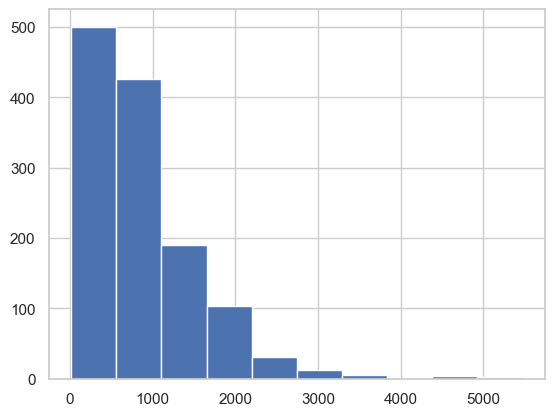

In [210]:
A.hist(bins=10)

In [211]:
stats.shapiro(B.values)

ShapiroResult(statistic=0.7846199371230334, pvalue=8.176292355384709e-32)

<Axes: >

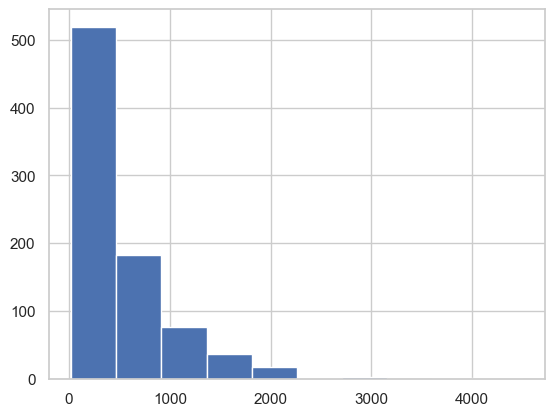

In [212]:
B.hist(bins=10)

In [213]:
stats.shapiro(C.values)

ShapiroResult(statistic=0.5450601637453936, pvalue=1.360616472184696e-20)

<Axes: >

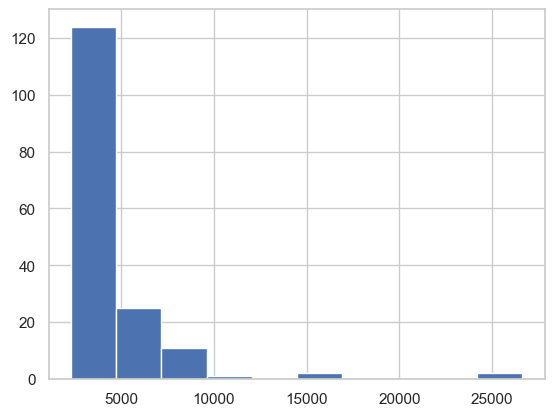

In [214]:
C.hist(bins=10)

In [215]:
stats.shapiro(D.values)

ShapiroResult(statistic=0.5056689928805813, pvalue=1.783068669637844e-18)

<Axes: >

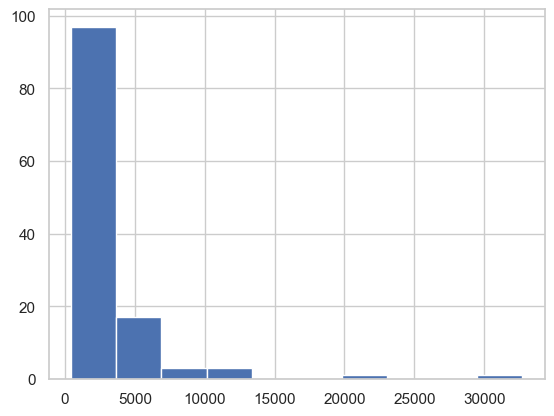

In [216]:
D.hist(bins=10)

**Распределения слишком далеки от номрмальных, необходимо использовать метод Манна-уитни**

Средний чек в кластерах 0 и кластере 2 распределен не нормально, ttest даст некорректный результат

In [217]:
result1 = stats.mannwhitneyu(A.values, B.values)[1]

In [218]:
alpha = 0.05/3
print('p-значение: ', "{0:.6f}".format(result1))

if result1 < alpha: print('Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в кластере 1 статистически значимы')
else: print('Между средним чеком покупателей в кластере 0 и средним чеком покупателей и кластером 1 нет статистически значимых различий')

p-значение:  0.000000
Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в кластере 1 статистически значимы


In [219]:
result2 = stats.mannwhitneyu(A.values, C.values)[1]

In [220]:
alpha = 0.05/3
print('p-значение: ', "{0:.6f}".format(result2))

if result2 < alpha: print('Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в кластере 2 статистически значимы')
else: print('Между средним чеком покупателей в кластере 0 и средним чеком покупателей и кластером 2 нет статистически значимых различий')

p-значение:  0.000000
Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в кластере 2 статистически значимы


In [221]:
result3 = stats.mannwhitneyu(A.values, D.values)[1]

In [222]:
alpha = 0.05/3
print('p-значение: ', "{0:.6f}".format(result3))

if result3 < alpha: print('Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в кластере 3 статистически значимы')
else: print('Между средним чеком покупателей в кластере 0 и средним чеком покупателей и кластером 3 нет статистически значимых различий')

p-значение:  0.000000
Различия между средним чеком покупателей в кластере 0 и средним чеком покупателей в кластере 3 статистически значимы


In [223]:
print('средний чек в кластере 0: ', A.mean())
print('средний чек в кластере 1: ', B.mean())
print('средний чек в кластере 2: ', C.mean())
print('средний чек в кластере 3: ', D.mean())

средний чек в кластере 0:  889.6464145768026
средний чек в кластере 1:  508.03221957040574
средний чек в кластере 2:  4425.445959595959
средний чек в кластере 3:  2934.69262295082


**Средний чек заказа клиентов в кластере 0 статистически значимо отличается от средних чеков клиентов в каждом другом кластере**

### Гипотеза о неравенстве среднего количества товаров в заказе между кластерами, проверяем нормальность распределения и используем парный t-тест независимых выборок.
     - Н0 Между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе покупателей в остальных кластерах нет статистически значимых различий
     - Н1 Различия между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе покупателей в остальных кластерах статистически значимы

In [224]:
A = pd.Series(customers[customers['cluster_km2'] == 0]['avg_qty'])
B = pd.Series(customers[customers['cluster_km2'] == 1]['avg_qty'])
C = pd.Series(customers[customers['cluster_km2'] == 2]['avg_qty'])
D = pd.Series(customers[customers['cluster_km2'] == 3]['avg_qty'])

In [225]:
stats.shapiro(pd.Series(customers['avg_qty']).values)

ShapiroResult(statistic=0.4565677404334889, pvalue=5.022314159335527e-65)

<Axes: >

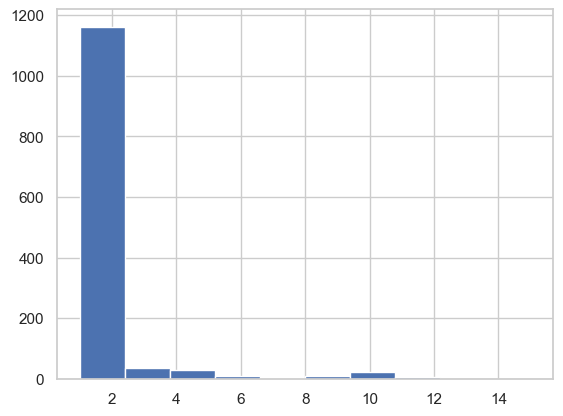

In [226]:
A.hist(bins=10)

In [227]:
stats.shapiro(A.values)

ShapiroResult(statistic=0.3642525556531737, pvalue=8.674974741196309e-55)

<Axes: >

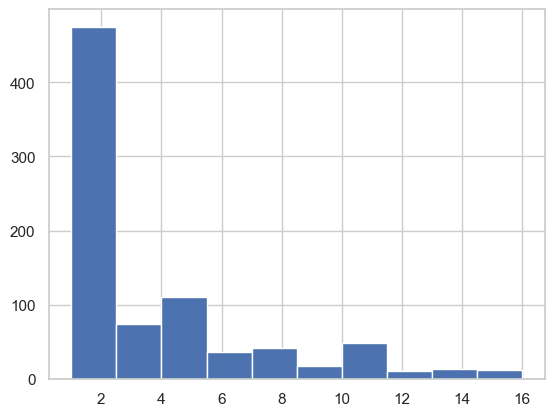

In [228]:
B.hist(bins=10)

In [229]:
stats.shapiro(B.values)

ShapiroResult(statistic=0.7588670613197903, pvalue=3.002224409160849e-33)

<Axes: >

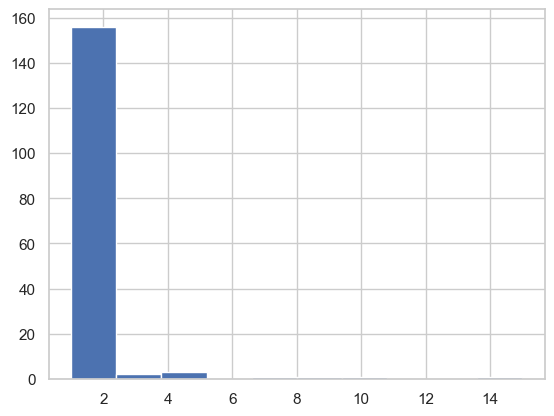

In [230]:
C.hist(bins=10)

In [231]:
stats.shapiro(C.values)

ShapiroResult(statistic=0.28292567978457117, pvalue=5.009622181089667e-25)

<Axes: >

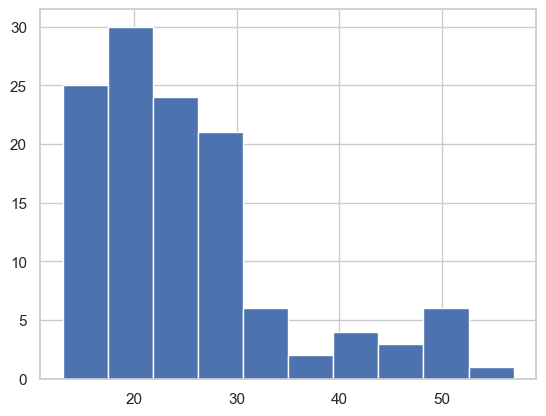

In [232]:
D.hist(bins=10)

In [233]:
stats.shapiro(D.values)

ShapiroResult(statistic=0.8725861206101428, pvalue=7.94430977539397e-09)

**Распределения слишком далеки от номрмальных, необходимо использовать метод манна-уитни**

Т.к. для подтверждения гипотезы нам нужно сделать 3 теста, необходимо внести корректировку p=value на множественное тестирование.

In [234]:
alpha = 0.05/3

print('p-значение: ', "{0:.3f}".format(stats.mannwhitneyu(C.values, A.values)[1]))

if stats.mannwhitneyu(C.values, A.values)[1] < alpha:
    print('Отвергаем нулевую гипотезу: Различия между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе в кластере 0 статистически значимы')
else:
    print('Между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе покупателей в кластере 0 нет статистически значимых различий') 

p-значение:  0.243
Между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе покупателей в кластере 0 нет статистически значимых различий


In [235]:
alpha = 0.05/3

print('p-значение: ', "{0:.3f}".format(stats.mannwhitneyu(C.values, B.values)[1]))

if stats.mannwhitneyu(C.values, B.values)[1] < alpha:
    print('Отвергаем нулевую гипотезу: Различия между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе в кластере 1 статистически значимы')
else:
    print('Между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе покупателей в кластере 1 нет статистически значимых различий') 

p-значение:  0.000
Отвергаем нулевую гипотезу: Различия между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе в кластере 1 статистически значимы


In [236]:
alpha = 0.05/3

print('p-значение: ', "{0:.3f}".format(stats.mannwhitneyu(C.values, D.values)[1]))

if stats.mannwhitneyu(C.values, D.values)[1] < alpha:
    print('Отвергаем нулевую гипотезу: Различия между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе в кластере 3 статистически значимы')
else:
    print('Между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе покупателей в кластере 3 нет статистически значимых различий') 

p-значение:  0.000
Отвергаем нулевую гипотезу: Различия между средним количеством товаров в заказе покупателей в кластере 2 и средним количеством товаров в заказе в кластере 3 статистически значимы


In [237]:
print('среднее количество товаров в кластере 0: ', A.mean())
print('среднее количество товаров в кластере 1: ', B.mean())
print('среднее количество товаров в кластере 2: ', C.mean())
print('среднее количество товаров в кластере 3: ', D.mean())

среднее количество товаров в кластере 0:  1.552324973876698
среднее количество товаров в кластере 1:  3.5397772474144786
среднее количество товаров в кластере 2:  1.4141414141414141
среднее количество товаров в кластере 3:  25.524590163934427


**Среднее количество товаров в заказе клиентов в кластере 3 статистически значимо отличается от среднего количества товаров в заказе клиентов в каждом другом кластере**

## Общий вывод и рекомендации по рассылкам

### Ситуция в компании

**Товары:**

Ассортимент продукции компании можно разделить на группы: рассада, бытовые товары, посуда, тара и декор.

- Бытовые товары составляют 53% продаж в разраезе доходов и 37% в натуральных величинах.
- Рассада и растения составляют 28% продаж от количества и 12% от доходов.
- Декор самый дешевый, составляет всего 4% в доходе, но 18% в натуральных величинах.
- Тара - самая дорогостоящая категория, составляет 22% продаж в разрезе доходов и 6% в натуральных величинах.

1. В категории рассада преобладают розничные клиенты с малым количеством товаров в заказе.

- Декоративные растения пользуются популярностью весной
- плодовые обычно покупают на рассаду за год до начала сезона, эта категория поможет сгладить ярко выраженную сезонность спроса, однако в ней могут наблюдаться проблемы.

**Данные продаж товаров по категории Рассада говорят о возможных проблемах с товарным ассортиментом. Спрос на многие плодовые растения резко снизился в 2019 году.**

*Рекомендуется проверить ассортимент рассады и составить конкуретные карты по самым ходовым позициям.*

2. В остальных категорих заказы можно разбить на розничные и мелкооптовые.

- Мелкооптовые заказы дают до 40% дохода в Бытовых товарах, посуде, таре, декоре. Однако по всем оптовым заказам наблюдается резкий спад во второй половине 2019 года.

**Работа и коммуникация с оптовыми и розничными сегментами клиентов должна строится по-разному.**

Оптовые заказчики обычно покупают товары для нужд бизнеса, по имеющимся данным сложно спрогнозировать и охарактеризовать их потребности, однако по динамике продаж четко видно отсутствие продаж оптовикам с ноября 2019 года.

Работа с оптовиками требует индивидуального подхода, их можно включать в обычные рассылки, однако также им необходимо делать индивидуальные предложения, оптимальнее всего назначить отдельного менеджера по работе с оптовыми клиентами, предложить им выгодные условия и сроки поставки.

*Вопрос о причинах ухода оптовиков нужно прорабатывать отдельно, налаживать прямое взаимодействие с оптовиками, поднимать базу оптовых клиентов и возвращать сегмент*


**Продажи в динамике**

В продажах товаров есть ярко выраженная сезонность с пиком в июне и малым в октябре.
Если рассматривать одинаковые месяцы анализируемого периода: октябрь 2018 - январь 2019 и октябрь 2019 - январь 2020, наблюдается серьёзный спад продаж, как в количественном, так и встоимостном выражении.

По имеющимся данным, дела у интернет-магазина в анализируемом периоде идут не лучшим образом:
-	количество заказанных товаров упало в 3 раза
-	доход просел на 40%
-	медианный средний чек уменьшился в 4 раза
-	среднее количество товаров в заказе снизилось до 1
-   ушла большая часть мелкооптовых покупателей
-	при этом количество заказов остаётся высоким, что, вероятно, влияет на маржинальность, накладывая дополнительные издержки для обработки и доставки заказов


**Поведение клиентов**

- 63% клиентов осуществили 1 заказ, 36% 2 заказа, 1% 3 и более
- для клиентов с 2 заказами заказы в среднем осуществляются 1 раз в 112 дней, для клиентов с 3 и более раз в 9 дней.
- клиенты с 2 заказами заказывают меньше других групп: в среднем 1,37 товара за заказ, для других групп среднее количество товаров в заказе больше 4.5.
- средний чек клиентов с 2 заказами также ниже других: 905 рублей, для клиентов с 1 заказом 1216, для клиентов с 3 и более заказми 945 рублей.
- клиенты с 3 и более заказами больше других заказывают саженцы и меньше всех бытовые товары и товары для кухни.

В текущей ситуации клиенты с 2 заказами в текущий момент показывают худшие поведенческие характеристики, чем остальные сегменты. Возможно это следствие недостаточной работы с клиентской базой и отсутствия программы лояльности.

### Рекомендации по рассылкам

**Таргетирование рассылок**

По условиям задачи у нас нет никакой информации о бизнес-модели и целях компании.

Интернет магазин может получать фиксированный доход с каждого заказа, с каждого товара или процент от стоимости товара. В зависимости от этого цели компании будут разными: рост числа заказов, рост числа проданных товаров или рост валовой стоимости проданных товаров. Также неизвестна маржинальность категорий товара.

*В связи с этим, рекомендации по рассылкам даны исходя из особенностей кластеров клиентов с целью максимизировать отдачу и увеличить возвратность каждого из кластеров клиентов.*


**Таргетирование рассылок по кластерам клиентов:**

1.	Кластер 0. 7% клиентов. Самый платежеспособный

**Цель:** удержать и замотивировать на повторные покупки.

**Даты рассылок:** Январь, июнь, июль, октябрь по бытовым товарам и посуде

**Вариант рассылки:** предложить новинки для ванной комнаты из товаров для дома (если была заказана гладильная доска - сушилку для белья, к сушилке - коврик и штору для ванной и т.д.), подборку посуды из раннее купленного набора, можно предложить кашпо для дома из дорогого сегмента.

2.	Кластер 1. 53% клиентов, самый большой сегмент, всего 1 заказ с малым чеком

**Цель:** расшевелить аудиторию, побудить к повторным покупкам, не отпугнуть дорогими товарами

**Даты рассылок:** Февраль-май по рассаде, бытовые товары без привязки к датам.

**Вариант рассылки:** растения по сезону, как плодовые, так и декоративные. Подборка бытовых товаров для уютной ванной комнаты. Подборка посуды из ранее приобретенной линейки.

3.	Кластер 2. 6% клиентов, покупающие больше всех, всего 1 заказ но много позиций

**Цель:** побудить к повторным покупкам, не отпугнуть дорогими товарами

**Даты рассылок:** декор: январь-февраль, рассада март-май.

**Вариант рассылки:** раз люди склонны к объемным заказам, облегчить им выбор готовыми наборами и тематическими подборками: идеальный сад - 20 декоративных растений для идеальной композиции; витаминная осень - 10 саженцев, которые должны быть на вашем участке; 10 мелочей для домашнего уюта - подборка декора; дача без забот - комплект из саженцев, удобрений и садового инвентаря.

4.	Кластер 3. 34% клиентов, совершили, в среднем, 2 заказа

**Цель:** удержать, склонить к повторным покупкам

**Даты рассылок:** Февраль-май по рассаде, бытовые товары и посуда ноябрь-январь.

**Вариант рассылки:** предложить новинки для ванной комнаты из товаров для дома (если была заказана гладильная доска - сушилку для белья, к сушилке - коврик и штору для ванной и т.д.) Растения по сезону, как плодовые, так и декоративные. Можно предложить бонусы за повторную покупку.


**Время рассылок**

Учитывая общую дизамику заказов, рассылки лучше проводить по понедельникам в районе 9-10 утра, у этого времени наивысший потенциал для конверсии рассылок в покупки.

**УТП рассылок**

Для перелома негативного тренда компании лучше сосредоточиться на увеличении среднего чека заказа и всех сопутствующих показателей:
-	количества товаров в заказе
-	стоимости 1 товара в заказе

В рассылке можно предложить клиентам скидки или бонусы при достижении определенной суммы заказа.

**Рассылки по бытовым товарам**

Большую часть продаж бытовых товаров розничным покупателям составляют Сушилки для белья, гладильные доски, коврики и шторы для ванных комнат. Все эти товары комплиментарные, можно увеличить продажи как через интернет магазин, баннерами "не забудьте также купить..." так и по рассылкам, присылая подборку других категорий, если клиент купил один из товаров категории

**Рассылки по посуде**

В продажах онлайн и рассылках стоит сделать упор на комплиментарности товаров в коллекции: если клиент купил посуду определенной марки, на сайте и в рассылках ему должны предлагаться другие товары той же марки для увеличения среднего чека. Скатерти могут предлагаться к любым розничным покупкам в категории "посуда".

**Рассылки по категории тара**

Хит продаж Сумка-тележка, приносит 73% дохода по категории, была в 46% заказов, 38% от товарооборота. Стоимость 2600.
Данный товар можно предлагать для увеличения среднего чека для покупателей в категории Рассада

**Рассылки в категории декор**

Отдельно можно выделить декоративные кашпо с живыми цветами. Это наиболее дорогостоящий товар в категории, продажи которого обеспечивали 35% дохода при 5% продаж в общем количестве.
Неплохой вариант для увеличения среднего чека розничных покупателей в товаров для дома и рассады.


### Прочие рекомендации

1. Провести анализ товарного ассортимента, конкурентные карты, выявить причины резкого спада продаж ранее популярных товаров.
2. Провести анализ причин снижения мелкооптовых заказов
3. Дополнить данные о клиентах социально-демаграфическим портретом
4. Выстроить индивидуальную работу с мелкооптовыми клиентами.

### Презентация к проекту

https://disk.yandex.ru/d/zc5Rk_Qzms75Mg